- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Adamax,Adagrad

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

In [4]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

In [5]:
#First Model
def create_model():
    model = Sequential()
    model.add(Dense(
        32, 
        activation='swish', 
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)))
    #model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='swish'))
    model.add(Dropout(0.2))
    #model.add(Dense(128,activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    optimizer=Adamax(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',auc_roc])
    return model

In [6]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=200, batch_size=512, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [7]:
# vif thresholds to apply to data and labels before grid search pipeline
#vif_thresholds = [0, 5]
vif_thresholds = [0]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
#features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])
features__k_ratios = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 3.0],
        'features__k': [12],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        #'model__batch_size': [8, 16, 24, 32, 40, 48],#usually multiple of 8
        #'model__epochs':[100,150,200],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search


Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 24 candidates, totalling 120 fits
0001 Epoch 1/200
4/4 [==============================] - 12s 159ms/step - loss: 0.6966 - accuracy: 0.5946 - auc_roc: 0.6349
Epoch 2/200
4/4 [==============================] - 1s 182ms/step - loss: 0.5851 - accuracy: 0.7089 - auc_roc: 0.7659
Epoch 3/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5603 - accuracy: 0.7286 - auc_roc: 0.7902
Epoch 4/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5573 - accuracy: 0.7158 - auc_roc: 0.7861
Epoch 5/200
4/4 [==============================] - 1s 178ms/step - loss: 0.5463 - accuracy: 0.7215 - auc_roc: 0.7931
Epoch 6/200
4/4 [==============================] - 1s 167ms/step - loss: 0.5639 - accuracy: 0.7131 - auc_roc: 0.7840
Epoch 7/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5595 - accuracy: 0.7232 - auc_roc: 0.7876
Epo

4/4 [==============================] - 1s 225ms/step - loss: 0.4835 - accuracy: 0.7731 - auc_roc: 0.8459
Epoch 69/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4894 - accuracy: 0.7614 - auc_roc: 0.8365
Epoch 70/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4721 - accuracy: 0.7743 - auc_roc: 0.8550
Epoch 71/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4909 - accuracy: 0.7639 - auc_roc: 0.8394
Epoch 72/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4969 - accuracy: 0.7615 - auc_roc: 0.8333
Epoch 73/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4920 - accuracy: 0.7680 - auc_roc: 0.8363
Epoch 74/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4848 - accuracy: 0.7717 - auc_roc: 0.8415
Epoch 75/200
4/4 [==============================] - 1s 196ms/step - loss: 0.4905 - accuracy: 0.7661 - auc_roc: 0.8394
Epoch 76/200
4/4 [==============================] - 1s 231ms/step - l

4/4 [==============================] - 1s 253ms/step - loss: 0.4749 - accuracy: 0.7788 - auc_roc: 0.8460
Epoch 138/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4592 - accuracy: 0.7807 - auc_roc: 0.8583
Epoch 139/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4696 - accuracy: 0.7736 - auc_roc: 0.8512
Epoch 140/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4701 - accuracy: 0.7694 - auc_roc: 0.8543
Epoch 141/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4707 - accuracy: 0.7784 - auc_roc: 0.8492
Epoch 142/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4686 - accuracy: 0.7764 - auc_roc: 0.8535
Epoch 143/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4602 - accuracy: 0.7800 - auc_roc: 0.8594
Epoch 144/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4691 - accuracy: 0.7778 - auc_roc: 0.8537
Epoch 145/200
4/4 [==============================] - 1s 253ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0002 Epoch 1/200
4/4 [==============================] - 18s 150ms/step - loss: 0.7854 - accuracy: 0.5355 - auc_roc: 0.7567
Epoch 2/200
4/4 [==============================] - 1s 157ms/step - loss: 0.6210 - accuracy: 0.6985 - auc_roc: 0.7405
Epoch 3/200
4/4 [==============================] - 1s 174ms/step - loss: 0.5937 - accuracy: 0.7045 - auc_roc: 0.7541
Epoch 4/200
4/4 [==============================] - 1s 157ms/step - loss: 0.5693 - accuracy: 0.7205 - auc_roc: 0.7795
Epoch 5/200
4/4 [==============================] - 1s 171ms/step - loss: 0.5604 - accuracy: 0.7119 - auc_roc: 0.7856
Epoch 6/200
4/4 [==============================] - 1s 174ms/step - loss: 0.5591 - accuracy: 0.7130 - auc_roc: 0.7826
Epoch 7/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5559 - accuracy: 0.7193 - auc_roc: 0.7852
Epoch 8/200
4/4 [==============================] - 1s 161ms/step - loss: 0.5662 - accuracy: 0.7076 - auc_roc: 0.7855
Epoch 

4/4 [==============================] - 1s 321ms/step - loss: 0.5022 - accuracy: 0.7582 - auc_roc: 0.8289
Epoch 70/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5077 - accuracy: 0.7509 - auc_roc: 0.8249
Epoch 71/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4979 - accuracy: 0.7621 - auc_roc: 0.8329
Epoch 72/200
4/4 [==============================] - 1s 315ms/step - loss: 0.5078 - accuracy: 0.7530 - auc_roc: 0.8258
Epoch 73/200
4/4 [==============================] - 1s 322ms/step - loss: 0.4984 - accuracy: 0.7580 - auc_roc: 0.8371
Epoch 74/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5034 - accuracy: 0.7591 - auc_roc: 0.8302
Epoch 75/200
4/4 [==============================] - 1s 297ms/step - loss: 0.4968 - accuracy: 0.7642 - auc_roc: 0.8355
Epoch 76/200
4/4 [==============================] - 1s 285ms/step - loss: 0.5107 - accuracy: 0.7537 - auc_roc: 0.8258
Epoch 77/200
4/4 [==============================] - 1s 313ms/step - l

4/4 [==============================] - 1s 294ms/step - loss: 0.4686 - accuracy: 0.7825 - auc_roc: 0.8531
Epoch 139/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4873 - accuracy: 0.7599 - auc_roc: 0.8421
Epoch 140/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4805 - accuracy: 0.7712 - auc_roc: 0.8521
Epoch 141/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4870 - accuracy: 0.7606 - auc_roc: 0.8411
Epoch 142/200
4/4 [==============================] - 1s 286ms/step - loss: 0.4670 - accuracy: 0.7777 - auc_roc: 0.8567
Epoch 143/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4873 - accuracy: 0.7640 - auc_roc: 0.8455
Epoch 144/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4831 - accuracy: 0.7786 - auc_roc: 0.8452
Epoch 145/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4842 - accuracy: 0.7726 - auc_roc: 0.8453
Epoch 146/200
4/4 [==============================] - 1s 241ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0003 Epoch 1/200
4/4 [==============================] - 12s 174ms/step - loss: 0.7965 - accuracy: 0.5441 - auc_roc: 0.7477
Epoch 2/200
4/4 [==============================] - 1s 181ms/step - loss: 0.6275 - accuracy: 0.7139 - auc_roc: 0.7481
Epoch 3/200
4/4 [==============================] - 1s 152ms/step - loss: 0.5931 - accuracy: 0.7119 - auc_roc: 0.7638
Epoch 4/200
4/4 [==============================] - 1s 149ms/step - loss: 0.5872 - accuracy: 0.7011 - auc_roc: 0.7592
Epoch 5/200
4/4 [==============================] - 1s 151ms/step - loss: 0.5791 - accuracy: 0.7192 - auc_roc: 0.7693
Epoch 6/200
4/4 [==============================] - 1s 128ms/step - loss: 0.5627 - accuracy: 0.7230 - auc_roc: 0.7867
Epoch 7/200
4/4 [==============================] - 1s 173ms/step - loss: 0.5597 - accuracy: 0.7268 - auc_roc: 0.7870
Epoch 8/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5617 - accuracy: 0.7242 - auc_roc: 0.7836
Epoch 

4/4 [==============================] - 1s 293ms/step - loss: 0.5046 - accuracy: 0.7594 - auc_roc: 0.8292
Epoch 71/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5182 - accuracy: 0.7500 - auc_roc: 0.8207
Epoch 72/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5105 - accuracy: 0.7465 - auc_roc: 0.8219
Epoch 73/200
4/4 [==============================] - 1s 388ms/step - loss: 0.5046 - accuracy: 0.7621 - auc_roc: 0.8315
Epoch 74/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5105 - accuracy: 0.7559 - auc_roc: 0.8247
Epoch 75/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5038 - accuracy: 0.7601 - auc_roc: 0.8307
Epoch 76/200
4/4 [==============================] - 1s 302ms/step - loss: 0.5015 - accuracy: 0.7625 - auc_roc: 0.8323
Epoch 77/200
4/4 [==============================] - 1s 314ms/step - loss: 0.5076 - accuracy: 0.7532 - auc_roc: 0.8286
Epoch 78/200
4/4 [==============================] - 1s 269ms/step - l

4/4 [==============================] - 1s 236ms/step - loss: 0.4816 - accuracy: 0.7741 - auc_roc: 0.8487
Epoch 140/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4808 - accuracy: 0.7694 - auc_roc: 0.8448
Epoch 141/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4912 - accuracy: 0.7544 - auc_roc: 0.8353
Epoch 142/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4822 - accuracy: 0.7678 - auc_roc: 0.8420
Epoch 143/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4910 - accuracy: 0.7676 - auc_roc: 0.8349
Epoch 144/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4772 - accuracy: 0.7716 - auc_roc: 0.8509
Epoch 145/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4824 - accuracy: 0.7618 - auc_roc: 0.8445
Epoch 146/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4767 - accuracy: 0.7813 - auc_roc: 0.8486
Epoch 147/200
4/4 [==============================] - 1s 242ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0004 Epoch 1/200
4/4 [==============================] - 18s 236ms/step - loss: 0.6681 - accuracy: 0.5927 - auc_roc: 0.7886
Epoch 2/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5753 - accuracy: 0.6999 - auc_roc: 0.7758
Epoch 3/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5841 - accuracy: 0.7068 - auc_roc: 0.7755
Epoch 4/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5629 - accuracy: 0.7322 - auc_roc: 0.7884
Epoch 5/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5611 - accuracy: 0.7118 - auc_roc: 0.7790
Epoch 6/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5819 - accuracy: 0.7089 - auc_roc: 0.7685
Epoch 7/200
4/4 [==============================] - 1s 224ms/step - loss: 0.5639 - accuracy: 0.7283 - auc_roc: 0.7872
Epoch 8/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5467 - accuracy: 0.7362 - auc_roc: 0.7981
Epoch 9

4/4 [==============================] - 1s 240ms/step - loss: 0.5227 - accuracy: 0.7596 - auc_roc: 0.8176
Epoch 71/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5218 - accuracy: 0.7524 - auc_roc: 0.8177
Epoch 72/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5201 - accuracy: 0.7546 - auc_roc: 0.8186
Epoch 73/200
4/4 [==============================] - 1s 229ms/step - loss: 0.5184 - accuracy: 0.7475 - auc_roc: 0.8188
Epoch 74/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5148 - accuracy: 0.7618 - auc_roc: 0.8240
Epoch 75/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5222 - accuracy: 0.7455 - auc_roc: 0.8137
Epoch 76/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5178 - accuracy: 0.7524 - auc_roc: 0.8189
Epoch 77/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5134 - accuracy: 0.7493 - auc_roc: 0.8214
Epoch 78/200
4/4 [==============================] - 1s 245ms/step - l

4/4 [==============================] - 1s 204ms/step - loss: 0.4878 - accuracy: 0.7697 - auc_roc: 0.8419
Epoch 140/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4970 - accuracy: 0.7721 - auc_roc: 0.8370
Epoch 141/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5040 - accuracy: 0.7630 - auc_roc: 0.8285
Epoch 142/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4898 - accuracy: 0.7610 - auc_roc: 0.8427
Epoch 143/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5054 - accuracy: 0.7556 - auc_roc: 0.8301
Epoch 144/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4879 - accuracy: 0.7768 - auc_roc: 0.8453
Epoch 145/200
4/4 [==============================] - 1s 182ms/step - loss: 0.4897 - accuracy: 0.7655 - auc_roc: 0.8418
Epoch 146/200
4/4 [==============================] - 1s 189ms/step - loss: 0.4906 - accuracy: 0.7743 - auc_roc: 0.8398
Epoch 147/200
4/4 [==============================] - 1s 179ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0005 Epoch 1/200
4/4 [==============================] - 22s 216ms/step - loss: 0.6916 - accuracy: 0.6166 - auc_roc: 0.7786
Epoch 2/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5962 - accuracy: 0.6972 - auc_roc: 0.7706
Epoch 3/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5775 - accuracy: 0.7195 - auc_roc: 0.7856
Epoch 4/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5728 - accuracy: 0.7076 - auc_roc: 0.7824
Epoch 5/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5540 - accuracy: 0.7230 - auc_roc: 0.7924
Epoch 6/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5514 - accuracy: 0.7399 - auc_roc: 0.7989
Epoch 7/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5587 - accuracy: 0.7218 - auc_roc: 0.7888
Epoch 8/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5451 - accuracy: 0.7269 - auc_roc: 0.7999
Epoch 9

4/4 [==============================] - 1s 266ms/step - loss: 0.4984 - accuracy: 0.7519 - auc_roc: 0.8318
Epoch 71/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5008 - accuracy: 0.7700 - auc_roc: 0.8335
Epoch 72/200
4/4 [==============================] - 1s 293ms/step - loss: 0.4914 - accuracy: 0.7554 - auc_roc: 0.8385
Epoch 73/200
4/4 [==============================] - 1s 312ms/step - loss: 0.4905 - accuracy: 0.7767 - auc_roc: 0.8377
Epoch 74/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4913 - accuracy: 0.7611 - auc_roc: 0.8386
Epoch 75/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4925 - accuracy: 0.7752 - auc_roc: 0.8368
Epoch 76/200
4/4 [==============================] - 1s 289ms/step - loss: 0.4854 - accuracy: 0.7700 - auc_roc: 0.8412
Epoch 77/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4813 - accuracy: 0.7750 - auc_roc: 0.8458
Epoch 78/200
4/4 [==============================] - 1s 233ms/step - l

4/4 [==============================] - 1s 187ms/step - loss: 0.4843 - accuracy: 0.7617 - auc_roc: 0.8432
Epoch 140/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4817 - accuracy: 0.7703 - auc_roc: 0.8417
Epoch 141/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4657 - accuracy: 0.7850 - auc_roc: 0.8557
Epoch 142/200
4/4 [==============================] - 1s 291ms/step - loss: 0.4944 - accuracy: 0.7647 - auc_roc: 0.8369
Epoch 143/200
4/4 [==============================] - 1s 306ms/step - loss: 0.4548 - accuracy: 0.7840 - auc_roc: 0.8646
Epoch 144/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4704 - accuracy: 0.7714 - auc_roc: 0.8527
Epoch 145/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4771 - accuracy: 0.7714 - auc_roc: 0.8447
Epoch 146/200
4/4 [==============================] - 1s 272ms/step - loss: 0.4685 - accuracy: 0.7810 - auc_roc: 0.8529
Epoch 147/200
4/4 [==============================] - 1s 258ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 46ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0006 Epoch 1/200
4/4 [==============================] - 22s 239ms/step - loss: 0.6658 - accuracy: 0.6307 - auc_roc: 0.7949
Epoch 2/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5910 - accuracy: 0.7172 - auc_roc: 0.7731
Epoch 3/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5625 - accuracy: 0.7128 - auc_roc: 0.7829
Epoch 4/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5612 - accuracy: 0.7160 - auc_roc: 0.7846
Epoch 5/200
4/4 [==============================] - 1s 182ms/step - loss: 0.5640 - accuracy: 0.7238 - auc_roc: 0.7864
Epoch 6/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5488 - accuracy: 0.7259 - auc_roc: 0.7898
Epoch 7/200
4/4 [==============================] - 1s 158ms/step - loss: 0.5240 - accuracy: 0.7350 - auc_roc: 0.8188
Epoch 8/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5532 - accuracy: 0.7234 - auc_roc: 0.7915
Epoch 

4/4 [==============================] - 1s 231ms/step - loss: 0.4853 - accuracy: 0.7659 - auc_roc: 0.8377
Epoch 71/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4939 - accuracy: 0.7596 - auc_roc: 0.8370
Epoch 72/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5008 - accuracy: 0.7534 - auc_roc: 0.8294
Epoch 73/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4970 - accuracy: 0.7479 - auc_roc: 0.8332
Epoch 74/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4921 - accuracy: 0.7677 - auc_roc: 0.8397
Epoch 75/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4950 - accuracy: 0.7582 - auc_roc: 0.8336
Epoch 76/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4856 - accuracy: 0.7640 - auc_roc: 0.8427
Epoch 77/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4850 - accuracy: 0.7597 - auc_roc: 0.8465
Epoch 78/200
4/4 [==============================] - 1s 235ms/step - l

4/4 [==============================] - 1s 235ms/step - loss: 0.4649 - accuracy: 0.7781 - auc_roc: 0.8563
Epoch 140/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4671 - accuracy: 0.7732 - auc_roc: 0.8529
Epoch 141/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4693 - accuracy: 0.7777 - auc_roc: 0.8534
Epoch 142/200
4/4 [==============================] - 1s 291ms/step - loss: 0.4546 - accuracy: 0.7805 - auc_roc: 0.8654
Epoch 143/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4713 - accuracy: 0.7620 - auc_roc: 0.8524
Epoch 144/200
4/4 [==============================] - 1s 207ms/step - loss: 0.4665 - accuracy: 0.7851 - auc_roc: 0.8559
Epoch 145/200
4/4 [==============================] - 1s 148ms/step - loss: 0.4613 - accuracy: 0.7747 - auc_roc: 0.8591
Epoch 146/200
4/4 [==============================] - 1s 155ms/step - loss: 0.4681 - accuracy: 0.7755 - auc_roc: 0.8576
Epoch 147/200
4/4 [==============================] - 1s 150ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 79ms/step
0007 Epoch 1/200
4/4 [==============================] - 23s 217ms/step - loss: 0.7068 - accuracy: 0.5870 - auc_roc: 0.7796
Epoch 2/200
4/4 [==============================] - 1s 240ms/step - loss: 0.6123 - accuracy: 0.6856 - auc_roc: 0.7526
Epoch 3/200
4/4 [==============================] - 1s 214ms/step - loss: 0.5842 - accuracy: 0.7080 - auc_roc: 0.7649
Epoch 4/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5695 - accuracy: 0.7284 - auc_roc: 0.7777
Epoch 5/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5821 - accuracy: 0.7034 - auc_roc: 0.7580
Epoch 6/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5606 - accuracy: 0.7127 - auc_roc: 0.7813
Epoch 7/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5402 - accuracy: 0.7213 - auc_roc: 0.7970
Epoch 8/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5592 - accuracy: 0.7240 - auc_roc: 0.7792
Epoch 

4/4 [==============================] - 1s 203ms/step - loss: 0.4959 - accuracy: 0.7516 - auc_roc: 0.8327
Epoch 71/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4972 - accuracy: 0.7512 - auc_roc: 0.8301
Epoch 72/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4936 - accuracy: 0.7544 - auc_roc: 0.8321
Epoch 73/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4856 - accuracy: 0.7603 - auc_roc: 0.8382
Epoch 74/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4978 - accuracy: 0.7602 - auc_roc: 0.8312
Epoch 75/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4967 - accuracy: 0.7488 - auc_roc: 0.8287
Epoch 76/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4950 - accuracy: 0.7547 - auc_roc: 0.8295
Epoch 77/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4977 - accuracy: 0.7541 - auc_roc: 0.8255
Epoch 78/200
4/4 [==============================] - 1s 242ms/step - l

4/4 [==============================] - 1s 220ms/step - loss: 0.4721 - accuracy: 0.7708 - auc_roc: 0.8459
Epoch 140/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4747 - accuracy: 0.7713 - auc_roc: 0.8470
Epoch 141/200
4/4 [==============================] - 1s 289ms/step - loss: 0.4735 - accuracy: 0.7778 - auc_roc: 0.8465
Epoch 142/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4533 - accuracy: 0.7884 - auc_roc: 0.8615
Epoch 143/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4745 - accuracy: 0.7764 - auc_roc: 0.8470
Epoch 144/200
4/4 [==============================] - 1s 301ms/step - loss: 0.4704 - accuracy: 0.7759 - auc_roc: 0.8513
Epoch 145/200
4/4 [==============================] - 1s 298ms/step - loss: 0.4702 - accuracy: 0.7827 - auc_roc: 0.8492
Epoch 146/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4791 - accuracy: 0.7699 - auc_roc: 0.8395
Epoch 147/200
4/4 [==============================] - 1s 261ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0008 Epoch 1/200
4/4 [==============================] - 18s 208ms/step - loss: 0.7253 - accuracy: 0.5981 - auc_roc: 0.7820
Epoch 2/200
4/4 [==============================] - 1s 204ms/step - loss: 0.6108 - accuracy: 0.6873 - auc_roc: 0.7533
Epoch 3/200
4/4 [==============================] - 1s 169ms/step - loss: 0.5932 - accuracy: 0.7059 - auc_roc: 0.7679
Epoch 4/200
4/4 [==============================] - 1s 146ms/step - loss: 0.5620 - accuracy: 0.7122 - auc_roc: 0.7804
Epoch 5/200
4/4 [==============================] - 1s 168ms/step - loss: 0.5670 - accuracy: 0.7242 - auc_roc: 0.7834
Epoch 6/200
4/4 [==============================] - 1s 148ms/step - loss: 0.5527 - accuracy: 0.7377 - auc_roc: 0.7933
Epoch 7/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5350 - accuracy: 0.7438 - auc_roc: 0.8107
Epoch 8/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5317 - accuracy: 0.7348 - auc_roc: 0.8071
Epoch 9

4/4 [==============================] - 1s 229ms/step - loss: 0.5017 - accuracy: 0.7673 - auc_roc: 0.8343
Epoch 71/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5077 - accuracy: 0.7514 - auc_roc: 0.8275
Epoch 72/200
4/4 [==============================] - 1s 222ms/step - loss: 0.5150 - accuracy: 0.7643 - auc_roc: 0.8226
Epoch 73/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4984 - accuracy: 0.7605 - auc_roc: 0.8366
Epoch 74/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4906 - accuracy: 0.7461 - auc_roc: 0.8371
Epoch 75/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5060 - accuracy: 0.7627 - auc_roc: 0.8244
Epoch 76/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4924 - accuracy: 0.7652 - auc_roc: 0.8366
Epoch 77/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4965 - accuracy: 0.7576 - auc_roc: 0.8342
Epoch 78/200
4/4 [==============================] - 1s 257ms/step - l

4/4 [==============================] - 1s 242ms/step - loss: 0.4722 - accuracy: 0.7704 - auc_roc: 0.8507
Epoch 140/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4842 - accuracy: 0.7642 - auc_roc: 0.8424
Epoch 141/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4921 - accuracy: 0.7615 - auc_roc: 0.8367
Epoch 142/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4835 - accuracy: 0.7634 - auc_roc: 0.8475
Epoch 143/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4745 - accuracy: 0.7774 - auc_roc: 0.8502
Epoch 144/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4874 - accuracy: 0.7591 - auc_roc: 0.8375
Epoch 145/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4675 - accuracy: 0.7776 - auc_roc: 0.8582
Epoch 146/200
4/4 [==============================] - 1s 272ms/step - loss: 0.4696 - accuracy: 0.7594 - auc_roc: 0.8527
Epoch 147/200
4/4 [==============================] - 1s 221ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 65ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 41ms/step
0009 Epoch 1/200
4/4 [==============================] - 24s 250ms/step - loss: 0.7752 - accuracy: 0.5017 - auc_roc: 0.7494
Epoch 2/200
4/4 [==============================] - 1s 243ms/step - loss: 0.6024 - accuracy: 0.6967 - auc_roc: 0.7520
Epoch 3/200
4/4 [==============================] - 1s 197ms/step - loss: 0.5803 - accuracy: 0.7316 - auc_roc: 0.7772
Epoch 4/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5835 - accuracy: 0.7088 - auc_roc: 0.7681
Epoch 5/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5745 - accuracy: 0.7080 - auc_roc: 0.7754
Epoch 6/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5567 - accuracy: 0.7266 - auc_roc: 0.7887
Epoch 7/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5513 - accuracy: 0.7318 - auc_roc: 0.7903
Epoch 8/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5336 - accuracy: 0.7487 - auc_roc: 0.8061
Epoch 

4/4 [==============================] - 1s 180ms/step - loss: 0.5084 - accuracy: 0.7584 - auc_roc: 0.8272
Epoch 71/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5185 - accuracy: 0.7468 - auc_roc: 0.8201
Epoch 72/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5045 - accuracy: 0.7589 - auc_roc: 0.8304
Epoch 73/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5178 - accuracy: 0.7606 - auc_roc: 0.8224
Epoch 74/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4967 - accuracy: 0.7693 - auc_roc: 0.8334
Epoch 75/200
4/4 [==============================] - 1s 212ms/step - loss: 0.5273 - accuracy: 0.7558 - auc_roc: 0.8140
Epoch 76/200
4/4 [==============================] - 1s 153ms/step - loss: 0.5249 - accuracy: 0.7545 - auc_roc: 0.8162
Epoch 77/200
4/4 [==============================] - 1s 161ms/step - loss: 0.5199 - accuracy: 0.7530 - auc_roc: 0.8182
Epoch 78/200
4/4 [==============================] - 1s 207ms/step - l

4/4 [==============================] - 1s 304ms/step - loss: 0.4909 - accuracy: 0.7715 - auc_roc: 0.8413
Epoch 140/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5092 - accuracy: 0.7537 - auc_roc: 0.8276
Epoch 141/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4936 - accuracy: 0.7619 - auc_roc: 0.8368
Epoch 142/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4991 - accuracy: 0.7606 - auc_roc: 0.8361
Epoch 143/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5011 - accuracy: 0.7603 - auc_roc: 0.8313
Epoch 144/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4944 - accuracy: 0.7697 - auc_roc: 0.8394
Epoch 145/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4956 - accuracy: 0.7654 - auc_roc: 0.8370
Epoch 146/200
4/4 [==============================] - 1s 296ms/step - loss: 0.5025 - accuracy: 0.7579 - auc_roc: 0.8305
Epoch 147/200
4/4 [==============================] - 1s 282ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 88ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 98ms/step
0010 Epoch 1/200
4/4 [==============================] - 23s 271ms/step - loss: 0.6574 - accuracy: 0.6350 - auc_roc: 0.7869
Epoch 2/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5779 - accuracy: 0.7084 - auc_roc: 0.7756
Epoch 3/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5616 - accuracy: 0.7309 - auc_roc: 0.7921
Epoch 4/200
4/4 [==============================] - 1s 301ms/step - loss: 0.5528 - accuracy: 0.7192 - auc_roc: 0.7931
Epoch 5/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5529 - accuracy: 0.7163 - auc_roc: 0.7947
Epoch 6/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5511 - accuracy: 0.7334 - auc_roc: 0.8000
Epoch 7/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5402 - accuracy: 0.7207 - auc_roc: 0.8029
Epoch 8/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5603 - accuracy: 0.7129 - auc_roc: 0.7850
Epoch 

4/4 [==============================] - 1s 253ms/step - loss: 0.4807 - accuracy: 0.7696 - auc_roc: 0.8461
Epoch 71/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4906 - accuracy: 0.7569 - auc_roc: 0.8381
Epoch 72/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4926 - accuracy: 0.7587 - auc_roc: 0.8383
Epoch 73/200
4/4 [==============================] - 1s 276ms/step - loss: 0.4885 - accuracy: 0.7671 - auc_roc: 0.8393
Epoch 74/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4867 - accuracy: 0.7733 - auc_roc: 0.8436
Epoch 75/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4833 - accuracy: 0.7678 - auc_roc: 0.8455
Epoch 76/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4969 - accuracy: 0.7534 - auc_roc: 0.8327
Epoch 77/200
4/4 [==============================] - 1s 210ms/step - loss: 0.5036 - accuracy: 0.7505 - auc_roc: 0.8289
Epoch 78/200
4/4 [==============================] - 1s 205ms/step - l

4/4 [==============================] - 1s 257ms/step - loss: 0.4735 - accuracy: 0.7705 - auc_roc: 0.8500
Epoch 140/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4593 - accuracy: 0.7775 - auc_roc: 0.8604
Epoch 141/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4532 - accuracy: 0.7773 - auc_roc: 0.8608
Epoch 142/200
4/4 [==============================] - 1s 281ms/step - loss: 0.4533 - accuracy: 0.7828 - auc_roc: 0.8660
Epoch 143/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4520 - accuracy: 0.7833 - auc_roc: 0.8671
Epoch 144/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4703 - accuracy: 0.7767 - auc_roc: 0.8521
Epoch 145/200
4/4 [==============================] - 1s 324ms/step - loss: 0.4716 - accuracy: 0.7776 - auc_roc: 0.8505
Epoch 146/200
4/4 [==============================] - 1s 284ms/step - loss: 0.4438 - accuracy: 0.7976 - auc_roc: 0.8693
Epoch 147/200
4/4 [==============================] - 1s 348ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 37ms/step
0011 Epoch 1/200
4/4 [==============================] - 22s 212ms/step - loss: 0.7071 - accuracy: 0.5815 - auc_roc: 0.7843
Epoch 2/200
4/4 [==============================] - 1s 192ms/step - loss: 0.5921 - accuracy: 0.7050 - auc_roc: 0.7689
Epoch 3/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5836 - accuracy: 0.7236 - auc_roc: 0.7785
Epoch 4/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5789 - accuracy: 0.7106 - auc_roc: 0.7722
Epoch 5/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5523 - accuracy: 0.7383 - auc_roc: 0.8001
Epoch 6/200
4/4 [==============================] - 1s 191ms/step - loss: 0.5437 - accuracy: 0.7287 - auc_roc: 0.8026
Epoch 7/200
4/4 [==============================] - 1s 161ms/step - loss: 0.5472 - accuracy: 0.7259 - auc_roc: 0.8009
Epoch 8/200
4/4 [==============================] - 1s 176ms/step - loss: 0.5464 - accuracy: 0.7268 - auc_roc: 0.7973
Epoch 

4/4 [==============================] - 1s 232ms/step - loss: 0.4863 - accuracy: 0.7543 - auc_roc: 0.8442
Epoch 71/200
4/4 [==============================] - 1s 216ms/step - loss: 0.5080 - accuracy: 0.7493 - auc_roc: 0.8296
Epoch 72/200
4/4 [==============================] - 1s 289ms/step - loss: 0.4975 - accuracy: 0.7573 - auc_roc: 0.8333
Epoch 73/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5067 - accuracy: 0.7518 - auc_roc: 0.8301
Epoch 74/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5080 - accuracy: 0.7424 - auc_roc: 0.8275
Epoch 75/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4976 - accuracy: 0.7747 - auc_roc: 0.8371
Epoch 76/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4903 - accuracy: 0.7625 - auc_roc: 0.8414
Epoch 77/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4937 - accuracy: 0.7532 - auc_roc: 0.8357
Epoch 78/200
4/4 [==============================] - 1s 181ms/step - l

4/4 [==============================] - 1s 313ms/step - loss: 0.4836 - accuracy: 0.7606 - auc_roc: 0.8452
Epoch 140/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4633 - accuracy: 0.7771 - auc_roc: 0.8601
Epoch 141/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4703 - accuracy: 0.7790 - auc_roc: 0.8535
Epoch 142/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4641 - accuracy: 0.7655 - auc_roc: 0.8602
Epoch 143/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4659 - accuracy: 0.7731 - auc_roc: 0.8562
Epoch 144/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4761 - accuracy: 0.7662 - auc_roc: 0.8524
Epoch 145/200
4/4 [==============================] - 1s 310ms/step - loss: 0.4586 - accuracy: 0.7774 - auc_roc: 0.8630
Epoch 146/200
4/4 [==============================] - 1s 286ms/step - loss: 0.4625 - accuracy: 0.7816 - auc_roc: 0.8592
Epoch 147/200
4/4 [==============================] - 1s 246ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 85ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0012 Epoch 1/200
4/4 [==============================] - 20s 240ms/step - loss: 0.7174 - accuracy: 0.5606 - auc_roc: 0.7719
Epoch 2/200
4/4 [==============================] - 1s 212ms/step - loss: 0.6102 - accuracy: 0.6819 - auc_roc: 0.7434
Epoch 3/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5787 - accuracy: 0.6952 - auc_roc: 0.7722
Epoch 4/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5785 - accuracy: 0.7056 - auc_roc: 0.7721
Epoch 5/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5513 - accuracy: 0.7255 - auc_roc: 0.7934
Epoch 6/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5557 - accuracy: 0.7114 - auc_roc: 0.7841
Epoch 7/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5554 - accuracy: 0.7150 - auc_roc: 0.7858
Epoch 8/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5480 - accuracy: 0.7273 - auc_roc: 0.7916
Epoch 9

4/4 [==============================] - 1s 258ms/step - loss: 0.4942 - accuracy: 0.7507 - auc_roc: 0.8316
Epoch 71/200
4/4 [==============================] - 1s 315ms/step - loss: 0.4855 - accuracy: 0.7655 - auc_roc: 0.8388
Epoch 72/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4922 - accuracy: 0.7557 - auc_roc: 0.8346
Epoch 73/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4930 - accuracy: 0.7632 - auc_roc: 0.8340
Epoch 74/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4839 - accuracy: 0.7694 - auc_roc: 0.8417
Epoch 75/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4815 - accuracy: 0.7753 - auc_roc: 0.8413
Epoch 76/200
4/4 [==============================] - 1s 304ms/step - loss: 0.4865 - accuracy: 0.7643 - auc_roc: 0.8380
Epoch 77/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4934 - accuracy: 0.7680 - auc_roc: 0.8345
Epoch 78/200
4/4 [==============================] - 1s 286ms/step - l

4/4 [==============================] - 1s 312ms/step - loss: 0.4783 - accuracy: 0.7624 - auc_roc: 0.8446
Epoch 140/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4552 - accuracy: 0.7828 - auc_roc: 0.8599
Epoch 141/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4481 - accuracy: 0.7847 - auc_roc: 0.8634
Epoch 142/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4565 - accuracy: 0.7832 - auc_roc: 0.8587
Epoch 143/200
4/4 [==============================] - 1s 309ms/step - loss: 0.4435 - accuracy: 0.7838 - auc_roc: 0.8675
Epoch 144/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4573 - accuracy: 0.7838 - auc_roc: 0.8597
Epoch 145/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4541 - accuracy: 0.7847 - auc_roc: 0.8615
Epoch 146/200
4/4 [==============================] - 1s 341ms/step - loss: 0.4554 - accuracy: 0.7786 - auc_roc: 0.8558
Epoch 147/200
4/4 [==============================] - 1s 270ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 50ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 20ms/step
0013 Epoch 1/200
4/4 [==============================] - 18s 130ms/step - loss: 0.7022 - accuracy: 0.5751 - auc_roc: 0.7836
Epoch 2/200
4/4 [==============================] - 1s 159ms/step - loss: 0.5660 - accuracy: 0.7282 - auc_roc: 0.7829
Epoch 3/200
4/4 [==============================] - 1s 140ms/step - loss: 0.5567 - accuracy: 0.7321 - auc_roc: 0.7943
Epoch 4/200
4/4 [==============================] - 1s 139ms/step - loss: 0.5583 - accuracy: 0.7337 - auc_roc: 0.7968
Epoch 5/200
4/4 [==============================] - 1s 127ms/step - loss: 0.5410 - accuracy: 0.7304 - auc_roc: 0.8000
Epoch 6/200
4/4 [==============================] - 1s 137ms/step - loss: 0.5335 - accuracy: 0.7311 - auc_roc: 0.8053
Epoch 7/200
4/4 [==============================] - 1s 139ms/step - loss: 0.5301 - accuracy: 0.7414 - auc_roc: 0.8058
Epoch 8/200
4/4 [==============================] - 1s 148ms/step - loss: 0.5309 - accuracy: 0.7298 - auc_roc: 0.8036
Epoch 

4/4 [==============================] - 1s 263ms/step - loss: 0.4800 - accuracy: 0.7710 - auc_roc: 0.8445
Epoch 71/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4721 - accuracy: 0.7726 - auc_roc: 0.8506
Epoch 72/200
4/4 [==============================] - 1s 297ms/step - loss: 0.4846 - accuracy: 0.7616 - auc_roc: 0.8393
Epoch 73/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4692 - accuracy: 0.7807 - auc_roc: 0.8559
Epoch 74/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4841 - accuracy: 0.7560 - auc_roc: 0.8392
Epoch 75/200
4/4 [==============================] - 1s 301ms/step - loss: 0.4777 - accuracy: 0.7705 - auc_roc: 0.8431
Epoch 76/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4903 - accuracy: 0.7564 - auc_roc: 0.8362
Epoch 77/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4683 - accuracy: 0.7766 - auc_roc: 0.8526
Epoch 78/200
4/4 [==============================] - 1s 218ms/step - l

4/4 [==============================] - 1s 267ms/step - loss: 0.4633 - accuracy: 0.7840 - auc_roc: 0.8572
Epoch 140/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4411 - accuracy: 0.8002 - auc_roc: 0.8738
Epoch 141/200
4/4 [==============================] - 1s 272ms/step - loss: 0.4497 - accuracy: 0.7885 - auc_roc: 0.8666
Epoch 142/200
4/4 [==============================] - 1s 291ms/step - loss: 0.4430 - accuracy: 0.7937 - auc_roc: 0.8674
Epoch 143/200
4/4 [==============================] - 1s 292ms/step - loss: 0.4451 - accuracy: 0.7969 - auc_roc: 0.8680
Epoch 144/200
4/4 [==============================] - 1s 305ms/step - loss: 0.4530 - accuracy: 0.7750 - auc_roc: 0.8604
Epoch 145/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4425 - accuracy: 0.7936 - auc_roc: 0.8713
Epoch 146/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4478 - accuracy: 0.7816 - auc_roc: 0.8655
Epoch 147/200
4/4 [==============================] - 1s 311ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0014 Epoch 1/200
4/4 [==============================] - 16s 177ms/step - loss: 0.6695 - accuracy: 0.6168 - auc_roc: 0.8148
Epoch 2/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5708 - accuracy: 0.7043 - auc_roc: 0.7659
Epoch 3/200
4/4 [==============================] - 1s 167ms/step - loss: 0.5650 - accuracy: 0.7215 - auc_roc: 0.7786
Epoch 4/200
4/4 [==============================] - 1s 168ms/step - loss: 0.5659 - accuracy: 0.7098 - auc_roc: 0.7759
Epoch 5/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5549 - accuracy: 0.7136 - auc_roc: 0.7772
Epoch 6/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5539 - accuracy: 0.7127 - auc_roc: 0.7823
Epoch 7/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5396 - accuracy: 0.7212 - auc_roc: 0.7983
Epoch 8/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5364 - accuracy: 0.7264 - auc_roc: 0.7950
Epoch 

4/4 [==============================] - 1s 184ms/step - loss: 0.5004 - accuracy: 0.7619 - auc_roc: 0.8284
Epoch 71/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4951 - accuracy: 0.7588 - auc_roc: 0.8355
Epoch 72/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4808 - accuracy: 0.7757 - auc_roc: 0.8422
Epoch 73/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4856 - accuracy: 0.7672 - auc_roc: 0.8430
Epoch 74/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4829 - accuracy: 0.7690 - auc_roc: 0.8439
Epoch 75/200
4/4 [==============================] - 1s 292ms/step - loss: 0.4975 - accuracy: 0.7594 - auc_roc: 0.8271
Epoch 76/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4957 - accuracy: 0.7648 - auc_roc: 0.8337
Epoch 77/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4887 - accuracy: 0.7606 - auc_roc: 0.8384
Epoch 78/200
4/4 [==============================] - 1s 287ms/step - l

4/4 [==============================] - 1s 238ms/step - loss: 0.4677 - accuracy: 0.7813 - auc_roc: 0.8494
Epoch 140/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4712 - accuracy: 0.7902 - auc_roc: 0.8512
Epoch 141/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4800 - accuracy: 0.7637 - auc_roc: 0.8447
Epoch 142/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4612 - accuracy: 0.7750 - auc_roc: 0.8557
Epoch 143/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4673 - accuracy: 0.7809 - auc_roc: 0.8545
Epoch 144/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4651 - accuracy: 0.7703 - auc_roc: 0.8556
Epoch 145/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4595 - accuracy: 0.7797 - auc_roc: 0.8569
Epoch 146/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4762 - accuracy: 0.7685 - auc_roc: 0.8447
Epoch 147/200
4/4 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0015 Epoch 1/200
4/4 [==============================] - 20s 192ms/step - loss: 0.6542 - accuracy: 0.6522 - auc_roc: 0.8041
Epoch 2/200
4/4 [==============================] - 1s 158ms/step - loss: 0.5729 - accuracy: 0.7253 - auc_roc: 0.7839
Epoch 3/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5678 - accuracy: 0.7117 - auc_roc: 0.7799
Epoch 4/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5605 - accuracy: 0.7231 - auc_roc: 0.7924
Epoch 5/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5585 - accuracy: 0.7215 - auc_roc: 0.7946
Epoch 6/200
4/4 [==============================] - 1s 178ms/step - loss: 0.5574 - accuracy: 0.7366 - auc_roc: 0.7964
Epoch 7/200
4/4 [==============================] - 1s 174ms/step - loss: 0.5370 - accuracy: 0.7408 - auc_roc: 0.8124
Epoch 8/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5260 - accuracy: 0.7507 - auc_roc: 0.8204
Epoch 

4/4 [==============================] - 1s 241ms/step - loss: 0.4787 - accuracy: 0.7776 - auc_roc: 0.8540
Epoch 71/200
4/4 [==============================] - 1s 293ms/step - loss: 0.4889 - accuracy: 0.7623 - auc_roc: 0.8429
Epoch 72/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4712 - accuracy: 0.7790 - auc_roc: 0.8559
Epoch 73/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4662 - accuracy: 0.7773 - auc_roc: 0.8599
Epoch 74/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4717 - accuracy: 0.7746 - auc_roc: 0.8581
Epoch 75/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4734 - accuracy: 0.7785 - auc_roc: 0.8545
Epoch 76/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4545 - accuracy: 0.7796 - auc_roc: 0.8671
Epoch 77/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4712 - accuracy: 0.7773 - auc_roc: 0.8561
Epoch 78/200
4/4 [==============================] - 1s 234ms/step - l

4/4 [==============================] - 1s 251ms/step - loss: 0.4498 - accuracy: 0.7930 - auc_roc: 0.8708
Epoch 140/200
4/4 [==============================] - 1s 292ms/step - loss: 0.4474 - accuracy: 0.7925 - auc_roc: 0.8733
Epoch 141/200
4/4 [==============================] - 1s 299ms/step - loss: 0.4563 - accuracy: 0.7877 - auc_roc: 0.8669
Epoch 142/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4560 - accuracy: 0.7921 - auc_roc: 0.8647
Epoch 143/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4464 - accuracy: 0.7902 - auc_roc: 0.8730
Epoch 144/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4497 - accuracy: 0.7916 - auc_roc: 0.8702
Epoch 145/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4569 - accuracy: 0.7930 - auc_roc: 0.8671
Epoch 146/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4704 - accuracy: 0.7868 - auc_roc: 0.8584
Epoch 147/200
4/4 [==============================] - 1s 278ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 48ms/step
0016 Epoch 1/200
4/4 [==============================] - 20s 307ms/step - loss: 0.7356 - accuracy: 0.5679 - auc_roc: 0.7951
Epoch 2/200
4/4 [==============================] - 1s 285ms/step - loss: 0.6013 - accuracy: 0.6949 - auc_roc: 0.7503
Epoch 3/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5879 - accuracy: 0.7100 - auc_roc: 0.7725
Epoch 4/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5710 - accuracy: 0.7245 - auc_roc: 0.7778
Epoch 5/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5758 - accuracy: 0.7131 - auc_roc: 0.7693
Epoch 6/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5581 - accuracy: 0.7285 - auc_roc: 0.7868
Epoch 7/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5523 - accuracy: 0.7259 - auc_roc: 0.7935
Epoch 8/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5568 - accuracy: 0.7231 - auc_roc: 0.7896
Epoch 

4/4 [==============================] - 1s 222ms/step - loss: 0.5106 - accuracy: 0.7339 - auc_roc: 0.8239
Epoch 71/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5066 - accuracy: 0.7581 - auc_roc: 0.8303
Epoch 72/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4974 - accuracy: 0.7627 - auc_roc: 0.8395
Epoch 73/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5212 - accuracy: 0.7473 - auc_roc: 0.8178
Epoch 74/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5115 - accuracy: 0.7537 - auc_roc: 0.8281
Epoch 75/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5042 - accuracy: 0.7507 - auc_roc: 0.8299
Epoch 76/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5096 - accuracy: 0.7493 - auc_roc: 0.8269
Epoch 77/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4940 - accuracy: 0.7550 - auc_roc: 0.8408
Epoch 78/200
4/4 [==============================] - 1s 226ms/step - l

4/4 [==============================] - 1s 288ms/step - loss: 0.4716 - accuracy: 0.7690 - auc_roc: 0.8529
Epoch 140/200
4/4 [==============================] - 1s 289ms/step - loss: 0.4840 - accuracy: 0.7818 - auc_roc: 0.8480
Epoch 141/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4690 - accuracy: 0.7753 - auc_roc: 0.8558
Epoch 142/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4798 - accuracy: 0.7742 - auc_roc: 0.8491
Epoch 143/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4635 - accuracy: 0.7879 - auc_roc: 0.8613
Epoch 144/200
4/4 [==============================] - 1s 310ms/step - loss: 0.4783 - accuracy: 0.7737 - auc_roc: 0.8491
Epoch 145/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4684 - accuracy: 0.7762 - auc_roc: 0.8569
Epoch 146/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4594 - accuracy: 0.7726 - auc_roc: 0.8623
Epoch 147/200
4/4 [==============================] - 1s 265ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 39ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 70ms/step
0017 Epoch 1/200
4/4 [==============================] - 23s 350ms/step - loss: 0.7118 - accuracy: 0.5928 - auc_roc: 0.7826
Epoch 2/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5990 - accuracy: 0.6910 - auc_roc: 0.7561
Epoch 3/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5847 - accuracy: 0.6893 - auc_roc: 0.7610
Epoch 4/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5560 - accuracy: 0.7213 - auc_roc: 0.7863
Epoch 5/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5557 - accuracy: 0.7286 - auc_roc: 0.7881
Epoch 6/200
4/4 [==============================] - 1s 296ms/step - loss: 0.5609 - accuracy: 0.7237 - auc_roc: 0.7798
Epoch 7/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5502 - accuracy: 0.7216 - auc_roc: 0.7884
Epoch 8/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5565 - accuracy: 0.7253 - auc_roc: 0.7858
Epoch 

4/4 [==============================] - 1s 251ms/step - loss: 0.4874 - accuracy: 0.7731 - auc_roc: 0.8388
Epoch 71/200
4/4 [==============================] - 1s 321ms/step - loss: 0.4880 - accuracy: 0.7588 - auc_roc: 0.8394
Epoch 72/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5042 - accuracy: 0.7403 - auc_roc: 0.8242
Epoch 73/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5027 - accuracy: 0.7558 - auc_roc: 0.8232
Epoch 74/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5001 - accuracy: 0.7585 - auc_roc: 0.8326
Epoch 75/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4773 - accuracy: 0.7757 - auc_roc: 0.8447
Epoch 76/200
4/4 [==============================] - 1s 276ms/step - loss: 0.4929 - accuracy: 0.7669 - auc_roc: 0.8358
Epoch 77/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4883 - accuracy: 0.7592 - auc_roc: 0.8380
Epoch 78/200
4/4 [==============================] - 1s 288ms/step - l

4/4 [==============================] - 1s 264ms/step - loss: 0.4655 - accuracy: 0.7799 - auc_roc: 0.8531
Epoch 140/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4399 - accuracy: 0.7970 - auc_roc: 0.8718
Epoch 141/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4829 - accuracy: 0.7773 - auc_roc: 0.8417
Epoch 142/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4824 - accuracy: 0.7712 - auc_roc: 0.8394
Epoch 143/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4635 - accuracy: 0.7797 - auc_roc: 0.8518
Epoch 144/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4612 - accuracy: 0.7753 - auc_roc: 0.8558
Epoch 145/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4656 - accuracy: 0.7841 - auc_roc: 0.8577
Epoch 146/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4687 - accuracy: 0.7752 - auc_roc: 0.8495
Epoch 147/200
4/4 [==============================] - 1s 224ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 88ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0018 Epoch 1/200
4/4 [==============================] - 20s 228ms/step - loss: 0.7056 - accuracy: 0.6011 - auc_roc: 0.7954
Epoch 2/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5818 - accuracy: 0.7106 - auc_roc: 0.7812
Epoch 3/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5665 - accuracy: 0.7259 - auc_roc: 0.7894
Epoch 4/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5644 - accuracy: 0.7254 - auc_roc: 0.7817
Epoch 5/200
4/4 [==============================] - 1s 198ms/step - loss: 0.5515 - accuracy: 0.7184 - auc_roc: 0.7889
Epoch 6/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5409 - accuracy: 0.7384 - auc_roc: 0.8011
Epoch 7/200
4/4 [==============================] - 1s 197ms/step - loss: 0.5383 - accuracy: 0.7405 - auc_roc: 0.8066
Epoch 8/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5311 - accuracy: 0.7489 - auc_roc: 0.8108
Epoch 

4/4 [==============================] - 1s 246ms/step - loss: 0.4747 - accuracy: 0.7692 - auc_roc: 0.8512
Epoch 71/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4813 - accuracy: 0.7794 - auc_roc: 0.8463
Epoch 72/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4646 - accuracy: 0.7840 - auc_roc: 0.8559
Epoch 73/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4675 - accuracy: 0.7772 - auc_roc: 0.8546
Epoch 74/200
4/4 [==============================] - 1s 280ms/step - loss: 0.4568 - accuracy: 0.7903 - auc_roc: 0.8656
Epoch 75/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4588 - accuracy: 0.7773 - auc_roc: 0.8607
Epoch 76/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4740 - accuracy: 0.7695 - auc_roc: 0.8507
Epoch 77/200
4/4 [==============================] - 1s 257ms/step - loss: 0.4758 - accuracy: 0.7791 - auc_roc: 0.8502
Epoch 78/200
4/4 [==============================] - 1s 279ms/step - l

4/4 [==============================] - 1s 244ms/step - loss: 0.4602 - accuracy: 0.7859 - auc_roc: 0.8609
Epoch 140/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4420 - accuracy: 0.7987 - auc_roc: 0.8727
Epoch 141/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4504 - accuracy: 0.7891 - auc_roc: 0.8670
Epoch 142/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4399 - accuracy: 0.7988 - auc_roc: 0.8753
Epoch 143/200
4/4 [==============================] - 1s 169ms/step - loss: 0.4428 - accuracy: 0.7974 - auc_roc: 0.8715
Epoch 144/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4442 - accuracy: 0.7951 - auc_roc: 0.8693
Epoch 145/200
4/4 [==============================] - 1s 183ms/step - loss: 0.4426 - accuracy: 0.7950 - auc_roc: 0.8713
Epoch 146/200
4/4 [==============================] - 1s 186ms/step - loss: 0.4312 - accuracy: 0.8071 - auc_roc: 0.8807
Epoch 147/200
4/4 [==============================] - 1s 230ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 31ms/step
0019 Epoch 1/200
4/4 [==============================] - 19s 221ms/step - loss: 0.6671 - accuracy: 0.6101 - auc_roc: 0.8184
Epoch 2/200
4/4 [==============================] - 1s 207ms/step - loss: 0.5890 - accuracy: 0.7021 - auc_roc: 0.7545
Epoch 3/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5725 - accuracy: 0.7137 - auc_roc: 0.7725
Epoch 4/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5620 - accuracy: 0.7085 - auc_roc: 0.7729
Epoch 5/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5368 - accuracy: 0.7303 - auc_roc: 0.7993
Epoch 6/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5378 - accuracy: 0.7249 - auc_roc: 0.7937
Epoch 7/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5354 - accuracy: 0.7352 - auc_roc: 0.7987
Epoch 8/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5376 - accuracy: 0.7184 - auc_roc: 0.7996
Epoch 

4/4 [==============================] - 1s 285ms/step - loss: 0.4874 - accuracy: 0.7568 - auc_roc: 0.8400
Epoch 71/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4864 - accuracy: 0.7569 - auc_roc: 0.8383
Epoch 72/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4869 - accuracy: 0.7532 - auc_roc: 0.8342
Epoch 73/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4925 - accuracy: 0.7548 - auc_roc: 0.8318
Epoch 74/200
4/4 [==============================] - 1s 331ms/step - loss: 0.4979 - accuracy: 0.7473 - auc_roc: 0.8294
Epoch 75/200
4/4 [==============================] - 1s 287ms/step - loss: 0.4882 - accuracy: 0.7622 - auc_roc: 0.8378
Epoch 76/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4929 - accuracy: 0.7486 - auc_roc: 0.8305
Epoch 77/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4920 - accuracy: 0.7601 - auc_roc: 0.8335
Epoch 78/200
4/4 [==============================] - 1s 281ms/step - l

4/4 [==============================] - 1s 187ms/step - loss: 0.4523 - accuracy: 0.7810 - auc_roc: 0.8607
Epoch 140/200
4/4 [==============================] - 1s 176ms/step - loss: 0.4622 - accuracy: 0.7793 - auc_roc: 0.8566
Epoch 141/200
4/4 [==============================] - 1s 192ms/step - loss: 0.4712 - accuracy: 0.7715 - auc_roc: 0.8460
Epoch 142/200
4/4 [==============================] - 1s 184ms/step - loss: 0.4548 - accuracy: 0.7850 - auc_roc: 0.8602
Epoch 143/200
4/4 [==============================] - 1s 179ms/step - loss: 0.4548 - accuracy: 0.7847 - auc_roc: 0.8600
Epoch 144/200
4/4 [==============================] - 1s 182ms/step - loss: 0.4593 - accuracy: 0.7849 - auc_roc: 0.8553
Epoch 145/200
4/4 [==============================] - 1s 185ms/step - loss: 0.4542 - accuracy: 0.7853 - auc_roc: 0.8598
Epoch 146/200
4/4 [==============================] - 1s 151ms/step - loss: 0.4470 - accuracy: 0.7851 - auc_roc: 0.8666
Epoch 147/200
4/4 [==============================] - 1s 180ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0020 Epoch 1/200
4/4 [==============================] - 18s 287ms/step - loss: 0.7247 - accuracy: 0.5743 - auc_roc: 0.7938
Epoch 2/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5991 - accuracy: 0.7209 - auc_roc: 0.7777
Epoch 3/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5794 - accuracy: 0.7241 - auc_roc: 0.7872
Epoch 4/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5617 - accuracy: 0.7294 - auc_roc: 0.7932
Epoch 5/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5393 - accuracy: 0.7473 - auc_roc: 0.8092
Epoch 6/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5299 - accuracy: 0.7362 - auc_roc: 0.8134
Epoch 7/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5439 - accuracy: 0.7278 - auc_roc: 0.7984
Epoch 8/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5275 - accuracy: 0.7461 - auc_roc: 0.8188
Epoch 

4/4 [==============================] - 1s 245ms/step - loss: 0.4809 - accuracy: 0.7734 - auc_roc: 0.8508
Epoch 71/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4741 - accuracy: 0.7858 - auc_roc: 0.8553
Epoch 72/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4699 - accuracy: 0.7829 - auc_roc: 0.8599
Epoch 73/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4768 - accuracy: 0.7797 - auc_roc: 0.8513
Epoch 74/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4696 - accuracy: 0.7762 - auc_roc: 0.8576
Epoch 75/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4884 - accuracy: 0.7741 - auc_roc: 0.8438
Epoch 76/200
4/4 [==============================] - 1s 284ms/step - loss: 0.4767 - accuracy: 0.7756 - auc_roc: 0.8547
Epoch 77/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4895 - accuracy: 0.7736 - auc_roc: 0.8445
Epoch 78/200
4/4 [==============================] - 1s 276ms/step - l

4/4 [==============================] - 1s 269ms/step - loss: 0.4333 - accuracy: 0.8041 - auc_roc: 0.8790
Epoch 140/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4522 - accuracy: 0.7856 - auc_roc: 0.8676
Epoch 141/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4477 - accuracy: 0.8044 - auc_roc: 0.8724
Epoch 142/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4436 - accuracy: 0.7928 - auc_roc: 0.8763
Epoch 143/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4441 - accuracy: 0.7975 - auc_roc: 0.8756
Epoch 144/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4620 - accuracy: 0.7838 - auc_roc: 0.8634
Epoch 145/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4399 - accuracy: 0.7979 - auc_roc: 0.8776
Epoch 146/200
4/4 [==============================] - 1s 285ms/step - loss: 0.4532 - accuracy: 0.7893 - auc_roc: 0.8665
Epoch 147/200
4/4 [==============================] - 1s 269ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0021 Epoch 1/200
4/4 [==============================] - 28s 284ms/step - loss: 0.6718 - accuracy: 0.6178 - auc_roc: 0.8147
Epoch 2/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5873 - accuracy: 0.7094 - auc_roc: 0.7688
Epoch 3/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5867 - accuracy: 0.7019 - auc_roc: 0.7698
Epoch 4/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5649 - accuracy: 0.7199 - auc_roc: 0.7822
Epoch 5/200
4/4 [==============================] - 1s 251ms/step - loss: 0.5591 - accuracy: 0.7248 - auc_roc: 0.7848
Epoch 6/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5604 - accuracy: 0.7143 - auc_roc: 0.7817
Epoch 7/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5590 - accuracy: 0.7164 - auc_roc: 0.7829
Epoch 8/200
4/4 [==============================] - 1s 325ms/step - loss: 0.5492 - accuracy: 0.7175 - auc_roc: 0.7944
Epoch 9

4/4 [==============================] - 1s 144ms/step - loss: 0.4850 - accuracy: 0.7755 - auc_roc: 0.8437
Epoch 71/200
4/4 [==============================] - 1s 162ms/step - loss: 0.4837 - accuracy: 0.7676 - auc_roc: 0.8451
Epoch 72/200
4/4 [==============================] - 1s 173ms/step - loss: 0.4842 - accuracy: 0.7554 - auc_roc: 0.8432
Epoch 73/200
4/4 [==============================] - 1s 160ms/step - loss: 0.4942 - accuracy: 0.7568 - auc_roc: 0.8363
Epoch 74/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4867 - accuracy: 0.7705 - auc_roc: 0.8443
Epoch 75/200
4/4 [==============================] - 1s 162ms/step - loss: 0.4779 - accuracy: 0.7755 - auc_roc: 0.8473
Epoch 76/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4972 - accuracy: 0.7498 - auc_roc: 0.8321
Epoch 77/200
4/4 [==============================] - 1s 134ms/step - loss: 0.4833 - accuracy: 0.7709 - auc_roc: 0.8455
Epoch 78/200
4/4 [==============================] - 1s 132ms/step - l

4/4 [==============================] - 1s 276ms/step - loss: 0.4533 - accuracy: 0.7932 - auc_roc: 0.8664
Epoch 140/200
4/4 [==============================] - 1s 299ms/step - loss: 0.4501 - accuracy: 0.7896 - auc_roc: 0.8672
Epoch 141/200
4/4 [==============================] - 1s 290ms/step - loss: 0.4556 - accuracy: 0.7950 - auc_roc: 0.8717
Epoch 142/200
4/4 [==============================] - 1s 322ms/step - loss: 0.4674 - accuracy: 0.7774 - auc_roc: 0.8545
Epoch 143/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4603 - accuracy: 0.7700 - auc_roc: 0.8585
Epoch 144/200
4/4 [==============================] - 1s 326ms/step - loss: 0.4579 - accuracy: 0.7772 - auc_roc: 0.8613
Epoch 145/200
4/4 [==============================] - 1s 319ms/step - loss: 0.4457 - accuracy: 0.7893 - auc_roc: 0.8711
Epoch 146/200
4/4 [==============================] - 1s 300ms/step - loss: 0.4394 - accuracy: 0.8046 - auc_roc: 0.8730
Epoch 147/200
4/4 [==============================] - 1s 299ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 116ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0022 Epoch 1/200
4/4 [==============================] - 22s 291ms/step - loss: 0.7596 - accuracy: 0.5484 - auc_roc: 0.7825
Epoch 2/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6118 - accuracy: 0.6839 - auc_roc: 0.7418
Epoch 3/200
4/4 [==============================] - 1s 324ms/step - loss: 0.5873 - accuracy: 0.6973 - auc_roc: 0.7540
Epoch 4/200
4/4 [==============================] - 1s 293ms/step - loss: 0.5802 - accuracy: 0.7011 - auc_roc: 0.7700
Epoch 5/200
4/4 [==============================] - 1s 310ms/step - loss: 0.5574 - accuracy: 0.7211 - auc_roc: 0.7837
Epoch 6/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5609 - accuracy: 0.7208 - auc_roc: 0.7835
Epoch 7/200
4/4 [==============================] - 1s 332ms/step - loss: 0.5459 - accuracy: 0.7250 - auc_roc: 0.8000
Epoch 8/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5418 - accuracy: 0.7359 - auc_roc: 0.8014
Epoch 9

4/4 [==============================] - 1s 269ms/step - loss: 0.4929 - accuracy: 0.7571 - auc_roc: 0.8392
Epoch 71/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4886 - accuracy: 0.7657 - auc_roc: 0.8419
Epoch 72/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4960 - accuracy: 0.7596 - auc_roc: 0.8368
Epoch 73/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4831 - accuracy: 0.7678 - auc_roc: 0.8423
Epoch 74/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4784 - accuracy: 0.7716 - auc_roc: 0.8492
Epoch 75/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4796 - accuracy: 0.7680 - auc_roc: 0.8450
Epoch 76/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4811 - accuracy: 0.7604 - auc_roc: 0.8473
Epoch 77/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4802 - accuracy: 0.7609 - auc_roc: 0.8492
Epoch 78/200
4/4 [==============================] - 1s 228ms/step - l

4/4 [==============================] - 1s 228ms/step - loss: 0.4729 - accuracy: 0.7815 - auc_roc: 0.8553
Epoch 140/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4734 - accuracy: 0.7645 - auc_roc: 0.8529
Epoch 141/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4482 - accuracy: 0.7828 - auc_roc: 0.8684
Epoch 142/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4392 - accuracy: 0.7898 - auc_roc: 0.8776
Epoch 143/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4484 - accuracy: 0.7809 - auc_roc: 0.8689
Epoch 144/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4541 - accuracy: 0.7901 - auc_roc: 0.8678
Epoch 145/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4439 - accuracy: 0.7910 - auc_roc: 0.8721
Epoch 146/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4519 - accuracy: 0.7739 - auc_roc: 0.8665
Epoch 147/200
4/4 [==============================] - 1s 266ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0023 Epoch 1/200
4/4 [==============================] - 19s 297ms/step - loss: 0.7351 - accuracy: 0.5813 - auc_roc: 0.8011
Epoch 2/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5926 - accuracy: 0.7111 - auc_roc: 0.7783
Epoch 3/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5689 - accuracy: 0.7363 - auc_roc: 0.7923
Epoch 4/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5540 - accuracy: 0.7322 - auc_roc: 0.7964
Epoch 5/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5520 - accuracy: 0.7372 - auc_roc: 0.8002
Epoch 6/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5526 - accuracy: 0.7267 - auc_roc: 0.8002
Epoch 7/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5350 - accuracy: 0.7323 - auc_roc: 0.8064
Epoch 8/200
4/4 [==============================] - 1s 315ms/step - loss: 0.5345 - accuracy: 0.7510 - auc_roc: 0.8177
Epoch 

4/4 [==============================] - 1s 313ms/step - loss: 0.4779 - accuracy: 0.7754 - auc_roc: 0.8477
Epoch 71/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4810 - accuracy: 0.7703 - auc_roc: 0.8458
Epoch 72/200
4/4 [==============================] - 1s 300ms/step - loss: 0.4641 - accuracy: 0.7852 - auc_roc: 0.8583
Epoch 73/200
4/4 [==============================] - 1s 286ms/step - loss: 0.4683 - accuracy: 0.7798 - auc_roc: 0.8554
Epoch 74/200
4/4 [==============================] - 1s 305ms/step - loss: 0.4677 - accuracy: 0.7811 - auc_roc: 0.8561
Epoch 75/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4674 - accuracy: 0.7863 - auc_roc: 0.8617
Epoch 76/200
4/4 [==============================] - 1s 287ms/step - loss: 0.4728 - accuracy: 0.7608 - auc_roc: 0.8542
Epoch 77/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4664 - accuracy: 0.7739 - auc_roc: 0.8587
Epoch 78/200
4/4 [==============================] - 1s 238ms/step - l

4/4 [==============================] - 1s 244ms/step - loss: 0.4443 - accuracy: 0.7857 - auc_roc: 0.8702
Epoch 140/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4420 - accuracy: 0.7815 - auc_roc: 0.8725
Epoch 141/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4367 - accuracy: 0.8047 - auc_roc: 0.8777
Epoch 142/200
4/4 [==============================] - 1s 308ms/step - loss: 0.4339 - accuracy: 0.7943 - auc_roc: 0.8741
Epoch 143/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4273 - accuracy: 0.8086 - auc_roc: 0.8811
Epoch 144/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4391 - accuracy: 0.7914 - auc_roc: 0.8739
Epoch 145/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4459 - accuracy: 0.7974 - auc_roc: 0.8690
Epoch 146/200
4/4 [==============================] - 1s 307ms/step - loss: 0.4356 - accuracy: 0.8011 - auc_roc: 0.8782
Epoch 147/200
4/4 [==============================] - 1s 255ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 85ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0024 Epoch 1/200
4/4 [==============================] - 22s 235ms/step - loss: 0.7508 - accuracy: 0.5664 - auc_roc: 0.7912
Epoch 2/200
4/4 [==============================] - 1s 311ms/step - loss: 0.5956 - accuracy: 0.7045 - auc_roc: 0.7630
Epoch 3/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5608 - accuracy: 0.7217 - auc_roc: 0.7830
Epoch 4/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5477 - accuracy: 0.7258 - auc_roc: 0.7979
Epoch 5/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5414 - accuracy: 0.7370 - auc_roc: 0.8041
Epoch 6/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5367 - accuracy: 0.7384 - auc_roc: 0.8024
Epoch 7/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5472 - accuracy: 0.7277 - auc_roc: 0.7955
Epoch 8/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5324 - accuracy: 0.7320 - auc_roc: 0.8031
Epoch 9

4/4 [==============================] - 1s 230ms/step - loss: 0.4933 - accuracy: 0.7619 - auc_roc: 0.8316
Epoch 71/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4841 - accuracy: 0.7711 - auc_roc: 0.8418
Epoch 72/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5134 - accuracy: 0.7532 - auc_roc: 0.8178
Epoch 73/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4911 - accuracy: 0.7545 - auc_roc: 0.8330
Epoch 74/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4895 - accuracy: 0.7640 - auc_roc: 0.8344
Epoch 75/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4907 - accuracy: 0.7668 - auc_roc: 0.8306
Epoch 76/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4933 - accuracy: 0.7605 - auc_roc: 0.8358
Epoch 77/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4926 - accuracy: 0.7591 - auc_roc: 0.8341
Epoch 78/200
4/4 [==============================] - 1s 241ms/step - l

4/4 [==============================] - 1s 238ms/step - loss: 0.4774 - accuracy: 0.7655 - auc_roc: 0.8388
Epoch 140/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4659 - accuracy: 0.7717 - auc_roc: 0.8496
Epoch 141/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4856 - accuracy: 0.7708 - auc_roc: 0.8376
Epoch 142/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4656 - accuracy: 0.7779 - auc_roc: 0.8506
Epoch 143/200
4/4 [==============================] - 1s 304ms/step - loss: 0.4757 - accuracy: 0.7679 - auc_roc: 0.8486
Epoch 144/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4792 - accuracy: 0.7731 - auc_roc: 0.8425
Epoch 145/200
4/4 [==============================] - 1s 293ms/step - loss: 0.4675 - accuracy: 0.7802 - auc_roc: 0.8497
Epoch 146/200
4/4 [==============================] - 1s 305ms/step - loss: 0.4730 - accuracy: 0.7667 - auc_roc: 0.8468
Epoch 147/200
4/4 [==============================] - 1s 303ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 30ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0025 Epoch 1/200
4/4 [==============================] - 19s 299ms/step - loss: 0.7398 - accuracy: 0.5839 - auc_roc: 0.7725
Epoch 2/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5968 - accuracy: 0.7140 - auc_roc: 0.7720
Epoch 3/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5820 - accuracy: 0.7130 - auc_roc: 0.7801
Epoch 4/200
4/4 [==============================] - 1s 239ms/step - loss: 0.5604 - accuracy: 0.7178 - auc_roc: 0.7890
Epoch 5/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5614 - accuracy: 0.7179 - auc_roc: 0.7845
Epoch 6/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5441 - accuracy: 0.7226 - auc_roc: 0.7992
Epoch 7/200
4/4 [==============================] - 1s 206ms/step - loss: 0.5602 - accuracy: 0.7127 - auc_roc: 0.7888
Epoch 8/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5482 - accuracy: 0.7192 - auc_roc: 0.7946
Epoch 

4/4 [==============================] - 1s 210ms/step - loss: 0.4865 - accuracy: 0.7687 - auc_roc: 0.8426
Epoch 71/200
4/4 [==============================] - 1s 219ms/step - loss: 0.5032 - accuracy: 0.7550 - auc_roc: 0.8347
Epoch 72/200
4/4 [==============================] - 1s 186ms/step - loss: 0.4884 - accuracy: 0.7654 - auc_roc: 0.8436
Epoch 73/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4795 - accuracy: 0.7708 - auc_roc: 0.8478
Epoch 74/200
4/4 [==============================] - 1s 184ms/step - loss: 0.4850 - accuracy: 0.7684 - auc_roc: 0.8437
Epoch 75/200
4/4 [==============================] - 1s 177ms/step - loss: 0.4703 - accuracy: 0.7839 - auc_roc: 0.8545
Epoch 76/200
4/4 [==============================] - 1s 167ms/step - loss: 0.4827 - accuracy: 0.7665 - auc_roc: 0.8453
Epoch 77/200
4/4 [==============================] - 1s 171ms/step - loss: 0.4899 - accuracy: 0.7646 - auc_roc: 0.8414
Epoch 78/200
4/4 [==============================] - 1s 189ms/step - l

4/4 [==============================] - 1s 259ms/step - loss: 0.4599 - accuracy: 0.7873 - auc_roc: 0.8596
Epoch 140/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4522 - accuracy: 0.7877 - auc_roc: 0.8656
Epoch 141/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4367 - accuracy: 0.7861 - auc_roc: 0.8757
Epoch 142/200
4/4 [==============================] - 1s 330ms/step - loss: 0.4493 - accuracy: 0.7804 - auc_roc: 0.8696
Epoch 143/200
4/4 [==============================] - 1s 325ms/step - loss: 0.4571 - accuracy: 0.7843 - auc_roc: 0.8661
Epoch 144/200
4/4 [==============================] - 1s 311ms/step - loss: 0.4498 - accuracy: 0.7847 - auc_roc: 0.8690
Epoch 145/200
4/4 [==============================] - 1s 310ms/step - loss: 0.4393 - accuracy: 0.7944 - auc_roc: 0.8743
Epoch 146/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4474 - accuracy: 0.7952 - auc_roc: 0.8691
Epoch 147/200
4/4 [==============================] - 1s 290ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 82ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 26ms/step
0026 Epoch 1/200
4/4 [==============================] - 19s 221ms/step - loss: 0.6894 - accuracy: 0.5917 - auc_roc: 0.8069
Epoch 2/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5929 - accuracy: 0.6941 - auc_roc: 0.7650
Epoch 3/200
4/4 [==============================] - 1s 196ms/step - loss: 0.5779 - accuracy: 0.7161 - auc_roc: 0.7724
Epoch 4/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5630 - accuracy: 0.7199 - auc_roc: 0.7795
Epoch 5/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5551 - accuracy: 0.7281 - auc_roc: 0.7830
Epoch 6/200
4/4 [==============================] - 1s 157ms/step - loss: 0.5492 - accuracy: 0.7258 - auc_roc: 0.7866
Epoch 7/200
4/4 [==============================] - 1s 166ms/step - loss: 0.5556 - accuracy: 0.7123 - auc_roc: 0.7839
Epoch 8/200
4/4 [==============================] - 1s 127ms/step - loss: 0.5403 - accuracy: 0.7275 - auc_roc: 0.8020
Epoch 

4/4 [==============================] - 1s 272ms/step - loss: 0.4818 - accuracy: 0.7678 - auc_roc: 0.8445
Epoch 71/200
4/4 [==============================] - 1s 316ms/step - loss: 0.4915 - accuracy: 0.7531 - auc_roc: 0.8371
Epoch 72/200
4/4 [==============================] - 1s 310ms/step - loss: 0.4820 - accuracy: 0.7586 - auc_roc: 0.8397
Epoch 73/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4861 - accuracy: 0.7736 - auc_roc: 0.8381
Epoch 74/200
4/4 [==============================] - 1s 319ms/step - loss: 0.4892 - accuracy: 0.7630 - auc_roc: 0.8403
Epoch 75/200
4/4 [==============================] - 1s 320ms/step - loss: 0.4938 - accuracy: 0.7573 - auc_roc: 0.8338
Epoch 76/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4926 - accuracy: 0.7586 - auc_roc: 0.8358
Epoch 77/200
4/4 [==============================] - 1s 284ms/step - loss: 0.4755 - accuracy: 0.7627 - auc_roc: 0.8488
Epoch 78/200
4/4 [==============================] - 1s 291ms/step - l

4/4 [==============================] - 1s 220ms/step - loss: 0.4542 - accuracy: 0.7868 - auc_roc: 0.8651
Epoch 140/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4336 - accuracy: 0.8021 - auc_roc: 0.8800
Epoch 141/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4587 - accuracy: 0.7908 - auc_roc: 0.8626
Epoch 142/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4610 - accuracy: 0.7824 - auc_roc: 0.8624
Epoch 143/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4425 - accuracy: 0.7823 - auc_roc: 0.8712
Epoch 144/200
4/4 [==============================] - 1s 303ms/step - loss: 0.4517 - accuracy: 0.7927 - auc_roc: 0.8654
Epoch 145/200
4/4 [==============================] - 1s 324ms/step - loss: 0.4455 - accuracy: 0.7986 - auc_roc: 0.8730
Epoch 146/200
4/4 [==============================] - 1s 304ms/step - loss: 0.4569 - accuracy: 0.7824 - auc_roc: 0.8625
Epoch 147/200
4/4 [==============================] - 1s 286ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 27ms/step
0027 Epoch 1/200
4/4 [==============================] - 20s 304ms/step - loss: 0.6841 - accuracy: 0.6136 - auc_roc: 0.8092
Epoch 2/200
4/4 [==============================] - 1s 278ms/step - loss: 0.6001 - accuracy: 0.6840 - auc_roc: 0.7503
Epoch 3/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5778 - accuracy: 0.6940 - auc_roc: 0.7663
Epoch 4/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5657 - accuracy: 0.6971 - auc_roc: 0.7731
Epoch 5/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5591 - accuracy: 0.7102 - auc_roc: 0.7793
Epoch 6/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5534 - accuracy: 0.7117 - auc_roc: 0.7894
Epoch 7/200
4/4 [==============================] - 1s 304ms/step - loss: 0.5455 - accuracy: 0.7206 - auc_roc: 0.7924
Epoch 8/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5556 - accuracy: 0.7164 - auc_roc: 0.7861
Epoch 

4/4 [==============================] - 1s 335ms/step - loss: 0.4988 - accuracy: 0.7430 - auc_roc: 0.8322
Epoch 71/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4881 - accuracy: 0.7608 - auc_roc: 0.8390
Epoch 72/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5068 - accuracy: 0.7411 - auc_roc: 0.8240
Epoch 73/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4791 - accuracy: 0.7660 - auc_roc: 0.8462
Epoch 74/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4950 - accuracy: 0.7647 - auc_roc: 0.8402
Epoch 75/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4911 - accuracy: 0.7565 - auc_roc: 0.8394
Epoch 76/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4810 - accuracy: 0.7721 - auc_roc: 0.8439
Epoch 77/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5044 - accuracy: 0.7533 - auc_roc: 0.8289
Epoch 78/200
4/4 [==============================] - 1s 250ms/step - l

4/4 [==============================] - 1s 207ms/step - loss: 0.4754 - accuracy: 0.7757 - auc_roc: 0.8549
Epoch 140/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4680 - accuracy: 0.7800 - auc_roc: 0.8564
Epoch 141/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4628 - accuracy: 0.7867 - auc_roc: 0.8646
Epoch 142/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4568 - accuracy: 0.7799 - auc_roc: 0.8612
Epoch 143/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4659 - accuracy: 0.7757 - auc_roc: 0.8601
Epoch 144/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4442 - accuracy: 0.7841 - auc_roc: 0.8719
Epoch 145/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4640 - accuracy: 0.7777 - auc_roc: 0.8603
Epoch 146/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4552 - accuracy: 0.7915 - auc_roc: 0.8682
Epoch 147/200
4/4 [==============================] - 1s 195ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 48ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 38ms/step
0028 Epoch 1/200
4/4 [==============================] - 21s 260ms/step - loss: 0.6679 - accuracy: 0.6142 - auc_roc: 0.8117
Epoch 2/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5749 - accuracy: 0.7133 - auc_roc: 0.7829
Epoch 3/200
4/4 [==============================] - 1s 238ms/step - loss: 0.5656 - accuracy: 0.7082 - auc_roc: 0.7844
Epoch 4/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5405 - accuracy: 0.7370 - auc_roc: 0.8049
Epoch 5/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5409 - accuracy: 0.7322 - auc_roc: 0.8038
Epoch 6/200
4/4 [==============================] - 1s 220ms/step - loss: 0.5487 - accuracy: 0.7349 - auc_roc: 0.7980
Epoch 7/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5457 - accuracy: 0.7378 - auc_roc: 0.7982
Epoch 8/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5261 - accuracy: 0.7434 - auc_roc: 0.8189
Epoch 

4/4 [==============================] - 1s 200ms/step - loss: 0.4708 - accuracy: 0.7755 - auc_roc: 0.8554
Epoch 71/200
4/4 [==============================] - 1s 194ms/step - loss: 0.4663 - accuracy: 0.7742 - auc_roc: 0.8592
Epoch 72/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4591 - accuracy: 0.7800 - auc_roc: 0.8634
Epoch 73/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4694 - accuracy: 0.7748 - auc_roc: 0.8556
Epoch 74/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4823 - accuracy: 0.7627 - auc_roc: 0.8462
Epoch 75/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4653 - accuracy: 0.7838 - auc_roc: 0.8610
Epoch 76/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4649 - accuracy: 0.7783 - auc_roc: 0.8594
Epoch 77/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4518 - accuracy: 0.7957 - auc_roc: 0.8697
Epoch 78/200
4/4 [==============================] - 1s 187ms/step - l

4/4 [==============================] - 1s 246ms/step - loss: 0.4263 - accuracy: 0.8039 - auc_roc: 0.8833
Epoch 140/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4173 - accuracy: 0.8004 - auc_roc: 0.8878
Epoch 141/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4235 - accuracy: 0.8021 - auc_roc: 0.8851
Epoch 142/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4378 - accuracy: 0.7981 - auc_roc: 0.8766
Epoch 143/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4280 - accuracy: 0.8075 - auc_roc: 0.8825
Epoch 144/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4507 - accuracy: 0.7921 - auc_roc: 0.8687
Epoch 145/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4386 - accuracy: 0.7989 - auc_roc: 0.8781
Epoch 146/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4191 - accuracy: 0.8051 - auc_roc: 0.8854
Epoch 147/200
4/4 [==============================] - 1s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 110ms/step
0029 Epoch 1/200
4/4 [==============================] - 17s 198ms/step - loss: 0.6583 - accuracy: 0.6295 - auc_roc: 0.8217
Epoch 2/200
4/4 [==============================] - 1s 208ms/step - loss: 0.5677 - accuracy: 0.7112 - auc_roc: 0.7834
Epoch 3/200
4/4 [==============================] - 1s 178ms/step - loss: 0.5385 - accuracy: 0.7334 - auc_roc: 0.8006
Epoch 4/200
4/4 [==============================] - 1s 191ms/step - loss: 0.5264 - accuracy: 0.7307 - auc_roc: 0.8090
Epoch 5/200
4/4 [==============================] - 1s 215ms/step - loss: 0.5262 - accuracy: 0.7306 - auc_roc: 0.8079
Epoch 6/200
4/4 [==============================] - 1s 183ms/step - loss: 0.5226 - accuracy: 0.7373 - auc_roc: 0.8079
Epoch 7/200
4/4 [==============================] - 1s 172ms/step - loss: 0.5263 - accuracy: 0.7505 - auc_roc: 0.8063
Epoch 8/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5273 - accuracy: 0.7280 - auc_roc: 0.8056
Epoch

4/4 [==============================] - 1s 231ms/step - loss: 0.4848 - accuracy: 0.7522 - auc_roc: 0.8411
Epoch 71/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4902 - accuracy: 0.7525 - auc_roc: 0.8358
Epoch 72/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4819 - accuracy: 0.7619 - auc_roc: 0.8384
Epoch 73/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4708 - accuracy: 0.7686 - auc_roc: 0.8469
Epoch 74/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4830 - accuracy: 0.7575 - auc_roc: 0.8406
Epoch 75/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4790 - accuracy: 0.7759 - auc_roc: 0.8426
Epoch 76/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4833 - accuracy: 0.7725 - auc_roc: 0.8387
Epoch 77/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4755 - accuracy: 0.7655 - auc_roc: 0.8450
Epoch 78/200
4/4 [==============================] - 1s 233ms/step - l

4/4 [==============================] - 1s 208ms/step - loss: 0.4583 - accuracy: 0.7959 - auc_roc: 0.8580
Epoch 140/200
4/4 [==============================] - 1s 181ms/step - loss: 0.4488 - accuracy: 0.7882 - auc_roc: 0.8619
Epoch 141/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4682 - accuracy: 0.7650 - auc_roc: 0.8504
Epoch 142/200
4/4 [==============================] - 1s 196ms/step - loss: 0.4616 - accuracy: 0.7759 - auc_roc: 0.8540
Epoch 143/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4697 - accuracy: 0.7782 - auc_roc: 0.8503
Epoch 144/200
4/4 [==============================] - 1s 200ms/step - loss: 0.4624 - accuracy: 0.7741 - auc_roc: 0.8572
Epoch 145/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4497 - accuracy: 0.7901 - auc_roc: 0.8610
Epoch 146/200
4/4 [==============================] - 1s 197ms/step - loss: 0.4445 - accuracy: 0.7875 - auc_roc: 0.8653
Epoch 147/200
4/4 [==============================] - 1s 206ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 24ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 48ms/step
0030 Epoch 1/200
4/4 [==============================] - 19s 272ms/step - loss: 0.7429 - accuracy: 0.5309 - auc_roc: 0.7742
Epoch 2/200
4/4 [==============================] - 1s 244ms/step - loss: 0.6052 - accuracy: 0.6894 - auc_roc: 0.7425
Epoch 3/200
4/4 [==============================] - 1s 236ms/step - loss: 0.5617 - accuracy: 0.7171 - auc_roc: 0.7862
Epoch 4/200
4/4 [==============================] - 1s 293ms/step - loss: 0.5664 - accuracy: 0.7127 - auc_roc: 0.7836
Epoch 5/200
4/4 [==============================] - 1s 301ms/step - loss: 0.5865 - accuracy: 0.7078 - auc_roc: 0.7688
Epoch 6/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5573 - accuracy: 0.7264 - auc_roc: 0.7930
Epoch 7/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5707 - accuracy: 0.7304 - auc_roc: 0.7865
Epoch 8/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5643 - accuracy: 0.7253 - auc_roc: 0.7913
Epoch 

4/4 [==============================] - 1s 270ms/step - loss: 0.4923 - accuracy: 0.7637 - auc_roc: 0.8381
Epoch 71/200
4/4 [==============================] - 1s 326ms/step - loss: 0.4783 - accuracy: 0.7682 - auc_roc: 0.8492
Epoch 72/200
4/4 [==============================] - 1s 276ms/step - loss: 0.4807 - accuracy: 0.7597 - auc_roc: 0.8491
Epoch 73/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4908 - accuracy: 0.7693 - auc_roc: 0.8430
Epoch 74/200
4/4 [==============================] - 1s 294ms/step - loss: 0.4795 - accuracy: 0.7652 - auc_roc: 0.8477
Epoch 75/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4801 - accuracy: 0.7714 - auc_roc: 0.8474
Epoch 76/200
4/4 [==============================] - 1s 292ms/step - loss: 0.4942 - accuracy: 0.7657 - auc_roc: 0.8378
Epoch 77/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4948 - accuracy: 0.7561 - auc_roc: 0.8379
Epoch 78/200
4/4 [==============================] - 1s 220ms/step - l

4/4 [==============================] - 1s 304ms/step - loss: 0.4577 - accuracy: 0.7833 - auc_roc: 0.8639
Epoch 140/200
4/4 [==============================] - 1s 280ms/step - loss: 0.4606 - accuracy: 0.7853 - auc_roc: 0.8644
Epoch 141/200
4/4 [==============================] - 1s 338ms/step - loss: 0.4519 - accuracy: 0.7866 - auc_roc: 0.8695
Epoch 142/200
4/4 [==============================] - 1s 334ms/step - loss: 0.4460 - accuracy: 0.7873 - auc_roc: 0.8729
Epoch 143/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4608 - accuracy: 0.7816 - auc_roc: 0.8624
Epoch 144/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4533 - accuracy: 0.7861 - auc_roc: 0.8677
Epoch 145/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4462 - accuracy: 0.7882 - auc_roc: 0.8714
Epoch 146/200
4/4 [==============================] - 1s 291ms/step - loss: 0.4419 - accuracy: 0.7989 - auc_roc: 0.8740
Epoch 147/200
4/4 [==============================] - 1s 292ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 43ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0031 Epoch 1/200
4/4 [==============================] - 16s 256ms/step - loss: 0.7235 - accuracy: 0.5795 - auc_roc: 0.8002
Epoch 2/200
4/4 [==============================] - 1s 214ms/step - loss: 0.6198 - accuracy: 0.6950 - auc_roc: 0.7401
Epoch 3/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5768 - accuracy: 0.7016 - auc_roc: 0.7697
Epoch 4/200
4/4 [==============================] - 1s 335ms/step - loss: 0.5653 - accuracy: 0.7142 - auc_roc: 0.7791
Epoch 5/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5524 - accuracy: 0.7273 - auc_roc: 0.7887
Epoch 6/200
4/4 [==============================] - 1s 295ms/step - loss: 0.5633 - accuracy: 0.7109 - auc_roc: 0.7847
Epoch 7/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5538 - accuracy: 0.7279 - auc_roc: 0.7881
Epoch 8/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5515 - accuracy: 0.7232 - auc_roc: 0.7892
Epoch 9

4/4 [==============================] - 1s 204ms/step - loss: 0.4754 - accuracy: 0.7663 - auc_roc: 0.8469
Epoch 71/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4735 - accuracy: 0.7622 - auc_roc: 0.8494
Epoch 72/200
4/4 [==============================] - 1s 232ms/step - loss: 0.4679 - accuracy: 0.7605 - auc_roc: 0.8506
Epoch 73/200
4/4 [==============================] - 1s 286ms/step - loss: 0.4726 - accuracy: 0.7667 - auc_roc: 0.8509
Epoch 74/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4701 - accuracy: 0.7735 - auc_roc: 0.8514
Epoch 75/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4762 - accuracy: 0.7678 - auc_roc: 0.8463
Epoch 76/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4625 - accuracy: 0.7679 - auc_roc: 0.8564
Epoch 77/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4708 - accuracy: 0.7854 - auc_roc: 0.8510
Epoch 78/200
4/4 [==============================] - 1s 246ms/step - l

4/4 [==============================] - 1s 266ms/step - loss: 0.4268 - accuracy: 0.7920 - auc_roc: 0.8823
Epoch 140/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4353 - accuracy: 0.7951 - auc_roc: 0.8764
Epoch 141/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4190 - accuracy: 0.8007 - auc_roc: 0.8875
Epoch 142/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4275 - accuracy: 0.8017 - auc_roc: 0.8792
Epoch 143/200
4/4 [==============================] - 1s 344ms/step - loss: 0.4271 - accuracy: 0.7908 - auc_roc: 0.8836
Epoch 144/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4287 - accuracy: 0.7953 - auc_roc: 0.8802
Epoch 145/200
4/4 [==============================] - 1s 316ms/step - loss: 0.4240 - accuracy: 0.8032 - auc_roc: 0.8821
Epoch 146/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4220 - accuracy: 0.7956 - auc_roc: 0.8847
Epoch 147/200
4/4 [==============================] - 1s 290ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 23ms/step
0032 Epoch 1/200
4/4 [==============================] - 27s 309ms/step - loss: 0.6719 - accuracy: 0.6111 - auc_roc: 0.8194
Epoch 2/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5840 - accuracy: 0.6929 - auc_roc: 0.7625
Epoch 3/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5688 - accuracy: 0.7024 - auc_roc: 0.7751
Epoch 4/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5558 - accuracy: 0.7159 - auc_roc: 0.7885
Epoch 5/200
4/4 [==============================] - 1s 304ms/step - loss: 0.5572 - accuracy: 0.7151 - auc_roc: 0.7795
Epoch 6/200
4/4 [==============================] - 1s 245ms/step - loss: 0.5447 - accuracy: 0.7272 - auc_roc: 0.7950
Epoch 7/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5320 - accuracy: 0.7301 - auc_roc: 0.8038
Epoch 8/200
4/4 [==============================] - 1s 286ms/step - loss: 0.5250 - accuracy: 0.7364 - auc_roc: 0.8104
Epoch 

4/4 [==============================] - 1s 236ms/step - loss: 0.4583 - accuracy: 0.7809 - auc_roc: 0.8646
Epoch 70/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4480 - accuracy: 0.7877 - auc_roc: 0.8684
Epoch 71/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4547 - accuracy: 0.7834 - auc_roc: 0.8657
Epoch 72/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4605 - accuracy: 0.7893 - auc_roc: 0.8620
Epoch 73/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4538 - accuracy: 0.7871 - auc_roc: 0.8667
Epoch 74/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4692 - accuracy: 0.7760 - auc_roc: 0.8562
Epoch 75/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4622 - accuracy: 0.7888 - auc_roc: 0.8619
Epoch 76/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4522 - accuracy: 0.7860 - auc_roc: 0.8662
Epoch 77/200
4/4 [==============================] - 1s 243ms/step - l

4/4 [==============================] - 1s 206ms/step - loss: 0.4027 - accuracy: 0.8215 - auc_roc: 0.8962
Epoch 139/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4223 - accuracy: 0.8085 - auc_roc: 0.8839
Epoch 140/200
4/4 [==============================] - 1s 164ms/step - loss: 0.4476 - accuracy: 0.7941 - auc_roc: 0.8711
Epoch 141/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4386 - accuracy: 0.8002 - auc_roc: 0.8744
Epoch 142/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4091 - accuracy: 0.8122 - auc_roc: 0.8961
Epoch 143/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4104 - accuracy: 0.8198 - auc_roc: 0.8909
Epoch 144/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4099 - accuracy: 0.8229 - auc_roc: 0.8948
Epoch 145/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4305 - accuracy: 0.7911 - auc_roc: 0.8778
Epoch 146/200
4/4 [==============================] - 1s 211ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 45ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0033 Epoch 1/200
4/4 [==============================] - 22s 281ms/step - loss: 0.7598 - accuracy: 0.5339 - auc_roc: 0.8009
Epoch 2/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5935 - accuracy: 0.7113 - auc_roc: 0.7664
Epoch 3/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5727 - accuracy: 0.7299 - auc_roc: 0.7881
Epoch 4/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5596 - accuracy: 0.7377 - auc_roc: 0.7970
Epoch 5/200
4/4 [==============================] - 1s 286ms/step - loss: 0.5575 - accuracy: 0.7173 - auc_roc: 0.7912
Epoch 6/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5584 - accuracy: 0.7199 - auc_roc: 0.7868
Epoch 7/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5341 - accuracy: 0.7397 - auc_roc: 0.8086
Epoch 8/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5489 - accuracy: 0.7268 - auc_roc: 0.7936
Epoch 

4/4 [==============================] - 1s 243ms/step - loss: 0.4661 - accuracy: 0.7742 - auc_roc: 0.8575
Epoch 71/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4623 - accuracy: 0.7861 - auc_roc: 0.8619
Epoch 72/200
4/4 [==============================] - 1s 189ms/step - loss: 0.4709 - accuracy: 0.7683 - auc_roc: 0.8533
Epoch 73/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4551 - accuracy: 0.7867 - auc_roc: 0.8651
Epoch 74/200
4/4 [==============================] - 1s 201ms/step - loss: 0.4599 - accuracy: 0.7779 - auc_roc: 0.8643
Epoch 75/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4707 - accuracy: 0.7753 - auc_roc: 0.8549
Epoch 76/200
4/4 [==============================] - 1s 179ms/step - loss: 0.4764 - accuracy: 0.7774 - auc_roc: 0.8524
Epoch 77/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4594 - accuracy: 0.7755 - auc_roc: 0.8604
Epoch 78/200
4/4 [==============================] - 1s 227ms/step - l

4/4 [==============================] - 1s 255ms/step - loss: 0.4380 - accuracy: 0.7987 - auc_roc: 0.8784
Epoch 140/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4261 - accuracy: 0.7982 - auc_roc: 0.8836
Epoch 141/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4192 - accuracy: 0.8018 - auc_roc: 0.8880
Epoch 142/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4277 - accuracy: 0.7967 - auc_roc: 0.8833
Epoch 143/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4223 - accuracy: 0.8073 - auc_roc: 0.8849
Epoch 144/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4347 - accuracy: 0.7925 - auc_roc: 0.8765
Epoch 145/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4286 - accuracy: 0.7956 - auc_roc: 0.8805
Epoch 146/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4309 - accuracy: 0.7979 - auc_roc: 0.8796
Epoch 147/200
4/4 [==============================] - 1s 221ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 81ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0034 Epoch 1/200
4/4 [==============================] - 21s 258ms/step - loss: 0.7774 - accuracy: 0.5138 - auc_roc: 0.7812
Epoch 2/200
4/4 [==============================] - 1s 228ms/step - loss: 0.5943 - accuracy: 0.6962 - auc_roc: 0.7647
Epoch 3/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5677 - accuracy: 0.7214 - auc_roc: 0.7830
Epoch 4/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5522 - accuracy: 0.7233 - auc_roc: 0.7862
Epoch 5/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5533 - accuracy: 0.7023 - auc_roc: 0.7783
Epoch 6/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5377 - accuracy: 0.7302 - auc_roc: 0.7910
Epoch 7/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5325 - accuracy: 0.7230 - auc_roc: 0.8004
Epoch 8/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5356 - accuracy: 0.7273 - auc_roc: 0.7947
Epoch 

4/4 [==============================] - 1s 244ms/step - loss: 0.4798 - accuracy: 0.7719 - auc_roc: 0.8417
Epoch 71/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4750 - accuracy: 0.7663 - auc_roc: 0.8461
Epoch 72/200
4/4 [==============================] - 1s 283ms/step - loss: 0.4787 - accuracy: 0.7598 - auc_roc: 0.8422
Epoch 73/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4815 - accuracy: 0.7668 - auc_roc: 0.8413
Epoch 74/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4797 - accuracy: 0.7705 - auc_roc: 0.8451
Epoch 75/200
4/4 [==============================] - 1s 297ms/step - loss: 0.4676 - accuracy: 0.7628 - auc_roc: 0.8493
Epoch 76/200
4/4 [==============================] - 1s 296ms/step - loss: 0.4776 - accuracy: 0.7693 - auc_roc: 0.8450
Epoch 77/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4729 - accuracy: 0.7789 - auc_roc: 0.8491
Epoch 78/200
4/4 [==============================] - 1s 282ms/step - l

4/4 [==============================] - 1s 266ms/step - loss: 0.4600 - accuracy: 0.7793 - auc_roc: 0.8605
Epoch 140/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4540 - accuracy: 0.7866 - auc_roc: 0.8604
Epoch 141/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4515 - accuracy: 0.7844 - auc_roc: 0.8617
Epoch 142/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4476 - accuracy: 0.7925 - auc_roc: 0.8644
Epoch 143/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4516 - accuracy: 0.7757 - auc_roc: 0.8597
Epoch 144/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4486 - accuracy: 0.7794 - auc_roc: 0.8641
Epoch 145/200
4/4 [==============================] - 1s 202ms/step - loss: 0.4501 - accuracy: 0.7904 - auc_roc: 0.8681
Epoch 146/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4372 - accuracy: 0.7941 - auc_roc: 0.8719
Epoch 147/200
4/4 [==============================] - 1s 259ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 76ms/step
0035 Epoch 1/200
4/4 [==============================] - 14s 163ms/step - loss: 0.7477 - accuracy: 0.5635 - auc_roc: 0.7835
Epoch 2/200
4/4 [==============================] - 1s 185ms/step - loss: 0.5673 - accuracy: 0.7307 - auc_roc: 0.7853
Epoch 3/200
4/4 [==============================] - 1s 155ms/step - loss: 0.5923 - accuracy: 0.7122 - auc_roc: 0.7742
Epoch 4/200
4/4 [==============================] - 1s 168ms/step - loss: 0.5557 - accuracy: 0.7189 - auc_roc: 0.7909
Epoch 5/200
4/4 [==============================] - 1s 184ms/step - loss: 0.5550 - accuracy: 0.7186 - auc_roc: 0.7942
Epoch 6/200
4/4 [==============================] - 1s 149ms/step - loss: 0.5389 - accuracy: 0.7381 - auc_roc: 0.8040
Epoch 7/200
4/4 [==============================] - 1s 153ms/step - loss: 0.5387 - accuracy: 0.7341 - auc_roc: 0.8054
Epoch 8/200
4/4 [==============================] - 1s 181ms/step - loss: 0.5545 - accuracy: 0.7303 - auc_roc: 0.7942
Epoch 

4/4 [==============================] - 1s 278ms/step - loss: 0.4786 - accuracy: 0.7861 - auc_roc: 0.8507
Epoch 71/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4790 - accuracy: 0.7847 - auc_roc: 0.8534
Epoch 72/200
4/4 [==============================] - 1s 313ms/step - loss: 0.4681 - accuracy: 0.7800 - auc_roc: 0.8586
Epoch 73/200
4/4 [==============================] - 1s 292ms/step - loss: 0.4746 - accuracy: 0.7792 - auc_roc: 0.8544
Epoch 74/200
4/4 [==============================] - 1s 296ms/step - loss: 0.4781 - accuracy: 0.7722 - auc_roc: 0.8517
Epoch 75/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4807 - accuracy: 0.7645 - auc_roc: 0.8474
Epoch 76/200
4/4 [==============================] - 1s 280ms/step - loss: 0.4830 - accuracy: 0.7812 - auc_roc: 0.8496
Epoch 77/200
4/4 [==============================] - 1s 294ms/step - loss: 0.4676 - accuracy: 0.7768 - auc_roc: 0.8585
Epoch 78/200
4/4 [==============================] - 1s 293ms/step - l

4/4 [==============================] - 1s 285ms/step - loss: 0.4312 - accuracy: 0.8074 - auc_roc: 0.8809
Epoch 140/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4345 - accuracy: 0.8002 - auc_roc: 0.8783
Epoch 141/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4457 - accuracy: 0.7962 - auc_roc: 0.8724
Epoch 142/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4325 - accuracy: 0.8122 - auc_roc: 0.8777
Epoch 143/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4379 - accuracy: 0.7831 - auc_roc: 0.8749
Epoch 144/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4243 - accuracy: 0.7959 - auc_roc: 0.8829
Epoch 145/200
4/4 [==============================] - 1s 293ms/step - loss: 0.4345 - accuracy: 0.7985 - auc_roc: 0.8780
Epoch 146/200
4/4 [==============================] - 1s 346ms/step - loss: 0.4460 - accuracy: 0.7947 - auc_roc: 0.8680
Epoch 147/200
4/4 [==============================] - 1s 288ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0036 Epoch 1/200
4/4 [==============================] - 21s 298ms/step - loss: 0.7630 - accuracy: 0.5343 - auc_roc: 0.7918
Epoch 2/200
4/4 [==============================] - 1s 256ms/step - loss: 0.5999 - accuracy: 0.6995 - auc_roc: 0.7633
Epoch 3/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5599 - accuracy: 0.7083 - auc_roc: 0.7873
Epoch 4/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5694 - accuracy: 0.7251 - auc_roc: 0.7810
Epoch 5/200
4/4 [==============================] - 1s 298ms/step - loss: 0.5745 - accuracy: 0.7014 - auc_roc: 0.7710
Epoch 6/200
4/4 [==============================] - 1s 287ms/step - loss: 0.5615 - accuracy: 0.7109 - auc_roc: 0.7865
Epoch 7/200
4/4 [==============================] - 1s 308ms/step - loss: 0.5453 - accuracy: 0.7311 - auc_roc: 0.8010
Epoch 8/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5586 - accuracy: 0.7160 - auc_roc: 0.7840
Epoch 

4/4 [==============================] - 1s 239ms/step - loss: 0.4770 - accuracy: 0.7711 - auc_roc: 0.8463
Epoch 71/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4695 - accuracy: 0.7759 - auc_roc: 0.8554
Epoch 72/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4830 - accuracy: 0.7594 - auc_roc: 0.8421
Epoch 73/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4917 - accuracy: 0.7598 - auc_roc: 0.8359
Epoch 74/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4959 - accuracy: 0.7589 - auc_roc: 0.8304
Epoch 75/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4902 - accuracy: 0.7541 - auc_roc: 0.8328
Epoch 76/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4668 - accuracy: 0.7726 - auc_roc: 0.8508
Epoch 77/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4642 - accuracy: 0.7881 - auc_roc: 0.8585
Epoch 78/200
4/4 [==============================] - 1s 290ms/step - l

4/4 [==============================] - 1s 202ms/step - loss: 0.4386 - accuracy: 0.7822 - auc_roc: 0.8715
Epoch 140/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4357 - accuracy: 0.7909 - auc_roc: 0.8734
Epoch 141/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4343 - accuracy: 0.7924 - auc_roc: 0.8739
Epoch 142/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4351 - accuracy: 0.8000 - auc_roc: 0.8745
Epoch 143/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4365 - accuracy: 0.7901 - auc_roc: 0.8742
Epoch 144/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4397 - accuracy: 0.7964 - auc_roc: 0.8689
Epoch 145/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4310 - accuracy: 0.7867 - auc_roc: 0.8762
Epoch 146/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4359 - accuracy: 0.7897 - auc_roc: 0.8765
Epoch 147/200
4/4 [==============================] - 1s 194ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 79ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 80ms/step
0037 Epoch 1/200
4/4 [==============================] - 22s 250ms/step - loss: 0.6513 - accuracy: 0.6276 - auc_roc: 0.8253
Epoch 2/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5951 - accuracy: 0.6815 - auc_roc: 0.7467
Epoch 3/200
4/4 [==============================] - 1s 257ms/step - loss: 0.5759 - accuracy: 0.6938 - auc_roc: 0.7620
Epoch 4/200
4/4 [==============================] - 1s 320ms/step - loss: 0.5758 - accuracy: 0.6894 - auc_roc: 0.7647
Epoch 5/200
4/4 [==============================] - 1s 290ms/step - loss: 0.5731 - accuracy: 0.6981 - auc_roc: 0.7670
Epoch 6/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5680 - accuracy: 0.6995 - auc_roc: 0.7731
Epoch 7/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5733 - accuracy: 0.7076 - auc_roc: 0.7686
Epoch 8/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5568 - accuracy: 0.7114 - auc_roc: 0.7848
Epoch 

4/4 [==============================] - 1s 210ms/step - loss: 0.4840 - accuracy: 0.7628 - auc_roc: 0.8445
Epoch 71/200
4/4 [==============================] - 1s 179ms/step - loss: 0.4952 - accuracy: 0.7501 - auc_roc: 0.8374
Epoch 72/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4980 - accuracy: 0.7499 - auc_roc: 0.8331
Epoch 73/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4924 - accuracy: 0.7630 - auc_roc: 0.8425
Epoch 74/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4829 - accuracy: 0.7750 - auc_roc: 0.8468
Epoch 75/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4804 - accuracy: 0.7716 - auc_roc: 0.8509
Epoch 76/200
4/4 [==============================] - 1s 217ms/step - loss: 0.5049 - accuracy: 0.7382 - auc_roc: 0.8267
Epoch 77/200
4/4 [==============================] - 1s 178ms/step - loss: 0.5043 - accuracy: 0.7632 - auc_roc: 0.8340
Epoch 78/200
4/4 [==============================] - 1s 200ms/step - l

4/4 [==============================] - 1s 236ms/step - loss: 0.4379 - accuracy: 0.8049 - auc_roc: 0.8801
Epoch 140/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4470 - accuracy: 0.7956 - auc_roc: 0.8719
Epoch 141/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4437 - accuracy: 0.7988 - auc_roc: 0.8730
Epoch 142/200
4/4 [==============================] - 1s 288ms/step - loss: 0.4372 - accuracy: 0.8102 - auc_roc: 0.8774
Epoch 143/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4576 - accuracy: 0.7896 - auc_roc: 0.8619
Epoch 144/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4397 - accuracy: 0.7915 - auc_roc: 0.8718
Epoch 145/200
4/4 [==============================] - 1s 316ms/step - loss: 0.4523 - accuracy: 0.7959 - auc_roc: 0.8679
Epoch 146/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4516 - accuracy: 0.7877 - auc_roc: 0.8701
Epoch 147/200
4/4 [==============================] - 1s 279ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0038 Epoch 1/200
4/4 [==============================] - 34s 270ms/step - loss: 0.7713 - accuracy: 0.5468 - auc_roc: 0.7912
Epoch 2/200
4/4 [==============================] - 1s 274ms/step - loss: 0.6123 - accuracy: 0.6864 - auc_roc: 0.7471
Epoch 3/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5910 - accuracy: 0.6984 - auc_roc: 0.7651
Epoch 4/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5692 - accuracy: 0.7185 - auc_roc: 0.7855
Epoch 5/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5556 - accuracy: 0.7308 - auc_roc: 0.7963
Epoch 6/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5556 - accuracy: 0.7177 - auc_roc: 0.7922
Epoch 7/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5373 - accuracy: 0.7337 - auc_roc: 0.8059
Epoch 8/200
4/4 [==============================] - 1s 281ms/step - loss: 0.5507 - accuracy: 0.7450 - auc_roc: 0.7945
Epoch 

4/4 [==============================] - 1s 199ms/step - loss: 0.4793 - accuracy: 0.7673 - auc_roc: 0.8501
Epoch 71/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4578 - accuracy: 0.7911 - auc_roc: 0.8659
Epoch 72/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4636 - accuracy: 0.7755 - auc_roc: 0.8604
Epoch 73/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4654 - accuracy: 0.7768 - auc_roc: 0.8589
Epoch 74/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4684 - accuracy: 0.7767 - auc_roc: 0.8610
Epoch 75/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4738 - accuracy: 0.7772 - auc_roc: 0.8545
Epoch 76/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4757 - accuracy: 0.7785 - auc_roc: 0.8532
Epoch 77/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4599 - accuracy: 0.7699 - auc_roc: 0.8618
Epoch 78/200
4/4 [==============================] - 1s 212ms/step - l

4/4 [==============================] - 1s 218ms/step - loss: 0.4440 - accuracy: 0.7935 - auc_roc: 0.8751
Epoch 140/200
4/4 [==============================] - 1s 189ms/step - loss: 0.4233 - accuracy: 0.8012 - auc_roc: 0.8876
Epoch 141/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4277 - accuracy: 0.8024 - auc_roc: 0.8858
Epoch 142/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4426 - accuracy: 0.7938 - auc_roc: 0.8750
Epoch 143/200
4/4 [==============================] - 1s 198ms/step - loss: 0.4103 - accuracy: 0.8191 - auc_roc: 0.8979
Epoch 144/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4284 - accuracy: 0.7990 - auc_roc: 0.8825
Epoch 145/200
4/4 [==============================] - 1s 215ms/step - loss: 0.4268 - accuracy: 0.8051 - auc_roc: 0.8856
Epoch 146/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4230 - accuracy: 0.8052 - auc_roc: 0.8875
Epoch 147/200
4/4 [==============================] - 1s 196ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 78ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 62ms/step
0039 Epoch 1/200
4/4 [==============================] - 22s 248ms/step - loss: 0.6551 - accuracy: 0.6397 - auc_roc: 0.8240
Epoch 2/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5550 - accuracy: 0.7149 - auc_roc: 0.7804
Epoch 3/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5470 - accuracy: 0.7298 - auc_roc: 0.7855
Epoch 4/200
4/4 [==============================] - 1s 307ms/step - loss: 0.5449 - accuracy: 0.7180 - auc_roc: 0.7862
Epoch 5/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5444 - accuracy: 0.7150 - auc_roc: 0.7869
Epoch 6/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5240 - accuracy: 0.7424 - auc_roc: 0.8031
Epoch 7/200
4/4 [==============================] - 1s 276ms/step - loss: 0.5250 - accuracy: 0.7408 - auc_roc: 0.8072
Epoch 8/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5082 - accuracy: 0.7408 - auc_roc: 0.8154
Epoch 

4/4 [==============================] - 1s 200ms/step - loss: 0.4566 - accuracy: 0.7710 - auc_roc: 0.8605
Epoch 71/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4689 - accuracy: 0.7658 - auc_roc: 0.8534
Epoch 72/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4596 - accuracy: 0.7745 - auc_roc: 0.8575
Epoch 73/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4566 - accuracy: 0.7876 - auc_roc: 0.8587
Epoch 74/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4544 - accuracy: 0.7711 - auc_roc: 0.8626
Epoch 75/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4579 - accuracy: 0.7798 - auc_roc: 0.8591
Epoch 76/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4540 - accuracy: 0.7813 - auc_roc: 0.8633
Epoch 77/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4569 - accuracy: 0.7882 - auc_roc: 0.8605
Epoch 78/200
4/4 [==============================] - 1s 261ms/step - l

4/4 [==============================] - 1s 224ms/step - loss: 0.4213 - accuracy: 0.7894 - auc_roc: 0.8851
Epoch 140/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4315 - accuracy: 0.7992 - auc_roc: 0.8785
Epoch 141/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4329 - accuracy: 0.7878 - auc_roc: 0.8730
Epoch 142/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4217 - accuracy: 0.8061 - auc_roc: 0.8831
Epoch 143/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4267 - accuracy: 0.8126 - auc_roc: 0.8824
Epoch 144/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4264 - accuracy: 0.7952 - auc_roc: 0.8787
Epoch 145/200
4/4 [==============================] - 1s 216ms/step - loss: 0.4143 - accuracy: 0.8157 - auc_roc: 0.8908
Epoch 146/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4089 - accuracy: 0.8135 - auc_roc: 0.8913
Epoch 147/200
4/4 [==============================] - 1s 274ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0040 Epoch 1/200
4/4 [==============================] - 15s 167ms/step - loss: 0.6760 - accuracy: 0.5882 - auc_roc: 0.8172
Epoch 2/200
4/4 [==============================] - 1s 147ms/step - loss: 0.5832 - accuracy: 0.7147 - auc_roc: 0.7792
Epoch 3/200
4/4 [==============================] - 1s 177ms/step - loss: 0.5990 - accuracy: 0.6918 - auc_roc: 0.7586
Epoch 4/200
4/4 [==============================] - 1s 189ms/step - loss: 0.5609 - accuracy: 0.7219 - auc_roc: 0.7842
Epoch 5/200
4/4 [==============================] - 1s 194ms/step - loss: 0.5634 - accuracy: 0.7146 - auc_roc: 0.7840
Epoch 6/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5541 - accuracy: 0.7315 - auc_roc: 0.7953
Epoch 7/200
4/4 [==============================] - 1s 195ms/step - loss: 0.5561 - accuracy: 0.7337 - auc_roc: 0.7974
Epoch 8/200
4/4 [==============================] - 1s 204ms/step - loss: 0.5504 - accuracy: 0.7415 - auc_roc: 0.7970
Epoch 

4/4 [==============================] - 1s 235ms/step - loss: 0.4645 - accuracy: 0.7851 - auc_roc: 0.8618
Epoch 71/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4782 - accuracy: 0.7780 - auc_roc: 0.8508
Epoch 72/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4802 - accuracy: 0.7616 - auc_roc: 0.8489
Epoch 73/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4871 - accuracy: 0.7826 - auc_roc: 0.8475
Epoch 74/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4743 - accuracy: 0.7843 - auc_roc: 0.8575
Epoch 75/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4596 - accuracy: 0.7894 - auc_roc: 0.8690
Epoch 76/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4638 - accuracy: 0.7879 - auc_roc: 0.8610
Epoch 77/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4713 - accuracy: 0.7819 - auc_roc: 0.8538
Epoch 78/200
4/4 [==============================] - 1s 275ms/step - l

4/4 [==============================] - 1s 278ms/step - loss: 0.4431 - accuracy: 0.7910 - auc_roc: 0.8740
Epoch 140/200
4/4 [==============================] - 1s 288ms/step - loss: 0.4290 - accuracy: 0.8107 - auc_roc: 0.8840
Epoch 141/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4410 - accuracy: 0.7968 - auc_roc: 0.8759
Epoch 142/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4385 - accuracy: 0.7972 - auc_roc: 0.8774
Epoch 143/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4256 - accuracy: 0.8042 - auc_roc: 0.8844
Epoch 144/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4101 - accuracy: 0.8175 - auc_roc: 0.8942
Epoch 145/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4293 - accuracy: 0.8016 - auc_roc: 0.8847
Epoch 146/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4375 - accuracy: 0.7994 - auc_roc: 0.8748
Epoch 147/200
4/4 [==============================] - 1s 278ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 64ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 64ms/step
0041 Epoch 1/200
4/4 [==============================] - 15s 291ms/step - loss: 0.6832 - accuracy: 0.6089 - auc_roc: 0.8226
Epoch 2/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5898 - accuracy: 0.6953 - auc_roc: 0.7693
Epoch 3/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5686 - accuracy: 0.7028 - auc_roc: 0.7811
Epoch 4/200
4/4 [==============================] - 1s 273ms/step - loss: 0.5643 - accuracy: 0.6994 - auc_roc: 0.7799
Epoch 5/200
4/4 [==============================] - 1s 296ms/step - loss: 0.5457 - accuracy: 0.7263 - auc_roc: 0.7953
Epoch 6/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5525 - accuracy: 0.7200 - auc_roc: 0.7895
Epoch 7/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5250 - accuracy: 0.7444 - auc_roc: 0.8115
Epoch 8/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5342 - accuracy: 0.7447 - auc_roc: 0.8072
Epoch 

4/4 [==============================] - 1s 228ms/step - loss: 0.4578 - accuracy: 0.7805 - auc_roc: 0.8610
Epoch 71/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4639 - accuracy: 0.7708 - auc_roc: 0.8576
Epoch 72/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4669 - accuracy: 0.7750 - auc_roc: 0.8556
Epoch 73/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4696 - accuracy: 0.7656 - auc_roc: 0.8527
Epoch 74/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4607 - accuracy: 0.7603 - auc_roc: 0.8552
Epoch 75/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4463 - accuracy: 0.7835 - auc_roc: 0.8681
Epoch 76/200
4/4 [==============================] - 1s 198ms/step - loss: 0.4557 - accuracy: 0.7868 - auc_roc: 0.8604
Epoch 77/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4460 - accuracy: 0.7756 - auc_roc: 0.8639
Epoch 78/200
4/4 [==============================] - 1s 210ms/step - l

4/4 [==============================] - 1s 261ms/step - loss: 0.4198 - accuracy: 0.8009 - auc_roc: 0.8841
Epoch 140/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4317 - accuracy: 0.8015 - auc_roc: 0.8798
Epoch 141/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4155 - accuracy: 0.8047 - auc_roc: 0.8897
Epoch 142/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4357 - accuracy: 0.7954 - auc_roc: 0.8747
Epoch 143/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4201 - accuracy: 0.7936 - auc_roc: 0.8840
Epoch 144/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4126 - accuracy: 0.8129 - auc_roc: 0.8874
Epoch 145/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4275 - accuracy: 0.8018 - auc_roc: 0.8755
Epoch 146/200
4/4 [==============================] - 1s 253ms/step - loss: 0.4272 - accuracy: 0.8001 - auc_roc: 0.8759
Epoch 147/200
4/4 [==============================] - 1s 197ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 47ms/step
0042 Epoch 1/200
4/4 [==============================] - 20s 227ms/step - loss: 0.7165 - accuracy: 0.5787 - auc_roc: 0.8117
Epoch 2/200
4/4 [==============================] - 1s 277ms/step - loss: 0.6123 - accuracy: 0.6778 - auc_roc: 0.7283
Epoch 3/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5919 - accuracy: 0.6866 - auc_roc: 0.7512
Epoch 4/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5848 - accuracy: 0.7007 - auc_roc: 0.7560
Epoch 5/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5652 - accuracy: 0.7012 - auc_roc: 0.7684
Epoch 6/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5634 - accuracy: 0.7193 - auc_roc: 0.7851
Epoch 7/200
4/4 [==============================] - 1s 248ms/step - loss: 0.5694 - accuracy: 0.7086 - auc_roc: 0.7718
Epoch 8/200
4/4 [==============================] - 1s 211ms/step - loss: 0.5552 - accuracy: 0.7084 - auc_roc: 0.7820
Epoch 

4/4 [==============================] - 1s 318ms/step - loss: 0.4811 - accuracy: 0.7674 - auc_roc: 0.8444
Epoch 71/200
4/4 [==============================] - 1s 306ms/step - loss: 0.4709 - accuracy: 0.7778 - auc_roc: 0.8541
Epoch 72/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4765 - accuracy: 0.7661 - auc_roc: 0.8437
Epoch 73/200
4/4 [==============================] - 1s 311ms/step - loss: 0.4593 - accuracy: 0.7819 - auc_roc: 0.8612
Epoch 74/200
4/4 [==============================] - 1s 340ms/step - loss: 0.4621 - accuracy: 0.7688 - auc_roc: 0.8572
Epoch 75/200
4/4 [==============================] - 1s 329ms/step - loss: 0.4760 - accuracy: 0.7719 - auc_roc: 0.8469
Epoch 76/200
4/4 [==============================] - 1s 288ms/step - loss: 0.4697 - accuracy: 0.7720 - auc_roc: 0.8511
Epoch 77/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4769 - accuracy: 0.7696 - auc_roc: 0.8446
Epoch 78/200
4/4 [==============================] - 1s 282ms/step - l

4/4 [==============================] - 1s 312ms/step - loss: 0.4136 - accuracy: 0.8136 - auc_roc: 0.8904
Epoch 140/200
4/4 [==============================] - 1s 321ms/step - loss: 0.4165 - accuracy: 0.8133 - auc_roc: 0.8886
Epoch 141/200
4/4 [==============================] - 1s 324ms/step - loss: 0.4154 - accuracy: 0.8030 - auc_roc: 0.8902
Epoch 142/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4141 - accuracy: 0.8083 - auc_roc: 0.8902
Epoch 143/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4219 - accuracy: 0.8030 - auc_roc: 0.8850
Epoch 144/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4110 - accuracy: 0.8157 - auc_roc: 0.8945
Epoch 145/200
4/4 [==============================] - 1s 317ms/step - loss: 0.4071 - accuracy: 0.8196 - auc_roc: 0.8946
Epoch 146/200
4/4 [==============================] - 1s 349ms/step - loss: 0.4040 - accuracy: 0.8121 - auc_roc: 0.8951
Epoch 147/200
4/4 [==============================] - 1s 335ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 64ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 48ms/step
0043 Epoch 1/200
4/4 [==============================] - 19s 228ms/step - loss: 0.7226 - accuracy: 0.5540 - auc_roc: 0.8203
Epoch 2/200
4/4 [==============================] - 1s 232ms/step - loss: 0.5919 - accuracy: 0.6902 - auc_roc: 0.7608
Epoch 3/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5622 - accuracy: 0.7167 - auc_roc: 0.7870
Epoch 4/200
4/4 [==============================] - 1s 221ms/step - loss: 0.5403 - accuracy: 0.7286 - auc_roc: 0.8016
Epoch 5/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5470 - accuracy: 0.7249 - auc_roc: 0.7965
Epoch 6/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5312 - accuracy: 0.7223 - auc_roc: 0.8044
Epoch 7/200
4/4 [==============================] - 1s 325ms/step - loss: 0.5362 - accuracy: 0.7192 - auc_roc: 0.7992
Epoch 8/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5382 - accuracy: 0.7331 - auc_roc: 0.8034
Epoch 

4/4 [==============================] - 1s 251ms/step - loss: 0.4674 - accuracy: 0.7703 - auc_roc: 0.8577
Epoch 71/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4492 - accuracy: 0.7978 - auc_roc: 0.8699
Epoch 72/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4543 - accuracy: 0.7912 - auc_roc: 0.8648
Epoch 73/200
4/4 [==============================] - 1s 213ms/step - loss: 0.4434 - accuracy: 0.7959 - auc_roc: 0.8759
Epoch 74/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4613 - accuracy: 0.7828 - auc_roc: 0.8620
Epoch 75/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4495 - accuracy: 0.7948 - auc_roc: 0.8684
Epoch 76/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4588 - accuracy: 0.7770 - auc_roc: 0.8623
Epoch 77/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4593 - accuracy: 0.7867 - auc_roc: 0.8623
Epoch 78/200
4/4 [==============================] - 1s 225ms/step - l

4/4 [==============================] - 1s 278ms/step - loss: 0.4095 - accuracy: 0.8089 - auc_roc: 0.8938
Epoch 140/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4142 - accuracy: 0.8108 - auc_roc: 0.8921
Epoch 141/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4057 - accuracy: 0.8212 - auc_roc: 0.8961
Epoch 142/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4193 - accuracy: 0.8051 - auc_roc: 0.8879
Epoch 143/200
4/4 [==============================] - 1s 263ms/step - loss: 0.4118 - accuracy: 0.8084 - auc_roc: 0.8925
Epoch 144/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4147 - accuracy: 0.8111 - auc_roc: 0.8901
Epoch 145/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4203 - accuracy: 0.8111 - auc_roc: 0.8868
Epoch 146/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4117 - accuracy: 0.8118 - auc_roc: 0.8948
Epoch 147/200
4/4 [==============================] - 1s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 75ms/step
0044 Epoch 1/200
4/4 [==============================] - 29s 255ms/step - loss: 0.6848 - accuracy: 0.6080 - auc_roc: 0.8295
Epoch 2/200
4/4 [==============================] - 1s 278ms/step - loss: 0.5614 - accuracy: 0.7170 - auc_roc: 0.7735
Epoch 3/200
4/4 [==============================] - 1s 277ms/step - loss: 0.5404 - accuracy: 0.7275 - auc_roc: 0.7920
Epoch 4/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5566 - accuracy: 0.7222 - auc_roc: 0.7835
Epoch 5/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5384 - accuracy: 0.7284 - auc_roc: 0.7950
Epoch 6/200
4/4 [==============================] - 1s 325ms/step - loss: 0.5256 - accuracy: 0.7326 - auc_roc: 0.8073
Epoch 7/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5292 - accuracy: 0.7319 - auc_roc: 0.7979
Epoch 8/200
4/4 [==============================] - 1s 203ms/step - loss: 0.5377 - accuracy: 0.7314 - auc_roc: 0.7945
Epoch 

4/4 [==============================] - 1s 252ms/step - loss: 0.4686 - accuracy: 0.7684 - auc_roc: 0.8556
Epoch 71/200
4/4 [==============================] - 1s 222ms/step - loss: 0.4699 - accuracy: 0.7698 - auc_roc: 0.8508
Epoch 72/200
4/4 [==============================] - 1s 224ms/step - loss: 0.4528 - accuracy: 0.7826 - auc_roc: 0.8667
Epoch 73/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4550 - accuracy: 0.7910 - auc_roc: 0.8624
Epoch 74/200
4/4 [==============================] - 1s 206ms/step - loss: 0.4579 - accuracy: 0.7800 - auc_roc: 0.8612
Epoch 75/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4732 - accuracy: 0.7747 - auc_roc: 0.8524
Epoch 76/200
4/4 [==============================] - 1s 204ms/step - loss: 0.4559 - accuracy: 0.7941 - auc_roc: 0.8635
Epoch 77/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4592 - accuracy: 0.7874 - auc_roc: 0.8583
Epoch 78/200
4/4 [==============================] - 1s 217ms/step - l

4/4 [==============================] - 1s 258ms/step - loss: 0.4421 - accuracy: 0.7947 - auc_roc: 0.8702
Epoch 140/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4424 - accuracy: 0.7860 - auc_roc: 0.8691
Epoch 141/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4293 - accuracy: 0.8025 - auc_roc: 0.8796
Epoch 142/200
4/4 [==============================] - 1s 312ms/step - loss: 0.4256 - accuracy: 0.8052 - auc_roc: 0.8830
Epoch 143/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4247 - accuracy: 0.8064 - auc_roc: 0.8818
Epoch 144/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4241 - accuracy: 0.8002 - auc_roc: 0.8819
Epoch 145/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4269 - accuracy: 0.7981 - auc_roc: 0.8760
Epoch 146/200
4/4 [==============================] - 1s 244ms/step - loss: 0.4369 - accuracy: 0.8010 - auc_roc: 0.8734
Epoch 147/200
4/4 [==============================] - 1s 241ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0045 Epoch 1/200
4/4 [==============================] - 15s 272ms/step - loss: 0.7115 - accuracy: 0.5971 - auc_roc: 0.8086
Epoch 2/200
4/4 [==============================] - 1s 273ms/step - loss: 0.6266 - accuracy: 0.6778 - auc_roc: 0.7327
Epoch 3/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5892 - accuracy: 0.6998 - auc_roc: 0.7640
Epoch 4/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5785 - accuracy: 0.7042 - auc_roc: 0.7662
Epoch 5/200
4/4 [==============================] - 1s 284ms/step - loss: 0.5573 - accuracy: 0.7143 - auc_roc: 0.7896
Epoch 6/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5613 - accuracy: 0.7304 - auc_roc: 0.7859
Epoch 7/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5640 - accuracy: 0.7123 - auc_roc: 0.7810
Epoch 8/200
4/4 [==============================] - 1s 264ms/step - loss: 0.5476 - accuracy: 0.7317 - auc_roc: 0.7976
Epoch 9

4/4 [==============================] - 1s 264ms/step - loss: 0.4780 - accuracy: 0.7684 - auc_roc: 0.8487
Epoch 71/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4753 - accuracy: 0.7702 - auc_roc: 0.8518
Epoch 72/200
4/4 [==============================] - 1s 300ms/step - loss: 0.4702 - accuracy: 0.7811 - auc_roc: 0.8570
Epoch 73/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4668 - accuracy: 0.7725 - auc_roc: 0.8604
Epoch 74/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4595 - accuracy: 0.7828 - auc_roc: 0.8657
Epoch 75/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4722 - accuracy: 0.7860 - auc_roc: 0.8550
Epoch 76/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4758 - accuracy: 0.7695 - auc_roc: 0.8516
Epoch 77/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4633 - accuracy: 0.7739 - auc_roc: 0.8595
Epoch 78/200
4/4 [==============================] - 1s 247ms/step - l

4/4 [==============================] - 1s 205ms/step - loss: 0.4368 - accuracy: 0.8023 - auc_roc: 0.8789
Epoch 140/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4217 - accuracy: 0.8037 - auc_roc: 0.8874
Epoch 141/200
4/4 [==============================] - 1s 212ms/step - loss: 0.4328 - accuracy: 0.7923 - auc_roc: 0.8819
Epoch 142/200
4/4 [==============================] - 1s 198ms/step - loss: 0.4303 - accuracy: 0.7903 - auc_roc: 0.8815
Epoch 143/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4256 - accuracy: 0.8044 - auc_roc: 0.8867
Epoch 144/200
4/4 [==============================] - 1s 187ms/step - loss: 0.4158 - accuracy: 0.8077 - auc_roc: 0.8919
Epoch 145/200
4/4 [==============================] - 1s 184ms/step - loss: 0.4237 - accuracy: 0.8032 - auc_roc: 0.8843
Epoch 146/200
4/4 [==============================] - 1s 191ms/step - loss: 0.4237 - accuracy: 0.8166 - auc_roc: 0.8858
Epoch 147/200
4/4 [==============================] - 1s 171ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0046 Epoch 1/200
4/4 [==============================] - 22s 234ms/step - loss: 0.6876 - accuracy: 0.6002 - auc_roc: 0.8149
Epoch 2/200
4/4 [==============================] - 1s 320ms/step - loss: 0.5826 - accuracy: 0.7142 - auc_roc: 0.7716
Epoch 3/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5577 - accuracy: 0.7196 - auc_roc: 0.7918
Epoch 4/200
4/4 [==============================] - 1s 319ms/step - loss: 0.5590 - accuracy: 0.7277 - auc_roc: 0.7874
Epoch 5/200
4/4 [==============================] - 1s 301ms/step - loss: 0.5423 - accuracy: 0.7374 - auc_roc: 0.8024
Epoch 6/200
4/4 [==============================] - 1s 262ms/step - loss: 0.5401 - accuracy: 0.7317 - auc_roc: 0.8034
Epoch 7/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5471 - accuracy: 0.7283 - auc_roc: 0.7976
Epoch 8/200
4/4 [==============================] - 1s 275ms/step - loss: 0.5484 - accuracy: 0.7198 - auc_roc: 0.7945
Epoch 

4/4 [==============================] - 1s 268ms/step - loss: 0.4624 - accuracy: 0.7843 - auc_roc: 0.8561
Epoch 71/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4446 - accuracy: 0.7938 - auc_roc: 0.8719
Epoch 72/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4603 - accuracy: 0.7728 - auc_roc: 0.8542
Epoch 73/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4355 - accuracy: 0.7904 - auc_roc: 0.8728
Epoch 74/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4563 - accuracy: 0.7799 - auc_roc: 0.8594
Epoch 75/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4428 - accuracy: 0.7959 - auc_roc: 0.8700
Epoch 76/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4559 - accuracy: 0.7919 - auc_roc: 0.8617
Epoch 77/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4409 - accuracy: 0.7933 - auc_roc: 0.8721
Epoch 78/200
4/4 [==============================] - 1s 234ms/step - l

4/4 [==============================] - 1s 286ms/step - loss: 0.4063 - accuracy: 0.8150 - auc_roc: 0.8890
Epoch 140/200
4/4 [==============================] - 1s 239ms/step - loss: 0.4254 - accuracy: 0.7948 - auc_roc: 0.8779
Epoch 141/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4098 - accuracy: 0.8143 - auc_roc: 0.8883
Epoch 142/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4064 - accuracy: 0.8110 - auc_roc: 0.8922
Epoch 143/200
4/4 [==============================] - 1s 241ms/step - loss: 0.4085 - accuracy: 0.8174 - auc_roc: 0.8912
Epoch 144/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4183 - accuracy: 0.8029 - auc_roc: 0.8854
Epoch 145/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4085 - accuracy: 0.8139 - auc_roc: 0.8927
Epoch 146/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4210 - accuracy: 0.8099 - auc_roc: 0.8832
Epoch 147/200
4/4 [==============================] - 1s 255ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 38ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0047 Epoch 1/200
4/4 [==============================] - 21s 287ms/step - loss: 0.6560 - accuracy: 0.6086 - auc_roc: 0.8261
Epoch 2/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5991 - accuracy: 0.6857 - auc_roc: 0.7436
Epoch 3/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5824 - accuracy: 0.6897 - auc_roc: 0.7559
Epoch 4/200
4/4 [==============================] - 1s 319ms/step - loss: 0.5725 - accuracy: 0.6923 - auc_roc: 0.7604
Epoch 5/200
4/4 [==============================] - 1s 294ms/step - loss: 0.5590 - accuracy: 0.7049 - auc_roc: 0.7796
Epoch 6/200
4/4 [==============================] - 1s 279ms/step - loss: 0.5566 - accuracy: 0.7172 - auc_roc: 0.7831
Epoch 7/200
4/4 [==============================] - 1s 274ms/step - loss: 0.5501 - accuracy: 0.7209 - auc_roc: 0.7854
Epoch 8/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5495 - accuracy: 0.7261 - auc_roc: 0.7897
Epoch 9

4/4 [==============================] - 1s 186ms/step - loss: 0.4890 - accuracy: 0.7652 - auc_roc: 0.8420
Epoch 71/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4811 - accuracy: 0.7703 - auc_roc: 0.8449
Epoch 72/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4933 - accuracy: 0.7493 - auc_roc: 0.8377
Epoch 73/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4793 - accuracy: 0.7677 - auc_roc: 0.8472
Epoch 74/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4781 - accuracy: 0.7684 - auc_roc: 0.8493
Epoch 75/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4695 - accuracy: 0.7823 - auc_roc: 0.8559
Epoch 76/200
4/4 [==============================] - 1s 317ms/step - loss: 0.4864 - accuracy: 0.7704 - auc_roc: 0.8449
Epoch 77/200
4/4 [==============================] - 1s 325ms/step - loss: 0.4792 - accuracy: 0.7748 - auc_roc: 0.8520
Epoch 78/200
4/4 [==============================] - 1s 271ms/step - l

4/4 [==============================] - 1s 255ms/step - loss: 0.4380 - accuracy: 0.7881 - auc_roc: 0.8731
Epoch 140/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4370 - accuracy: 0.7991 - auc_roc: 0.8790
Epoch 141/200
4/4 [==============================] - 1s 287ms/step - loss: 0.4221 - accuracy: 0.8034 - auc_roc: 0.8888
Epoch 142/200
4/4 [==============================] - 1s 308ms/step - loss: 0.4334 - accuracy: 0.8003 - auc_roc: 0.8829
Epoch 143/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4448 - accuracy: 0.7990 - auc_roc: 0.8724
Epoch 144/200
4/4 [==============================] - 1s 313ms/step - loss: 0.4265 - accuracy: 0.8093 - auc_roc: 0.8858
Epoch 145/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4474 - accuracy: 0.7917 - auc_roc: 0.8727
Epoch 146/200
4/4 [==============================] - 1s 292ms/step - loss: 0.4298 - accuracy: 0.8019 - auc_roc: 0.8794
Epoch 147/200
4/4 [==============================] - 1s 248ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 31ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 32ms/step
0048 Epoch 1/200
4/4 [==============================] - 23s 288ms/step - loss: 0.7205 - accuracy: 0.5613 - auc_roc: 0.7994
Epoch 2/200
4/4 [==============================] - 1s 305ms/step - loss: 0.6049 - accuracy: 0.6967 - auc_roc: 0.7600
Epoch 3/200
4/4 [==============================] - 1s 301ms/step - loss: 0.5933 - accuracy: 0.7033 - auc_roc: 0.7635
Epoch 4/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5637 - accuracy: 0.7277 - auc_roc: 0.7845
Epoch 5/200
4/4 [==============================] - 1s 255ms/step - loss: 0.5502 - accuracy: 0.7312 - auc_roc: 0.7882
Epoch 6/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5387 - accuracy: 0.7312 - auc_roc: 0.8038
Epoch 7/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5224 - accuracy: 0.7385 - auc_roc: 0.8115
Epoch 8/200
4/4 [==============================] - 1s 307ms/step - loss: 0.5161 - accuracy: 0.7464 - auc_roc: 0.8203
Epoch 

4/4 [==============================] - 1s 250ms/step - loss: 0.4400 - accuracy: 0.7983 - auc_roc: 0.8750
Epoch 71/200
4/4 [==============================] - 1s 210ms/step - loss: 0.4466 - accuracy: 0.7895 - auc_roc: 0.8700
Epoch 72/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4457 - accuracy: 0.7950 - auc_roc: 0.8695
Epoch 73/200
4/4 [==============================] - 1s 299ms/step - loss: 0.4444 - accuracy: 0.7856 - auc_roc: 0.8700
Epoch 74/200
4/4 [==============================] - 1s 211ms/step - loss: 0.4343 - accuracy: 0.7858 - auc_roc: 0.8749
Epoch 75/200
4/4 [==============================] - 1s 192ms/step - loss: 0.4346 - accuracy: 0.8063 - auc_roc: 0.8757
Epoch 76/200
4/4 [==============================] - 1s 180ms/step - loss: 0.4236 - accuracy: 0.8115 - auc_roc: 0.8835
Epoch 77/200
4/4 [==============================] - 1s 207ms/step - loss: 0.4449 - accuracy: 0.7857 - auc_roc: 0.8675
Epoch 78/200
4/4 [==============================] - 1s 184ms/step - l

4/4 [==============================] - 1s 292ms/step - loss: 0.4165 - accuracy: 0.8167 - auc_roc: 0.8868
Epoch 140/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4001 - accuracy: 0.8188 - auc_roc: 0.8982
Epoch 141/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4174 - accuracy: 0.7932 - auc_roc: 0.8875
Epoch 142/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4061 - accuracy: 0.8170 - auc_roc: 0.8916
Epoch 143/200
4/4 [==============================] - 1s 247ms/step - loss: 0.3948 - accuracy: 0.8257 - auc_roc: 0.9014
Epoch 144/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4158 - accuracy: 0.8016 - auc_roc: 0.8856
Epoch 145/200
4/4 [==============================] - 1s 292ms/step - loss: 0.3916 - accuracy: 0.8209 - auc_roc: 0.9052
Epoch 146/200
4/4 [==============================] - 1s 290ms/step - loss: 0.3898 - accuracy: 0.8330 - auc_roc: 0.9041
Epoch 147/200
4/4 [==============================] - 1s 258ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 25ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 146ms/step
0049 Epoch 1/200
4/4 [==============================] - 18s 212ms/step - loss: 0.6650 - accuracy: 0.6229 - auc_roc: 0.8381
Epoch 2/200
4/4 [==============================] - 1s 226ms/step - loss: 0.5627 - accuracy: 0.7205 - auc_roc: 0.7765
Epoch 3/200
4/4 [==============================] - 1s 209ms/step - loss: 0.5537 - accuracy: 0.7215 - auc_roc: 0.7811
Epoch 4/200
4/4 [==============================] - 1s 258ms/step - loss: 0.5327 - accuracy: 0.7268 - auc_roc: 0.7980
Epoch 5/200
4/4 [==============================] - 1s 307ms/step - loss: 0.5310 - accuracy: 0.7207 - auc_roc: 0.7926
Epoch 6/200
4/4 [==============================] - 1s 241ms/step - loss: 0.5202 - accuracy: 0.7453 - auc_roc: 0.8089
Epoch 7/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5207 - accuracy: 0.7332 - auc_roc: 0.8047
Epoch 8/200
4/4 [==============================] - 1s 266ms/step - loss: 0.5305 - accuracy: 0.7374 - auc_roc: 0.8002
Epoch

4/4 [==============================] - 1s 245ms/step - loss: 0.4499 - accuracy: 0.7896 - auc_roc: 0.8672
Epoch 71/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4655 - accuracy: 0.7664 - auc_roc: 0.8568
Epoch 72/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4485 - accuracy: 0.7939 - auc_roc: 0.8648
Epoch 73/200
4/4 [==============================] - 1s 199ms/step - loss: 0.4559 - accuracy: 0.7768 - auc_roc: 0.8553
Epoch 74/200
4/4 [==============================] - 1s 320ms/step - loss: 0.4527 - accuracy: 0.7812 - auc_roc: 0.8618
Epoch 75/200
4/4 [==============================] - 1s 268ms/step - loss: 0.4821 - accuracy: 0.7757 - auc_roc: 0.8427
Epoch 76/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4680 - accuracy: 0.7832 - auc_roc: 0.8572
Epoch 77/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4747 - accuracy: 0.7721 - auc_roc: 0.8482
Epoch 78/200
4/4 [==============================] - 1s 258ms/step - l

4/4 [==============================] - 1s 283ms/step - loss: 0.4359 - accuracy: 0.7945 - auc_roc: 0.8712
Epoch 140/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4305 - accuracy: 0.7963 - auc_roc: 0.8789
Epoch 141/200
4/4 [==============================] - 1s 229ms/step - loss: 0.4352 - accuracy: 0.7945 - auc_roc: 0.8754
Epoch 142/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4282 - accuracy: 0.8040 - auc_roc: 0.8785
Epoch 143/200
4/4 [==============================] - 1s 283ms/step - loss: 0.4300 - accuracy: 0.7954 - auc_roc: 0.8737
Epoch 144/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4264 - accuracy: 0.7931 - auc_roc: 0.8796
Epoch 145/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4150 - accuracy: 0.8066 - auc_roc: 0.8867
Epoch 146/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4336 - accuracy: 0.7906 - auc_roc: 0.8781
Epoch 147/200
4/4 [==============================] - 1s 312ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 36ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0050 Epoch 1/200
4/4 [==============================] - 20s 144ms/step - loss: 0.7286 - accuracy: 0.5482 - auc_roc: 0.8102
Epoch 2/200
4/4 [==============================] - 1s 174ms/step - loss: 0.5992 - accuracy: 0.7069 - auc_roc: 0.7652
Epoch 3/200
4/4 [==============================] - 1s 185ms/step - loss: 0.5822 - accuracy: 0.7075 - auc_roc: 0.7733
Epoch 4/200
4/4 [==============================] - 1s 144ms/step - loss: 0.5678 - accuracy: 0.7136 - auc_roc: 0.7787
Epoch 5/200
4/4 [==============================] - 1s 148ms/step - loss: 0.5729 - accuracy: 0.7087 - auc_roc: 0.7749
Epoch 6/200
4/4 [==============================] - 1s 162ms/step - loss: 0.5595 - accuracy: 0.7022 - auc_roc: 0.7820
Epoch 7/200
4/4 [==============================] - 1s 190ms/step - loss: 0.5504 - accuracy: 0.7174 - auc_roc: 0.7909
Epoch 8/200
4/4 [==============================] - 1s 193ms/step - loss: 0.5485 - accuracy: 0.7218 - auc_roc: 0.7989
Epoch 9

4/4 [==============================] - 1s 280ms/step - loss: 0.4640 - accuracy: 0.7910 - auc_roc: 0.8607
Epoch 71/200
4/4 [==============================] - 1s 285ms/step - loss: 0.4656 - accuracy: 0.7832 - auc_roc: 0.8572
Epoch 72/200
4/4 [==============================] - 1s 261ms/step - loss: 0.4595 - accuracy: 0.7759 - auc_roc: 0.8624
Epoch 73/200
4/4 [==============================] - 1s 305ms/step - loss: 0.4601 - accuracy: 0.7771 - auc_roc: 0.8609
Epoch 74/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4637 - accuracy: 0.7824 - auc_roc: 0.8591
Epoch 75/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4561 - accuracy: 0.7927 - auc_roc: 0.8636
Epoch 76/200
4/4 [==============================] - 1s 324ms/step - loss: 0.4620 - accuracy: 0.7779 - auc_roc: 0.8615
Epoch 77/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4580 - accuracy: 0.8015 - auc_roc: 0.8636
Epoch 78/200
4/4 [==============================] - 1s 307ms/step - l

4/4 [==============================] - 1s 241ms/step - loss: 0.4215 - accuracy: 0.8175 - auc_roc: 0.8846
Epoch 140/200
4/4 [==============================] - 1s 301ms/step - loss: 0.4060 - accuracy: 0.8206 - auc_roc: 0.8945
Epoch 141/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4122 - accuracy: 0.8219 - auc_roc: 0.8901
Epoch 142/200
4/4 [==============================] - 1s 270ms/step - loss: 0.4074 - accuracy: 0.8235 - auc_roc: 0.8979
Epoch 143/200
4/4 [==============================] - 1s 281ms/step - loss: 0.4125 - accuracy: 0.8139 - auc_roc: 0.8894
Epoch 144/200
4/4 [==============================] - 1s 292ms/step - loss: 0.4103 - accuracy: 0.8072 - auc_roc: 0.8963
Epoch 145/200
4/4 [==============================] - 1s 274ms/step - loss: 0.3942 - accuracy: 0.8177 - auc_roc: 0.9009
Epoch 146/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4040 - accuracy: 0.8112 - auc_roc: 0.8951
Epoch 147/200
4/4 [==============================] - 1s 264ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 61ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0051 Epoch 1/200
4/4 [==============================] - 15s 234ms/step - loss: 0.6520 - accuracy: 0.6272 - auc_roc: 0.8398
Epoch 2/200
4/4 [==============================] - 1s 202ms/step - loss: 0.5816 - accuracy: 0.7006 - auc_roc: 0.7626
Epoch 3/200
4/4 [==============================] - 1s 234ms/step - loss: 0.5811 - accuracy: 0.7135 - auc_roc: 0.7683
Epoch 4/200
4/4 [==============================] - 1s 289ms/step - loss: 0.5550 - accuracy: 0.7136 - auc_roc: 0.7884
Epoch 5/200
4/4 [==============================] - 1s 267ms/step - loss: 0.5509 - accuracy: 0.7096 - auc_roc: 0.7897
Epoch 6/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5503 - accuracy: 0.7141 - auc_roc: 0.7902
Epoch 7/200
4/4 [==============================] - 1s 311ms/step - loss: 0.5455 - accuracy: 0.7244 - auc_roc: 0.7914
Epoch 8/200
4/4 [==============================] - 1s 286ms/step - loss: 0.5263 - accuracy: 0.7336 - auc_roc: 0.8111
Epoch 

4/4 [==============================] - 1s 181ms/step - loss: 0.4517 - accuracy: 0.7794 - auc_roc: 0.8673
Epoch 71/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4624 - accuracy: 0.7803 - auc_roc: 0.8616
Epoch 72/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4550 - accuracy: 0.7802 - auc_roc: 0.8676
Epoch 73/200
4/4 [==============================] - 1s 228ms/step - loss: 0.4388 - accuracy: 0.7875 - auc_roc: 0.8768
Epoch 74/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4530 - accuracy: 0.7878 - auc_roc: 0.8653
Epoch 75/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4480 - accuracy: 0.7914 - auc_roc: 0.8719
Epoch 76/200
4/4 [==============================] - 1s 235ms/step - loss: 0.4279 - accuracy: 0.7990 - auc_roc: 0.8835
Epoch 77/200
4/4 [==============================] - 1s 223ms/step - loss: 0.4538 - accuracy: 0.7799 - auc_roc: 0.8653
Epoch 78/200
4/4 [==============================] - 1s 191ms/step - l

4/4 [==============================] - 1s 328ms/step - loss: 0.3880 - accuracy: 0.8227 - auc_roc: 0.9064
Epoch 140/200
4/4 [==============================] - 1s 252ms/step - loss: 0.3912 - accuracy: 0.8197 - auc_roc: 0.9029
Epoch 141/200
4/4 [==============================] - 1s 241ms/step - loss: 0.3922 - accuracy: 0.8191 - auc_roc: 0.9027
Epoch 142/200
4/4 [==============================] - 1s 284ms/step - loss: 0.3886 - accuracy: 0.8216 - auc_roc: 0.9045
Epoch 143/200
4/4 [==============================] - 1s 247ms/step - loss: 0.3790 - accuracy: 0.8329 - auc_roc: 0.9105
Epoch 144/200
4/4 [==============================] - 1s 247ms/step - loss: 0.3854 - accuracy: 0.8201 - auc_roc: 0.9104
Epoch 145/200
4/4 [==============================] - 1s 274ms/step - loss: 0.3951 - accuracy: 0.8195 - auc_roc: 0.9016
Epoch 146/200
4/4 [==============================] - 1s 315ms/step - loss: 0.3955 - accuracy: 0.8181 - auc_roc: 0.9006
Epoch 147/200
4/4 [==============================] - 1s 273ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 76ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0052 Epoch 1/200
4/4 [==============================] - 16s 284ms/step - loss: 0.7758 - accuracy: 0.5562 - auc_roc: 0.8120
Epoch 2/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5997 - accuracy: 0.6913 - auc_roc: 0.7463
Epoch 3/200
4/4 [==============================] - 1s 286ms/step - loss: 0.5913 - accuracy: 0.6967 - auc_roc: 0.7562
Epoch 4/200
4/4 [==============================] - 1s 292ms/step - loss: 0.5845 - accuracy: 0.6986 - auc_roc: 0.7572
Epoch 5/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5537 - accuracy: 0.7181 - auc_roc: 0.7839
Epoch 6/200
4/4 [==============================] - 1s 268ms/step - loss: 0.5606 - accuracy: 0.6989 - auc_roc: 0.7787
Epoch 7/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5415 - accuracy: 0.7177 - auc_roc: 0.7974
Epoch 8/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5551 - accuracy: 0.7152 - auc_roc: 0.7821
Epoch 

4/4 [==============================] - 1s 310ms/step - loss: 0.4873 - accuracy: 0.7729 - auc_roc: 0.8401
Epoch 71/200
4/4 [==============================] - 1s 280ms/step - loss: 0.4694 - accuracy: 0.7629 - auc_roc: 0.8506
Epoch 72/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4619 - accuracy: 0.7767 - auc_roc: 0.8599
Epoch 73/200
4/4 [==============================] - 1s 328ms/step - loss: 0.4759 - accuracy: 0.7773 - auc_roc: 0.8460
Epoch 74/200
4/4 [==============================] - 1s 309ms/step - loss: 0.4695 - accuracy: 0.7643 - auc_roc: 0.8513
Epoch 75/200
4/4 [==============================] - 1s 343ms/step - loss: 0.4630 - accuracy: 0.7817 - auc_roc: 0.8605
Epoch 76/200
4/4 [==============================] - 1s 277ms/step - loss: 0.4680 - accuracy: 0.7790 - auc_roc: 0.8541
Epoch 77/200
4/4 [==============================] - 1s 280ms/step - loss: 0.4779 - accuracy: 0.7725 - auc_roc: 0.8472
Epoch 78/200
4/4 [==============================] - 1s 231ms/step - l

4/4 [==============================] - 1s 287ms/step - loss: 0.4227 - accuracy: 0.8057 - auc_roc: 0.8840
Epoch 140/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4373 - accuracy: 0.7951 - auc_roc: 0.8752
Epoch 141/200
4/4 [==============================] - 1s 295ms/step - loss: 0.4196 - accuracy: 0.8110 - auc_roc: 0.8896
Epoch 142/200
4/4 [==============================] - 1s 334ms/step - loss: 0.4057 - accuracy: 0.8176 - auc_roc: 0.8949
Epoch 143/200
4/4 [==============================] - 1s 351ms/step - loss: 0.4318 - accuracy: 0.7938 - auc_roc: 0.8810
Epoch 144/200
4/4 [==============================] - 1s 316ms/step - loss: 0.4199 - accuracy: 0.7977 - auc_roc: 0.8861
Epoch 145/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4333 - accuracy: 0.8070 - auc_roc: 0.8795
Epoch 146/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4124 - accuracy: 0.8162 - auc_roc: 0.8914
Epoch 147/200
4/4 [==============================] - 1s 279ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 43ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0053 Epoch 1/200
4/4 [==============================] - 15s 293ms/step - loss: 0.8439 - accuracy: 0.5159 - auc_roc: 0.7839
Epoch 2/200
4/4 [==============================] - 1s 253ms/step - loss: 0.6026 - accuracy: 0.6879 - auc_roc: 0.7515
Epoch 3/200
4/4 [==============================] - 1s 296ms/step - loss: 0.5699 - accuracy: 0.7235 - auc_roc: 0.7862
Epoch 4/200
4/4 [==============================] - 1s 295ms/step - loss: 0.5695 - accuracy: 0.7094 - auc_roc: 0.7767
Epoch 5/200
4/4 [==============================] - 1s 283ms/step - loss: 0.5636 - accuracy: 0.7302 - auc_roc: 0.7878
Epoch 6/200
4/4 [==============================] - 1s 295ms/step - loss: 0.5493 - accuracy: 0.7213 - auc_roc: 0.7930
Epoch 7/200
4/4 [==============================] - 1s 298ms/step - loss: 0.5263 - accuracy: 0.7455 - auc_roc: 0.8099
Epoch 8/200
4/4 [==============================] - 1s 252ms/step - loss: 0.5297 - accuracy: 0.7416 - auc_roc: 0.8099
Epoch 

4/4 [==============================] - 1s 311ms/step - loss: 0.4548 - accuracy: 0.7908 - auc_roc: 0.8646
Epoch 71/200
4/4 [==============================] - 1s 274ms/step - loss: 0.4572 - accuracy: 0.7770 - auc_roc: 0.8618
Epoch 72/200
4/4 [==============================] - 1s 275ms/step - loss: 0.4613 - accuracy: 0.7796 - auc_roc: 0.8601
Epoch 73/200
4/4 [==============================] - 1s 304ms/step - loss: 0.4544 - accuracy: 0.7858 - auc_roc: 0.8632
Epoch 74/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4641 - accuracy: 0.7742 - auc_roc: 0.8567
Epoch 75/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4466 - accuracy: 0.7846 - auc_roc: 0.8710
Epoch 76/200
4/4 [==============================] - 1s 310ms/step - loss: 0.4561 - accuracy: 0.7825 - auc_roc: 0.8664
Epoch 77/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4564 - accuracy: 0.7847 - auc_roc: 0.8627
Epoch 78/200
4/4 [==============================] - 1s 240ms/step - l

4/4 [==============================] - 1s 224ms/step - loss: 0.4150 - accuracy: 0.8171 - auc_roc: 0.8885
Epoch 140/200
4/4 [==============================] - 1s 249ms/step - loss: 0.4017 - accuracy: 0.8155 - auc_roc: 0.8988
Epoch 141/200
4/4 [==============================] - 1s 226ms/step - loss: 0.4014 - accuracy: 0.8154 - auc_roc: 0.8970
Epoch 142/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4065 - accuracy: 0.8153 - auc_roc: 0.8992
Epoch 143/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4005 - accuracy: 0.8087 - auc_roc: 0.8981
Epoch 144/200
4/4 [==============================] - 1s 285ms/step - loss: 0.3981 - accuracy: 0.8068 - auc_roc: 0.9005
Epoch 145/200
4/4 [==============================] - 1s 306ms/step - loss: 0.4158 - accuracy: 0.8106 - auc_roc: 0.8891
Epoch 146/200
4/4 [==============================] - 1s 220ms/step - loss: 0.4040 - accuracy: 0.8210 - auc_roc: 0.8974
Epoch 147/200
4/4 [==============================] - 1s 254ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 43ms/step
0054 Epoch 1/200
4/4 [==============================] - 23s 244ms/step - loss: 0.6971 - accuracy: 0.5692 - auc_roc: 0.8257
Epoch 2/200
4/4 [==============================] - 1s 316ms/step - loss: 0.5702 - accuracy: 0.7187 - auc_roc: 0.7744
Epoch 3/200
4/4 [==============================] - 1s 288ms/step - loss: 0.5489 - accuracy: 0.7282 - auc_roc: 0.7928
Epoch 4/200
4/4 [==============================] - 1s 265ms/step - loss: 0.5570 - accuracy: 0.7163 - auc_roc: 0.7832
Epoch 5/200
4/4 [==============================] - 1s 272ms/step - loss: 0.5349 - accuracy: 0.7195 - auc_roc: 0.7995
Epoch 6/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5362 - accuracy: 0.7246 - auc_roc: 0.8043
Epoch 7/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5240 - accuracy: 0.7330 - auc_roc: 0.8130
Epoch 8/200
4/4 [==============================] - 1s 282ms/step - loss: 0.5141 - accuracy: 0.7454 - auc_roc: 0.8171
Epoch 

4/4 [==============================] - 1s 267ms/step - loss: 0.4618 - accuracy: 0.7868 - auc_roc: 0.8590
Epoch 71/200
4/4 [==============================] - 1s 289ms/step - loss: 0.4529 - accuracy: 0.7827 - auc_roc: 0.8629
Epoch 72/200
4/4 [==============================] - 1s 280ms/step - loss: 0.4530 - accuracy: 0.7872 - auc_roc: 0.8631
Epoch 73/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4550 - accuracy: 0.7841 - auc_roc: 0.8615
Epoch 74/200
4/4 [==============================] - 1s 282ms/step - loss: 0.4532 - accuracy: 0.7798 - auc_roc: 0.8649
Epoch 75/200
4/4 [==============================] - 1s 233ms/step - loss: 0.4621 - accuracy: 0.7820 - auc_roc: 0.8569
Epoch 76/200
4/4 [==============================] - 1s 256ms/step - loss: 0.4675 - accuracy: 0.7739 - auc_roc: 0.8541
Epoch 77/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4557 - accuracy: 0.7827 - auc_roc: 0.8618
Epoch 78/200
4/4 [==============================] - 1s 244ms/step - l

4/4 [==============================] - 1s 163ms/step - loss: 0.4068 - accuracy: 0.8078 - auc_roc: 0.8913
Epoch 140/200
4/4 [==============================] - 1s 144ms/step - loss: 0.4370 - accuracy: 0.7988 - auc_roc: 0.8722
Epoch 141/200
4/4 [==============================] - 1s 166ms/step - loss: 0.4034 - accuracy: 0.8210 - auc_roc: 0.8929
Epoch 142/200
4/4 [==============================] - 1s 171ms/step - loss: 0.3950 - accuracy: 0.8262 - auc_roc: 0.8976
Epoch 143/200
4/4 [==============================] - 1s 180ms/step - loss: 0.4131 - accuracy: 0.8171 - auc_roc: 0.8921
Epoch 144/200
4/4 [==============================] - 1s 182ms/step - loss: 0.4038 - accuracy: 0.8178 - auc_roc: 0.8923
Epoch 145/200
4/4 [==============================] - 1s 174ms/step - loss: 0.4184 - accuracy: 0.8113 - auc_roc: 0.8862
Epoch 146/200
4/4 [==============================] - 1s 195ms/step - loss: 0.4079 - accuracy: 0.8117 - auc_roc: 0.8939
Epoch 147/200
4/4 [==============================] - 1s 176ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 63ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0055 Epoch 1/200
4/4 [==============================] - 23s 294ms/step - loss: 0.6972 - accuracy: 0.5848 - auc_roc: 0.8212
Epoch 2/200
4/4 [==============================] - 1s 293ms/step - loss: 0.6169 - accuracy: 0.6979 - auc_roc: 0.7514
Epoch 3/200
4/4 [==============================] - 1s 244ms/step - loss: 0.6018 - accuracy: 0.6934 - auc_roc: 0.7528
Epoch 4/200
4/4 [==============================] - 1s 254ms/step - loss: 0.5900 - accuracy: 0.6952 - auc_roc: 0.7578
Epoch 5/200
4/4 [==============================] - 1s 270ms/step - loss: 0.5661 - accuracy: 0.7350 - auc_roc: 0.7867
Epoch 6/200
4/4 [==============================] - 1s 260ms/step - loss: 0.5677 - accuracy: 0.7238 - auc_roc: 0.7817
Epoch 7/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5746 - accuracy: 0.7069 - auc_roc: 0.7735
Epoch 8/200
4/4 [==============================] - 1s 259ms/step - loss: 0.5656 - accuracy: 0.7095 - auc_roc: 0.7843
Epoch 9

4/4 [==============================] - 1s 264ms/step - loss: 0.4710 - accuracy: 0.7851 - auc_roc: 0.8605
Epoch 71/200
4/4 [==============================] - 1s 264ms/step - loss: 0.4922 - accuracy: 0.7718 - auc_roc: 0.8433
Epoch 72/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4647 - accuracy: 0.7894 - auc_roc: 0.8627
Epoch 73/200
4/4 [==============================] - 1s 240ms/step - loss: 0.4640 - accuracy: 0.7832 - auc_roc: 0.8606
Epoch 74/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4772 - accuracy: 0.7809 - auc_roc: 0.8517
Epoch 75/200
4/4 [==============================] - 1s 254ms/step - loss: 0.4715 - accuracy: 0.7751 - auc_roc: 0.8570
Epoch 76/200
4/4 [==============================] - 1s 245ms/step - loss: 0.4675 - accuracy: 0.7678 - auc_roc: 0.8581
Epoch 77/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4660 - accuracy: 0.7907 - auc_roc: 0.8625
Epoch 78/200
4/4 [==============================] - 1s 222ms/step - l

4/4 [==============================] - 1s 206ms/step - loss: 0.4188 - accuracy: 0.8216 - auc_roc: 0.8915
Epoch 140/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4187 - accuracy: 0.8005 - auc_roc: 0.8897
Epoch 141/200
4/4 [==============================] - 1s 242ms/step - loss: 0.3833 - accuracy: 0.8435 - auc_roc: 0.9129
Epoch 142/200
4/4 [==============================] - 1s 250ms/step - loss: 0.4160 - accuracy: 0.8189 - auc_roc: 0.8932
Epoch 143/200
4/4 [==============================] - 1s 236ms/step - loss: 0.4219 - accuracy: 0.7977 - auc_roc: 0.8874
Epoch 144/200
4/4 [==============================] - 1s 237ms/step - loss: 0.4136 - accuracy: 0.8124 - auc_roc: 0.8929
Epoch 145/200
4/4 [==============================] - 1s 284ms/step - loss: 0.4172 - accuracy: 0.8069 - auc_roc: 0.8899
Epoch 146/200
4/4 [==============================] - 1s 278ms/step - loss: 0.4206 - accuracy: 0.8059 - auc_roc: 0.8883
Epoch 147/200
4/4 [==============================] - 1s 301ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 166ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 101ms/step
0056 Epoch 1/200
4/4 [==============================] - 31s 293ms/step - loss: 0.7030 - accuracy: 0.5917 - auc_roc: 0.8290
Epoch 2/200
4/4 [==============================] - 1s 246ms/step - loss: 0.5694 - accuracy: 0.7109 - auc_roc: 0.7789
Epoch 3/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5586 - accuracy: 0.7296 - auc_roc: 0.7896
Epoch 4/200
4/4 [==============================] - 1s 201ms/step - loss: 0.5510 - accuracy: 0.7198 - auc_roc: 0.7851
Epoch 5/200
4/4 [==============================] - 1s 237ms/step - loss: 0.5382 - accuracy: 0.7260 - auc_roc: 0.7995
Epoch 6/200
4/4 [==============================] - 1s 223ms/step - loss: 0.5394 - accuracy: 0.7254 - auc_roc: 0.7991
Epoch 7/200
4/4 [==============================] - 1s 213ms/step - loss: 0.5176 - accuracy: 0.7451 - auc_roc: 0.8204
Epoch 8/200
4/4 [==============================] - 1s 227ms/step - loss: 0.5257 - accuracy: 0.7341 - auc_roc: 0.8137
Epoch

4/4 [==============================] - 1s 272ms/step - loss: 0.4470 - accuracy: 0.7812 - auc_roc: 0.8681
Epoch 71/200
4/4 [==============================] - 1s 298ms/step - loss: 0.4540 - accuracy: 0.7805 - auc_roc: 0.8685
Epoch 72/200
4/4 [==============================] - 1s 304ms/step - loss: 0.4320 - accuracy: 0.7953 - auc_roc: 0.8795
Epoch 73/200
4/4 [==============================] - 1s 295ms/step - loss: 0.4457 - accuracy: 0.7822 - auc_roc: 0.8693
Epoch 74/200
4/4 [==============================] - 1s 294ms/step - loss: 0.4510 - accuracy: 0.7857 - auc_roc: 0.8666
Epoch 75/200
4/4 [==============================] - 1s 287ms/step - loss: 0.4380 - accuracy: 0.8030 - auc_roc: 0.8768
Epoch 76/200
4/4 [==============================] - 1s 238ms/step - loss: 0.4372 - accuracy: 0.7811 - auc_roc: 0.8789
Epoch 77/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4474 - accuracy: 0.7783 - auc_roc: 0.8704
Epoch 78/200
4/4 [==============================] - 1s 237ms/step - l

4/4 [==============================] - 1s 281ms/step - loss: 0.3872 - accuracy: 0.8147 - auc_roc: 0.9043
Epoch 140/200
4/4 [==============================] - 1s 256ms/step - loss: 0.3775 - accuracy: 0.8268 - auc_roc: 0.9104
Epoch 141/200
4/4 [==============================] - 1s 266ms/step - loss: 0.3859 - accuracy: 0.8117 - auc_roc: 0.9067
Epoch 142/200
4/4 [==============================] - 1s 310ms/step - loss: 0.4000 - accuracy: 0.8123 - auc_roc: 0.8974
Epoch 143/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4020 - accuracy: 0.8150 - auc_roc: 0.8972
Epoch 144/200
4/4 [==============================] - 1s 231ms/step - loss: 0.4014 - accuracy: 0.8152 - auc_roc: 0.8957
Epoch 145/200
4/4 [==============================] - 1s 251ms/step - loss: 0.3878 - accuracy: 0.8210 - auc_roc: 0.9048
Epoch 146/200
4/4 [==============================] - 1s 219ms/step - loss: 0.4008 - accuracy: 0.8133 - auc_roc: 0.8983
Epoch 147/200
4/4 [==============================] - 1s 224ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 41ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0057 Epoch 1/200
4/4 [==============================] - 18s 243ms/step - loss: 0.7257 - accuracy: 0.5624 - auc_roc: 0.8247
Epoch 2/200
4/4 [==============================] - 1s 237ms/step - loss: 0.6000 - accuracy: 0.6975 - auc_roc: 0.7582
Epoch 3/200
4/4 [==============================] - 1s 358ms/step - loss: 0.5819 - accuracy: 0.7159 - auc_roc: 0.7687
Epoch 4/200
4/4 [==============================] - 1s 312ms/step - loss: 0.5594 - accuracy: 0.7184 - auc_roc: 0.7792
Epoch 5/200
4/4 [==============================] - 1s 242ms/step - loss: 0.5607 - accuracy: 0.7033 - auc_roc: 0.7756
Epoch 6/200
4/4 [==============================] - 1s 296ms/step - loss: 0.5546 - accuracy: 0.7131 - auc_roc: 0.7813
Epoch 7/200
4/4 [==============================] - 1s 291ms/step - loss: 0.5448 - accuracy: 0.7262 - auc_roc: 0.7893
Epoch 8/200
4/4 [==============================] - 1s 280ms/step - loss: 0.5360 - accuracy: 0.7302 - auc_roc: 0.8018
Epoch 9

4/4 [==============================] - 1s 274ms/step - loss: 0.4475 - accuracy: 0.7970 - auc_roc: 0.8699
Epoch 71/200
4/4 [==============================] - 1s 242ms/step - loss: 0.4559 - accuracy: 0.7939 - auc_roc: 0.8610
Epoch 72/200
4/4 [==============================] - 1s 273ms/step - loss: 0.4483 - accuracy: 0.7906 - auc_roc: 0.8667
Epoch 73/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4493 - accuracy: 0.7883 - auc_roc: 0.8677
Epoch 74/200
4/4 [==============================] - 1s 302ms/step - loss: 0.4554 - accuracy: 0.7950 - auc_roc: 0.8642
Epoch 75/200
4/4 [==============================] - 1s 288ms/step - loss: 0.4517 - accuracy: 0.7854 - auc_roc: 0.8628
Epoch 76/200
4/4 [==============================] - 1s 279ms/step - loss: 0.4654 - accuracy: 0.7768 - auc_roc: 0.8592
Epoch 77/200
4/4 [==============================] - 1s 318ms/step - loss: 0.4517 - accuracy: 0.7868 - auc_roc: 0.8689
Epoch 78/200
4/4 [==============================] - 1s 287ms/step - l

4/4 [==============================] - 1s 246ms/step - loss: 0.4031 - accuracy: 0.8136 - auc_roc: 0.8948
Epoch 140/200
4/4 [==============================] - 1s 230ms/step - loss: 0.3955 - accuracy: 0.8234 - auc_roc: 0.9018
Epoch 141/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4149 - accuracy: 0.8183 - auc_roc: 0.8904
Epoch 142/200
4/4 [==============================] - 1s 244ms/step - loss: 0.3881 - accuracy: 0.8275 - auc_roc: 0.9018
Epoch 143/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4073 - accuracy: 0.8085 - auc_roc: 0.8971
Epoch 144/200
4/4 [==============================] - 1s 250ms/step - loss: 0.3910 - accuracy: 0.8191 - auc_roc: 0.9003
Epoch 145/200
4/4 [==============================] - 1s 230ms/step - loss: 0.4015 - accuracy: 0.8302 - auc_roc: 0.9009
Epoch 146/200
4/4 [==============================] - 1s 252ms/step - loss: 0.4114 - accuracy: 0.8163 - auc_roc: 0.8886
Epoch 147/200
4/4 [==============================] - 1s 260ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 84ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 73ms/step
0058 Epoch 1/200
4/4 [==============================] - 15s 206ms/step - loss: 0.7163 - accuracy: 0.5510 - auc_roc: 0.8246
Epoch 2/200
4/4 [==============================] - 1s 244ms/step - loss: 0.5918 - accuracy: 0.6916 - auc_roc: 0.7584
Epoch 3/200
4/4 [==============================] - 1s 169ms/step - loss: 0.5794 - accuracy: 0.7153 - auc_roc: 0.7748
Epoch 4/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5669 - accuracy: 0.7185 - auc_roc: 0.7850
Epoch 5/200
4/4 [==============================] - 1s 231ms/step - loss: 0.5537 - accuracy: 0.7111 - auc_roc: 0.7892
Epoch 6/200
4/4 [==============================] - 1s 261ms/step - loss: 0.5412 - accuracy: 0.7350 - auc_roc: 0.8063
Epoch 7/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5534 - accuracy: 0.7190 - auc_roc: 0.7933
Epoch 8/200
4/4 [==============================] - 1s 230ms/step - loss: 0.5378 - accuracy: 0.7369 - auc_roc: 0.8037
Epoch 

4/4 [==============================] - 1s 256ms/step - loss: 0.4288 - accuracy: 0.8032 - auc_roc: 0.8836
Epoch 71/200
4/4 [==============================] - 1s 209ms/step - loss: 0.4382 - accuracy: 0.7969 - auc_roc: 0.8786
Epoch 72/200
4/4 [==============================] - 1s 227ms/step - loss: 0.4322 - accuracy: 0.8001 - auc_roc: 0.8820
Epoch 73/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4349 - accuracy: 0.8006 - auc_roc: 0.8802
Epoch 74/200
4/4 [==============================] - 1s 203ms/step - loss: 0.4396 - accuracy: 0.7931 - auc_roc: 0.8776
Epoch 75/200
4/4 [==============================] - 1s 221ms/step - loss: 0.4378 - accuracy: 0.7977 - auc_roc: 0.8792
Epoch 76/200
4/4 [==============================] - 1s 262ms/step - loss: 0.4356 - accuracy: 0.7981 - auc_roc: 0.8813
Epoch 77/200
4/4 [==============================] - 1s 260ms/step - loss: 0.4438 - accuracy: 0.7895 - auc_roc: 0.8753
Epoch 78/200
4/4 [==============================] - 1s 251ms/step - l

4/4 [==============================] - 1s 299ms/step - loss: 0.3953 - accuracy: 0.8192 - auc_roc: 0.9042
Epoch 140/200
4/4 [==============================] - 1s 254ms/step - loss: 0.3892 - accuracy: 0.8235 - auc_roc: 0.9068
Epoch 141/200
4/4 [==============================] - 1s 255ms/step - loss: 0.4016 - accuracy: 0.8201 - auc_roc: 0.9004
Epoch 142/200
4/4 [==============================] - 1s 302ms/step - loss: 0.3733 - accuracy: 0.8377 - auc_roc: 0.9154
Epoch 143/200
4/4 [==============================] - 1s 260ms/step - loss: 0.3939 - accuracy: 0.8291 - auc_roc: 0.9040
Epoch 144/200
4/4 [==============================] - 1s 281ms/step - loss: 0.3773 - accuracy: 0.8313 - auc_roc: 0.9141
Epoch 145/200
4/4 [==============================] - 1s 232ms/step - loss: 0.3600 - accuracy: 0.8541 - auc_roc: 0.9222
Epoch 146/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4013 - accuracy: 0.8340 - auc_roc: 0.9035
Epoch 147/200
4/4 [==============================] - 1s 268ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 36ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 34ms/step
0059 Epoch 1/200
4/4 [==============================] - 22s 259ms/step - loss: 0.8821 - accuracy: 0.4820 - auc_roc: 0.7881
Epoch 2/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5989 - accuracy: 0.6646 - auc_roc: 0.7280
Epoch 3/200
4/4 [==============================] - 1s 247ms/step - loss: 0.5871 - accuracy: 0.6819 - auc_roc: 0.7508
Epoch 4/200
4/4 [==============================] - 1s 240ms/step - loss: 0.5606 - accuracy: 0.7090 - auc_roc: 0.7803
Epoch 5/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5537 - accuracy: 0.7211 - auc_roc: 0.7852
Epoch 6/200
4/4 [==============================] - 1s 233ms/step - loss: 0.5655 - accuracy: 0.7108 - auc_roc: 0.7729
Epoch 7/200
4/4 [==============================] - 1s 225ms/step - loss: 0.5457 - accuracy: 0.7066 - auc_roc: 0.7828
Epoch 8/200
4/4 [==============================] - 1s 235ms/step - loss: 0.5384 - accuracy: 0.7297 - auc_roc: 0.7971
Epoch 

4/4 [==============================] - 1s 240ms/step - loss: 0.4698 - accuracy: 0.7664 - auc_roc: 0.8535
Epoch 71/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4606 - accuracy: 0.7761 - auc_roc: 0.8595
Epoch 72/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4782 - accuracy: 0.7672 - auc_roc: 0.8417
Epoch 73/200
4/4 [==============================] - 1s 170ms/step - loss: 0.4600 - accuracy: 0.7839 - auc_roc: 0.8617
Epoch 74/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4667 - accuracy: 0.7693 - auc_roc: 0.8520
Epoch 75/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4461 - accuracy: 0.7842 - auc_roc: 0.8698
Epoch 76/200
4/4 [==============================] - 1s 217ms/step - loss: 0.4608 - accuracy: 0.7740 - auc_roc: 0.8574
Epoch 77/200
4/4 [==============================] - 1s 190ms/step - loss: 0.4785 - accuracy: 0.7812 - auc_roc: 0.8474
Epoch 78/200
4/4 [==============================] - 1s 173ms/step - l

4/4 [==============================] - 1s 264ms/step - loss: 0.4110 - accuracy: 0.8095 - auc_roc: 0.8927
Epoch 140/200
4/4 [==============================] - 1s 266ms/step - loss: 0.4124 - accuracy: 0.8028 - auc_roc: 0.8890
Epoch 141/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4164 - accuracy: 0.8003 - auc_roc: 0.8843
Epoch 142/200
4/4 [==============================] - 1s 265ms/step - loss: 0.4132 - accuracy: 0.8080 - auc_roc: 0.8848
Epoch 143/200
4/4 [==============================] - 1s 272ms/step - loss: 0.4047 - accuracy: 0.8113 - auc_roc: 0.8944
Epoch 144/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4224 - accuracy: 0.7955 - auc_roc: 0.8790
Epoch 145/200
4/4 [==============================] - 1s 225ms/step - loss: 0.4225 - accuracy: 0.8053 - auc_roc: 0.8846
Epoch 146/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4079 - accuracy: 0.8040 - auc_roc: 0.8925
Epoch 147/200
4/4 [==============================] - 1s 276ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 35ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 39ms/step
0060 Epoch 1/200
4/4 [==============================] - 22s 285ms/step - loss: 0.7440 - accuracy: 0.5435 - auc_roc: 0.7977
Epoch 2/200
4/4 [==============================] - 1s 316ms/step - loss: 0.6203 - accuracy: 0.6850 - auc_roc: 0.7418
Epoch 3/200
4/4 [==============================] - 1s 281ms/step - loss: 0.6030 - accuracy: 0.6922 - auc_roc: 0.7573
Epoch 4/200
4/4 [==============================] - 1s 336ms/step - loss: 0.5800 - accuracy: 0.7193 - auc_roc: 0.7709
Epoch 5/200
4/4 [==============================] - 1s 326ms/step - loss: 0.5762 - accuracy: 0.7040 - auc_roc: 0.7695
Epoch 6/200
4/4 [==============================] - 1s 285ms/step - loss: 0.5766 - accuracy: 0.7187 - auc_roc: 0.7777
Epoch 7/200
4/4 [==============================] - 1s 295ms/step - loss: 0.5581 - accuracy: 0.7271 - auc_roc: 0.7908
Epoch 8/200
4/4 [==============================] - 1s 271ms/step - loss: 0.5446 - accuracy: 0.7362 - auc_roc: 0.8024
Epoch 

4/4 [==============================] - 1s 243ms/step - loss: 0.4615 - accuracy: 0.7952 - auc_roc: 0.8651
Epoch 71/200
4/4 [==============================] - 1s 258ms/step - loss: 0.4486 - accuracy: 0.8016 - auc_roc: 0.8734
Epoch 72/200
4/4 [==============================] - 1s 246ms/step - loss: 0.4755 - accuracy: 0.7842 - auc_roc: 0.8543
Epoch 73/200
4/4 [==============================] - 1s 205ms/step - loss: 0.4521 - accuracy: 0.7935 - auc_roc: 0.8694
Epoch 74/200
4/4 [==============================] - 1s 218ms/step - loss: 0.4495 - accuracy: 0.7803 - auc_roc: 0.8734
Epoch 75/200
4/4 [==============================] - 1s 243ms/step - loss: 0.4645 - accuracy: 0.7820 - auc_roc: 0.8628
Epoch 76/200
4/4 [==============================] - 1s 251ms/step - loss: 0.4448 - accuracy: 0.7903 - auc_roc: 0.8741
Epoch 77/200
4/4 [==============================] - 1s 269ms/step - loss: 0.4521 - accuracy: 0.8075 - auc_roc: 0.8737
Epoch 78/200
4/4 [==============================] - 1s 250ms/step - l

4/4 [==============================] - 1s 246ms/step - loss: 0.4197 - accuracy: 0.8112 - auc_roc: 0.8916
Epoch 140/200
4/4 [==============================] - 1s 271ms/step - loss: 0.4131 - accuracy: 0.8306 - auc_roc: 0.8977
Epoch 141/200
4/4 [==============================] - 1s 234ms/step - loss: 0.4070 - accuracy: 0.8197 - auc_roc: 0.9007
Epoch 142/200
4/4 [==============================] - 1s 259ms/step - loss: 0.4041 - accuracy: 0.8219 - auc_roc: 0.8996
Epoch 143/200
4/4 [==============================] - 1s 248ms/step - loss: 0.4058 - accuracy: 0.8156 - auc_roc: 0.8984
Epoch 144/200
4/4 [==============================] - 1s 267ms/step - loss: 0.4079 - accuracy: 0.8150 - auc_roc: 0.8978
Epoch 145/200
4/4 [==============================] - 1s 247ms/step - loss: 0.4143 - accuracy: 0.8162 - auc_roc: 0.8926
Epoch 146/200
4/4 [==============================] - 1s 216ms/step - loss: 0.3823 - accuracy: 0.8367 - auc_roc: 0.9116
Epoch 147/200
4/4 [==============================] - 1s 221ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 37ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0061 Epoch 1/200
6/6 [==============================] - 23s 279ms/step - loss: 0.6637 - accuracy: 0.6196 - auc_roc: 0.8356
Epoch 2/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5641 - accuracy: 0.7158 - auc_roc: 0.7489
Epoch 3/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5453 - accuracy: 0.7330 - auc_roc: 0.7630
Epoch 4/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5280 - accuracy: 0.7369 - auc_roc: 0.7831
Epoch 5/200
6/6 [==============================] - 2s 271ms/step - loss: 0.5287 - accuracy: 0.7300 - auc_roc: 0.7793
Epoch 6/200
6/6 [==============================] - 2s 293ms/step - loss: 0.5112 - accuracy: 0.7344 - auc_roc: 0.7964
Epoch 7/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5197 - accuracy: 0.7420 - auc_roc: 0.7930
Epoch 8/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5142 - accuracy: 0.7348 - auc_roc: 0.7959
Epoch 

6/6 [==============================] - 1s 236ms/step - loss: 0.4779 - accuracy: 0.7685 - auc_roc: 0.8284
Epoch 71/200
6/6 [==============================] - 1s 184ms/step - loss: 0.4724 - accuracy: 0.7675 - auc_roc: 0.8338
Epoch 72/200
6/6 [==============================] - 1s 194ms/step - loss: 0.4692 - accuracy: 0.7717 - auc_roc: 0.8365
Epoch 73/200
6/6 [==============================] - 1s 206ms/step - loss: 0.4710 - accuracy: 0.7723 - auc_roc: 0.8332
Epoch 74/200
6/6 [==============================] - 1s 172ms/step - loss: 0.4607 - accuracy: 0.7811 - auc_roc: 0.8412
Epoch 75/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4668 - accuracy: 0.7675 - auc_roc: 0.8338
Epoch 76/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4777 - accuracy: 0.7605 - auc_roc: 0.8254
Epoch 77/200
6/6 [==============================] - 1s 192ms/step - loss: 0.4589 - accuracy: 0.7838 - auc_roc: 0.8469
Epoch 78/200
6/6 [==============================] - 2s 251ms/step - l

6/6 [==============================] - 1s 244ms/step - loss: 0.4567 - accuracy: 0.7765 - auc_roc: 0.8446
Epoch 140/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4421 - accuracy: 0.7817 - auc_roc: 0.8568
Epoch 141/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4490 - accuracy: 0.7802 - auc_roc: 0.8539
Epoch 142/200
6/6 [==============================] - 2s 231ms/step - loss: 0.4481 - accuracy: 0.7911 - auc_roc: 0.8573
Epoch 143/200
6/6 [==============================] - 1s 233ms/step - loss: 0.4383 - accuracy: 0.7860 - auc_roc: 0.8563
Epoch 144/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4504 - accuracy: 0.7797 - auc_roc: 0.8487
Epoch 145/200
6/6 [==============================] - 1s 227ms/step - loss: 0.4494 - accuracy: 0.7847 - auc_roc: 0.8558
Epoch 146/200
6/6 [==============================] - 1s 214ms/step - loss: 0.4460 - accuracy: 0.7837 - auc_roc: 0.8545
Epoch 147/200
6/6 [==============================] - 1s 190ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 58ms/step
0062 Epoch 1/200
6/6 [==============================] - 20s 226ms/step - loss: 0.7276 - accuracy: 0.5376 - auc_roc: 0.7732
Epoch 2/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5959 - accuracy: 0.6897 - auc_roc: 0.7238
Epoch 3/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5735 - accuracy: 0.6881 - auc_roc: 0.7412
Epoch 4/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5688 - accuracy: 0.6967 - auc_roc: 0.7436
Epoch 5/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5669 - accuracy: 0.6950 - auc_roc: 0.7497
Epoch 6/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5566 - accuracy: 0.6974 - auc_roc: 0.7591
Epoch 7/200
6/6 [==============================] - 1s 246ms/step - loss: 0.5559 - accuracy: 0.7056 - auc_roc: 0.7595
Epoch 8/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5477 - accuracy: 0.7142 - auc_roc: 0.7679
Epoch 

6/6 [==============================] - 2s 269ms/step - loss: 0.4852 - accuracy: 0.7508 - auc_roc: 0.8315
Epoch 70/200
6/6 [==============================] - 2s 274ms/step - loss: 0.4919 - accuracy: 0.7457 - auc_roc: 0.8203
Epoch 71/200
6/6 [==============================] - 2s 281ms/step - loss: 0.5049 - accuracy: 0.7361 - auc_roc: 0.8153
Epoch 72/200
6/6 [==============================] - 2s 287ms/step - loss: 0.4961 - accuracy: 0.7503 - auc_roc: 0.8217
Epoch 73/200
6/6 [==============================] - 2s 278ms/step - loss: 0.4932 - accuracy: 0.7478 - auc_roc: 0.8224
Epoch 74/200
6/6 [==============================] - 2s 302ms/step - loss: 0.5002 - accuracy: 0.7451 - auc_roc: 0.8175
Epoch 75/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4961 - accuracy: 0.7337 - auc_roc: 0.8195
Epoch 76/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4877 - accuracy: 0.7517 - auc_roc: 0.8217
Epoch 77/200
6/6 [==============================] - 2s 283ms/step - l

6/6 [==============================] - 2s 237ms/step - loss: 0.4610 - accuracy: 0.7729 - auc_roc: 0.8504
Epoch 139/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4820 - accuracy: 0.7643 - auc_roc: 0.8352
Epoch 140/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4688 - accuracy: 0.7520 - auc_roc: 0.8414
Epoch 141/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4629 - accuracy: 0.7644 - auc_roc: 0.8453
Epoch 142/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4734 - accuracy: 0.7598 - auc_roc: 0.8395
Epoch 143/200
6/6 [==============================] - 2s 277ms/step - loss: 0.4609 - accuracy: 0.7666 - auc_roc: 0.8491
Epoch 144/200
6/6 [==============================] - 2s 275ms/step - loss: 0.4611 - accuracy: 0.7642 - auc_roc: 0.8500
Epoch 145/200
6/6 [==============================] - 2s 292ms/step - loss: 0.4621 - accuracy: 0.7705 - auc_roc: 0.8472
Epoch 146/200
6/6 [==============================] - 2s 275ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0063 Epoch 1/200
6/6 [==============================] - 22s 231ms/step - loss: 0.6285 - accuracy: 0.6651 - auc_roc: 0.8106
Epoch 2/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5751 - accuracy: 0.7141 - auc_roc: 0.7564
Epoch 3/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5608 - accuracy: 0.7206 - auc_roc: 0.7639
Epoch 4/200
6/6 [==============================] - 1s 186ms/step - loss: 0.5492 - accuracy: 0.7402 - auc_roc: 0.7725
Epoch 5/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5486 - accuracy: 0.7304 - auc_roc: 0.7759
Epoch 6/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5241 - accuracy: 0.7427 - auc_roc: 0.7978
Epoch 7/200
6/6 [==============================] - 1s 194ms/step - loss: 0.5313 - accuracy: 0.7469 - auc_roc: 0.7943
Epoch 8/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5389 - accuracy: 0.7446 - auc_roc: 0.7802
Epoch 

6/6 [==============================] - 2s 274ms/step - loss: 0.4828 - accuracy: 0.7639 - auc_roc: 0.8357
Epoch 71/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4816 - accuracy: 0.7644 - auc_roc: 0.8375
Epoch 72/200
6/6 [==============================] - 2s 275ms/step - loss: 0.4851 - accuracy: 0.7601 - auc_roc: 0.8331
Epoch 73/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4819 - accuracy: 0.7641 - auc_roc: 0.8352
Epoch 74/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4952 - accuracy: 0.7610 - auc_roc: 0.8247
Epoch 75/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4904 - accuracy: 0.7716 - auc_roc: 0.8296
Epoch 76/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4845 - accuracy: 0.7707 - auc_roc: 0.8313
Epoch 77/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4886 - accuracy: 0.7667 - auc_roc: 0.8318
Epoch 78/200
6/6 [==============================] - 1s 228ms/step - l

6/6 [==============================] - 2s 276ms/step - loss: 0.4721 - accuracy: 0.7814 - auc_roc: 0.8424
Epoch 140/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4663 - accuracy: 0.7783 - auc_roc: 0.8477
Epoch 141/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4706 - accuracy: 0.7837 - auc_roc: 0.8461
Epoch 142/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4761 - accuracy: 0.7782 - auc_roc: 0.8424
Epoch 143/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4654 - accuracy: 0.7808 - auc_roc: 0.8495
Epoch 144/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4675 - accuracy: 0.7799 - auc_roc: 0.8474
Epoch 145/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4608 - accuracy: 0.7707 - auc_roc: 0.8485
Epoch 146/200
6/6 [==============================] - 2s 279ms/step - loss: 0.4744 - accuracy: 0.7736 - auc_roc: 0.8399
Epoch 147/200
6/6 [==============================] - 2s 258ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 29ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 70ms/step
0064 Epoch 1/200
6/6 [==============================] - 17s 218ms/step - loss: 0.6642 - accuracy: 0.6236 - auc_roc: 0.7829
Epoch 2/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5585 - accuracy: 0.7203 - auc_roc: 0.7661
Epoch 3/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5697 - accuracy: 0.7031 - auc_roc: 0.7539
Epoch 4/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5475 - accuracy: 0.7278 - auc_roc: 0.7707
Epoch 5/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5624 - accuracy: 0.7162 - auc_roc: 0.7553
Epoch 6/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5464 - accuracy: 0.7203 - auc_roc: 0.7748
Epoch 7/200
6/6 [==============================] - 1s 185ms/step - loss: 0.5428 - accuracy: 0.7262 - auc_roc: 0.7769
Epoch 8/200
6/6 [==============================] - 1s 183ms/step - loss: 0.5368 - accuracy: 0.7456 - auc_roc: 0.7868
Epoch 

6/6 [==============================] - 2s 256ms/step - loss: 0.5131 - accuracy: 0.7433 - auc_roc: 0.7974
Epoch 71/200
6/6 [==============================] - 1s 239ms/step - loss: 0.5178 - accuracy: 0.7482 - auc_roc: 0.8005
Epoch 72/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5057 - accuracy: 0.7601 - auc_roc: 0.8079
Epoch 73/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5103 - accuracy: 0.7561 - auc_roc: 0.8115
Epoch 74/200
6/6 [==============================] - 2s 225ms/step - loss: 0.5043 - accuracy: 0.7528 - auc_roc: 0.8106
Epoch 75/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5156 - accuracy: 0.7543 - auc_roc: 0.8031
Epoch 76/200
6/6 [==============================] - 1s 181ms/step - loss: 0.4999 - accuracy: 0.7586 - auc_roc: 0.8110
Epoch 77/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5068 - accuracy: 0.7481 - auc_roc: 0.8066
Epoch 78/200
6/6 [==============================] - 1s 224ms/step - l

6/6 [==============================] - 1s 234ms/step - loss: 0.4971 - accuracy: 0.7681 - auc_roc: 0.8178
Epoch 140/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4942 - accuracy: 0.7588 - auc_roc: 0.8158
Epoch 141/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4875 - accuracy: 0.7668 - auc_roc: 0.8269
Epoch 142/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4864 - accuracy: 0.7791 - auc_roc: 0.8272
Epoch 143/200
6/6 [==============================] - 1s 215ms/step - loss: 0.4955 - accuracy: 0.7560 - auc_roc: 0.8197
Epoch 144/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4806 - accuracy: 0.7661 - auc_roc: 0.8312
Epoch 145/200
6/6 [==============================] - 2s 216ms/step - loss: 0.4967 - accuracy: 0.7573 - auc_roc: 0.8177
Epoch 146/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4844 - accuracy: 0.7713 - auc_roc: 0.8311
Epoch 147/200
6/6 [==============================] - 1s 209ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 47ms/step
0065 Epoch 1/200
6/6 [==============================] - 19s 230ms/step - loss: 0.6332 - accuracy: 0.6466 - auc_roc: 0.7745
Epoch 2/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5746 - accuracy: 0.7199 - auc_roc: 0.7434
Epoch 3/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5436 - accuracy: 0.7263 - auc_roc: 0.7628
Epoch 4/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5232 - accuracy: 0.7399 - auc_roc: 0.7904
Epoch 5/200
6/6 [==============================] - 2s 220ms/step - loss: 0.5182 - accuracy: 0.7367 - auc_roc: 0.7920
Epoch 6/200
6/6 [==============================] - 1s 249ms/step - loss: 0.5135 - accuracy: 0.7449 - auc_roc: 0.7988
Epoch 7/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5143 - accuracy: 0.7409 - auc_roc: 0.7957
Epoch 8/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5100 - accuracy: 0.7459 - auc_roc: 0.7907
Epoch 

6/6 [==============================] - 2s 251ms/step - loss: 0.4538 - accuracy: 0.7877 - auc_roc: 0.8516
Epoch 71/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4547 - accuracy: 0.7709 - auc_roc: 0.8405
Epoch 72/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4520 - accuracy: 0.7803 - auc_roc: 0.8478
Epoch 73/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4556 - accuracy: 0.7786 - auc_roc: 0.8510
Epoch 74/200
6/6 [==============================] - 2s 286ms/step - loss: 0.4638 - accuracy: 0.7812 - auc_roc: 0.8380
Epoch 75/200
6/6 [==============================] - 2s 263ms/step - loss: 0.4586 - accuracy: 0.7731 - auc_roc: 0.8480
Epoch 76/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4643 - accuracy: 0.7674 - auc_roc: 0.8402
Epoch 77/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4657 - accuracy: 0.7663 - auc_roc: 0.8395
Epoch 78/200
6/6 [==============================] - 2s 271ms/step - l

6/6 [==============================] - 1s 241ms/step - loss: 0.4365 - accuracy: 0.7877 - auc_roc: 0.8545
Epoch 140/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4366 - accuracy: 0.7796 - auc_roc: 0.8584
Epoch 141/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4379 - accuracy: 0.7819 - auc_roc: 0.8585
Epoch 142/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4386 - accuracy: 0.7800 - auc_roc: 0.8546
Epoch 143/200
6/6 [==============================] - 1s 237ms/step - loss: 0.4454 - accuracy: 0.7836 - auc_roc: 0.8559
Epoch 144/200
6/6 [==============================] - 1s 212ms/step - loss: 0.4449 - accuracy: 0.7887 - auc_roc: 0.8538
Epoch 145/200
6/6 [==============================] - 1s 198ms/step - loss: 0.4405 - accuracy: 0.7865 - auc_roc: 0.8579
Epoch 146/200
6/6 [==============================] - 1s 183ms/step - loss: 0.4385 - accuracy: 0.7817 - auc_roc: 0.8579
Epoch 147/200
6/6 [==============================] - 1s 206ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 22ms/step
0066 Epoch 1/200
6/6 [==============================] - 19s 230ms/step - loss: 0.6581 - accuracy: 0.6195 - auc_roc: 0.7997
Epoch 2/200
6/6 [==============================] - 2s 289ms/step - loss: 0.5619 - accuracy: 0.7330 - auc_roc: 0.7683
Epoch 3/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5389 - accuracy: 0.7301 - auc_roc: 0.7812
Epoch 4/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5226 - accuracy: 0.7270 - auc_roc: 0.7865
Epoch 5/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5280 - accuracy: 0.7258 - auc_roc: 0.7860
Epoch 6/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5422 - accuracy: 0.7182 - auc_roc: 0.7747
Epoch 7/200
6/6 [==============================] - 1s 173ms/step - loss: 0.5440 - accuracy: 0.7088 - auc_roc: 0.7716
Epoch 8/200
6/6 [==============================] - 1s 184ms/step - loss: 0.5237 - accuracy: 0.7350 - auc_roc: 0.7873
Epoch 

6/6 [==============================] - 1s 211ms/step - loss: 0.4904 - accuracy: 0.7460 - auc_roc: 0.8158
Epoch 71/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4910 - accuracy: 0.7581 - auc_roc: 0.8227
Epoch 72/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4755 - accuracy: 0.7755 - auc_roc: 0.8359
Epoch 73/200
6/6 [==============================] - 2s 232ms/step - loss: 0.4723 - accuracy: 0.7670 - auc_roc: 0.8339
Epoch 74/200
6/6 [==============================] - 2s 231ms/step - loss: 0.4847 - accuracy: 0.7639 - auc_roc: 0.8275
Epoch 75/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4776 - accuracy: 0.7679 - auc_roc: 0.8311
Epoch 76/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4760 - accuracy: 0.7668 - auc_roc: 0.8317
Epoch 77/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4827 - accuracy: 0.7633 - auc_roc: 0.8270
Epoch 78/200
6/6 [==============================] - 2s 251ms/step - l

6/6 [==============================] - 1s 200ms/step - loss: 0.4770 - accuracy: 0.7672 - auc_roc: 0.8339
Epoch 140/200
6/6 [==============================] - 1s 196ms/step - loss: 0.4592 - accuracy: 0.7792 - auc_roc: 0.8501
Epoch 141/200
6/6 [==============================] - 1s 189ms/step - loss: 0.4615 - accuracy: 0.7891 - auc_roc: 0.8490
Epoch 142/200
6/6 [==============================] - 1s 187ms/step - loss: 0.4606 - accuracy: 0.7768 - auc_roc: 0.8448
Epoch 143/200
6/6 [==============================] - 1s 194ms/step - loss: 0.4549 - accuracy: 0.7817 - auc_roc: 0.8507
Epoch 144/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4587 - accuracy: 0.7848 - auc_roc: 0.8455
Epoch 145/200
6/6 [==============================] - 1s 181ms/step - loss: 0.4723 - accuracy: 0.7796 - auc_roc: 0.8381
Epoch 146/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4596 - accuracy: 0.7850 - auc_roc: 0.8460
Epoch 147/200
6/6 [==============================] - 1s 233ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0067 Epoch 1/200
6/6 [==============================] - 23s 248ms/step - loss: 0.6665 - accuracy: 0.6186 - auc_roc: 0.7791
Epoch 2/200
6/6 [==============================] - 2s 283ms/step - loss: 0.5966 - accuracy: 0.6941 - auc_roc: 0.7318
Epoch 3/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5675 - accuracy: 0.6934 - auc_roc: 0.7502
Epoch 4/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5600 - accuracy: 0.7056 - auc_roc: 0.7599
Epoch 5/200
6/6 [==============================] - 2s 286ms/step - loss: 0.5578 - accuracy: 0.7021 - auc_roc: 0.7638
Epoch 6/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5528 - accuracy: 0.7079 - auc_roc: 0.7666
Epoch 7/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5384 - accuracy: 0.7208 - auc_roc: 0.7795
Epoch 8/200
6/6 [==============================] - 2s 280ms/step - loss: 0.5450 - accuracy: 0.7187 - auc_roc: 0.7761
Epoch 

6/6 [==============================] - 2s 250ms/step - loss: 0.4915 - accuracy: 0.7645 - auc_roc: 0.8291
Epoch 71/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4807 - accuracy: 0.7547 - auc_roc: 0.8358
Epoch 72/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4846 - accuracy: 0.7536 - auc_roc: 0.8311
Epoch 73/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4860 - accuracy: 0.7625 - auc_roc: 0.8334
Epoch 74/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4832 - accuracy: 0.7693 - auc_roc: 0.8364
Epoch 75/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4844 - accuracy: 0.7565 - auc_roc: 0.8323
Epoch 76/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4767 - accuracy: 0.7654 - auc_roc: 0.8393
Epoch 77/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4929 - accuracy: 0.7582 - auc_roc: 0.8271
Epoch 78/200
6/6 [==============================] - 2s 242ms/step - l

6/6 [==============================] - 2s 260ms/step - loss: 0.4425 - accuracy: 0.7823 - auc_roc: 0.8641
Epoch 140/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4456 - accuracy: 0.7831 - auc_roc: 0.8625
Epoch 141/200
6/6 [==============================] - 2s 277ms/step - loss: 0.4350 - accuracy: 0.7902 - auc_roc: 0.8693
Epoch 142/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4296 - accuracy: 0.7837 - auc_roc: 0.8711
Epoch 143/200
6/6 [==============================] - 2s 295ms/step - loss: 0.4340 - accuracy: 0.7908 - auc_roc: 0.8704
Epoch 144/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4317 - accuracy: 0.8015 - auc_roc: 0.8730
Epoch 145/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4351 - accuracy: 0.7823 - auc_roc: 0.8663
Epoch 146/200
6/6 [==============================] - 2s 273ms/step - loss: 0.4522 - accuracy: 0.7825 - auc_roc: 0.8624
Epoch 147/200
6/6 [==============================] - 2s 306ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 71ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0068 Epoch 1/200
6/6 [==============================] - 33s 275ms/step - loss: 0.6208 - accuracy: 0.6566 - auc_roc: 0.8220
Epoch 2/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5464 - accuracy: 0.7402 - auc_roc: 0.7821
Epoch 3/200
6/6 [==============================] - 2s 280ms/step - loss: 0.5403 - accuracy: 0.7344 - auc_roc: 0.7792
Epoch 4/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5354 - accuracy: 0.7268 - auc_roc: 0.7875
Epoch 5/200
6/6 [==============================] - 1s 233ms/step - loss: 0.5213 - accuracy: 0.7373 - auc_roc: 0.7953
Epoch 6/200
6/6 [==============================] - 1s 225ms/step - loss: 0.5293 - accuracy: 0.7411 - auc_roc: 0.7910
Epoch 7/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5186 - accuracy: 0.7537 - auc_roc: 0.8006
Epoch 8/200
6/6 [==============================] - 2s 224ms/step - loss: 0.5146 - accuracy: 0.7535 - auc_roc: 0.8013
Epoch 

6/6 [==============================] - 2s 276ms/step - loss: 0.4870 - accuracy: 0.7566 - auc_roc: 0.8259
Epoch 71/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4825 - accuracy: 0.7702 - auc_roc: 0.8338
Epoch 72/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4997 - accuracy: 0.7474 - auc_roc: 0.8185
Epoch 73/200
6/6 [==============================] - 2s 248ms/step - loss: 0.4862 - accuracy: 0.7634 - auc_roc: 0.8283
Epoch 74/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4830 - accuracy: 0.7599 - auc_roc: 0.8294
Epoch 75/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4892 - accuracy: 0.7620 - auc_roc: 0.8260
Epoch 76/200
6/6 [==============================] - 1s 233ms/step - loss: 0.4890 - accuracy: 0.7674 - auc_roc: 0.8259
Epoch 77/200
6/6 [==============================] - 1s 209ms/step - loss: 0.4874 - accuracy: 0.7627 - auc_roc: 0.8259
Epoch 78/200
6/6 [==============================] - 1s 172ms/step - l

6/6 [==============================] - 2s 284ms/step - loss: 0.4719 - accuracy: 0.7756 - auc_roc: 0.8392
Epoch 140/200
6/6 [==============================] - 2s 294ms/step - loss: 0.4704 - accuracy: 0.7685 - auc_roc: 0.8400
Epoch 141/200
6/6 [==============================] - 2s 269ms/step - loss: 0.4618 - accuracy: 0.7826 - auc_roc: 0.8446
Epoch 142/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4642 - accuracy: 0.7752 - auc_roc: 0.8440
Epoch 143/200
6/6 [==============================] - 2s 229ms/step - loss: 0.4610 - accuracy: 0.7765 - auc_roc: 0.8461
Epoch 144/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4597 - accuracy: 0.7858 - auc_roc: 0.8511
Epoch 145/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4749 - accuracy: 0.7705 - auc_roc: 0.8377
Epoch 146/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4545 - accuracy: 0.7802 - auc_roc: 0.8533
Epoch 147/200
6/6 [==============================] - 2s 294ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 79ms/step
0069 Epoch 1/200
5/5 [==============================] - 17s 237ms/step - loss: 0.6581 - accuracy: 0.6403 - auc_roc: 0.7979
Epoch 2/200
5/5 [==============================] - 1s 206ms/step - loss: 0.5995 - accuracy: 0.7036 - auc_roc: 0.7369
Epoch 3/200
5/5 [==============================] - 1s 222ms/step - loss: 0.5781 - accuracy: 0.7049 - auc_roc: 0.7519
Epoch 4/200
5/5 [==============================] - 1s 252ms/step - loss: 0.5484 - accuracy: 0.7213 - auc_roc: 0.7653
Epoch 5/200
5/5 [==============================] - 1s 204ms/step - loss: 0.5503 - accuracy: 0.7225 - auc_roc: 0.7668
Epoch 6/200
5/5 [==============================] - 1s 242ms/step - loss: 0.5354 - accuracy: 0.7277 - auc_roc: 0.7761
Epoch 7/200
5/5 [==============================] - 1s 254ms/step - loss: 0.5383 - accuracy: 0.7250 - auc_roc: 0.7771
Epoch 8/200
5/5 [==============================] - 1s 288ms/step - loss: 0.5243 - accuracy: 0.7410 - auc_roc: 0.7904
Epoch 

5/5 [==============================] - 2s 310ms/step - loss: 0.4740 - accuracy: 0.7698 - auc_roc: 0.8356
Epoch 71/200
5/5 [==============================] - 2s 318ms/step - loss: 0.4838 - accuracy: 0.7514 - auc_roc: 0.8277
Epoch 72/200
5/5 [==============================] - 2s 319ms/step - loss: 0.4772 - accuracy: 0.7696 - auc_roc: 0.8324
Epoch 73/200
5/5 [==============================] - 1s 311ms/step - loss: 0.4804 - accuracy: 0.7649 - auc_roc: 0.8246
Epoch 74/200
5/5 [==============================] - 2s 309ms/step - loss: 0.4750 - accuracy: 0.7772 - auc_roc: 0.8390
Epoch 75/200
5/5 [==============================] - 2s 302ms/step - loss: 0.4708 - accuracy: 0.7685 - auc_roc: 0.8346
Epoch 76/200
5/5 [==============================] - 2s 323ms/step - loss: 0.4742 - accuracy: 0.7829 - auc_roc: 0.8341
Epoch 77/200
5/5 [==============================] - 2s 315ms/step - loss: 0.4666 - accuracy: 0.7730 - auc_roc: 0.8396
Epoch 78/200
5/5 [==============================] - 1s 277ms/step - l

5/5 [==============================] - 1s 224ms/step - loss: 0.4553 - accuracy: 0.7811 - auc_roc: 0.8514
Epoch 140/200
5/5 [==============================] - 1s 224ms/step - loss: 0.4437 - accuracy: 0.7892 - auc_roc: 0.8609
Epoch 141/200
5/5 [==============================] - 1s 248ms/step - loss: 0.4306 - accuracy: 0.8019 - auc_roc: 0.8672
Epoch 142/200
5/5 [==============================] - 1s 305ms/step - loss: 0.4371 - accuracy: 0.8052 - auc_roc: 0.8625
Epoch 143/200
5/5 [==============================] - 1s 286ms/step - loss: 0.4471 - accuracy: 0.7736 - auc_roc: 0.8547
Epoch 144/200
5/5 [==============================] - 1s 245ms/step - loss: 0.4237 - accuracy: 0.8042 - auc_roc: 0.8731
Epoch 145/200
5/5 [==============================] - 1s 263ms/step - loss: 0.4430 - accuracy: 0.7875 - auc_roc: 0.8557
Epoch 146/200
5/5 [==============================] - 1s 268ms/step - loss: 0.4447 - accuracy: 0.7874 - auc_roc: 0.8557
Epoch 147/200
5/5 [==============================] - 1s 289ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 33ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0070 Epoch 1/200
6/6 [==============================] - 18s 212ms/step - loss: 0.7318 - accuracy: 0.5406 - auc_roc: 0.7869
Epoch 2/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5749 - accuracy: 0.7343 - auc_roc: 0.7518
Epoch 3/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5613 - accuracy: 0.7391 - auc_roc: 0.7701
Epoch 4/200
6/6 [==============================] - 2s 224ms/step - loss: 0.5374 - accuracy: 0.7356 - auc_roc: 0.7865
Epoch 5/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5374 - accuracy: 0.7399 - auc_roc: 0.7801
Epoch 6/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5218 - accuracy: 0.7435 - auc_roc: 0.7920
Epoch 7/200
6/6 [==============================] - 2s 284ms/step - loss: 0.5278 - accuracy: 0.7442 - auc_roc: 0.7910
Epoch 8/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5119 - accuracy: 0.7507 - auc_roc: 0.7975
Epoch 

6/6 [==============================] - 1s 218ms/step - loss: 0.4744 - accuracy: 0.7739 - auc_roc: 0.8358
Epoch 71/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4762 - accuracy: 0.7698 - auc_roc: 0.8303
Epoch 72/200
6/6 [==============================] - 1s 199ms/step - loss: 0.4590 - accuracy: 0.7837 - auc_roc: 0.8498
Epoch 73/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4798 - accuracy: 0.7738 - auc_roc: 0.8318
Epoch 74/200
6/6 [==============================] - 1s 190ms/step - loss: 0.4707 - accuracy: 0.7788 - auc_roc: 0.8362
Epoch 75/200
6/6 [==============================] - 1s 237ms/step - loss: 0.4561 - accuracy: 0.7850 - auc_roc: 0.8490
Epoch 76/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4600 - accuracy: 0.7763 - auc_roc: 0.8440
Epoch 77/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4587 - accuracy: 0.7740 - auc_roc: 0.8457
Epoch 78/200
6/6 [==============================] - 1s 222ms/step - l

6/6 [==============================] - 2s 254ms/step - loss: 0.4461 - accuracy: 0.7755 - auc_roc: 0.8553
Epoch 140/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4509 - accuracy: 0.7859 - auc_roc: 0.8541
Epoch 141/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4253 - accuracy: 0.7971 - auc_roc: 0.8693
Epoch 142/200
6/6 [==============================] - 2s 283ms/step - loss: 0.4395 - accuracy: 0.7879 - auc_roc: 0.8643
Epoch 143/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4389 - accuracy: 0.7923 - auc_roc: 0.8650
Epoch 144/200
6/6 [==============================] - 2s 227ms/step - loss: 0.4340 - accuracy: 0.7983 - auc_roc: 0.8643
Epoch 145/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4319 - accuracy: 0.8038 - auc_roc: 0.8685
Epoch 146/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4400 - accuracy: 0.7986 - auc_roc: 0.8627
Epoch 147/200
6/6 [==============================] - 2s 249ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 24ms/step
0071 Epoch 1/200
6/6 [==============================] - 24s 274ms/step - loss: 0.6952 - accuracy: 0.5820 - auc_roc: 0.7905
Epoch 2/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5812 - accuracy: 0.7038 - auc_roc: 0.7368
Epoch 3/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5729 - accuracy: 0.7232 - auc_roc: 0.7518
Epoch 4/200
6/6 [==============================] - 2s 244ms/step - loss: 0.5627 - accuracy: 0.7188 - auc_roc: 0.7582
Epoch 5/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5461 - accuracy: 0.7180 - auc_roc: 0.7638
Epoch 6/200
6/6 [==============================] - 2s 278ms/step - loss: 0.5479 - accuracy: 0.7177 - auc_roc: 0.7588
Epoch 7/200
6/6 [==============================] - 2s 235ms/step - loss: 0.5363 - accuracy: 0.7299 - auc_roc: 0.7760
Epoch 8/200
6/6 [==============================] - 2s 289ms/step - loss: 0.5333 - accuracy: 0.7356 - auc_roc: 0.7865
Epoch 

6/6 [==============================] - 1s 209ms/step - loss: 0.4830 - accuracy: 0.7627 - auc_roc: 0.8246
Epoch 71/200
6/6 [==============================] - 1s 211ms/step - loss: 0.4901 - accuracy: 0.7594 - auc_roc: 0.8211
Epoch 72/200
6/6 [==============================] - 1s 220ms/step - loss: 0.4755 - accuracy: 0.7596 - auc_roc: 0.8316
Epoch 73/200
6/6 [==============================] - 1s 237ms/step - loss: 0.4894 - accuracy: 0.7504 - auc_roc: 0.8210
Epoch 74/200
6/6 [==============================] - 1s 216ms/step - loss: 0.4879 - accuracy: 0.7622 - auc_roc: 0.8219
Epoch 75/200
6/6 [==============================] - 1s 215ms/step - loss: 0.4803 - accuracy: 0.7687 - auc_roc: 0.8254
Epoch 76/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4826 - accuracy: 0.7664 - auc_roc: 0.8314
Epoch 77/200
6/6 [==============================] - 2s 253ms/step - loss: 0.4891 - accuracy: 0.7583 - auc_roc: 0.8211
Epoch 78/200
6/6 [==============================] - 2s 287ms/step - l

6/6 [==============================] - 2s 258ms/step - loss: 0.4447 - accuracy: 0.7844 - auc_roc: 0.8570
Epoch 140/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4629 - accuracy: 0.7673 - auc_roc: 0.8429
Epoch 141/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4421 - accuracy: 0.7864 - auc_roc: 0.8581
Epoch 142/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4582 - accuracy: 0.7686 - auc_roc: 0.8452
Epoch 143/200
6/6 [==============================] - 2s 283ms/step - loss: 0.4483 - accuracy: 0.7867 - auc_roc: 0.8533
Epoch 144/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4490 - accuracy: 0.7863 - auc_roc: 0.8520
Epoch 145/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4447 - accuracy: 0.7799 - auc_roc: 0.8561
Epoch 146/200
6/6 [==============================] - 2s 269ms/step - loss: 0.4573 - accuracy: 0.7842 - auc_roc: 0.8448
Epoch 147/200
6/6 [==============================] - 2s 250ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 97ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 101ms/step
0072 Epoch 1/200
6/6 [==============================] - 23s 264ms/step - loss: 0.7449 - accuracy: 0.5704 - auc_roc: 0.7859
Epoch 2/200
6/6 [==============================] - 2s 272ms/step - loss: 0.5698 - accuracy: 0.7107 - auc_roc: 0.7601
Epoch 3/200
6/6 [==============================] - 2s 285ms/step - loss: 0.5602 - accuracy: 0.7114 - auc_roc: 0.7636
Epoch 4/200
6/6 [==============================] - 2s 258ms/step - loss: 0.5469 - accuracy: 0.7210 - auc_roc: 0.7721
Epoch 5/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5225 - accuracy: 0.7299 - auc_roc: 0.7900
Epoch 6/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5285 - accuracy: 0.7277 - auc_roc: 0.7845
Epoch 7/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5158 - accuracy: 0.7307 - auc_roc: 0.7960
Epoch 8/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5347 - accuracy: 0.7352 - auc_roc: 0.7821
Epoch

6/6 [==============================] - 2s 240ms/step - loss: 0.4565 - accuracy: 0.7738 - auc_roc: 0.8484
Epoch 71/200
6/6 [==============================] - 2s 279ms/step - loss: 0.4556 - accuracy: 0.7758 - auc_roc: 0.8476
Epoch 72/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4553 - accuracy: 0.7769 - auc_roc: 0.8461
Epoch 73/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4455 - accuracy: 0.7802 - auc_roc: 0.8542
Epoch 74/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4570 - accuracy: 0.7720 - auc_roc: 0.8472
Epoch 75/200
6/6 [==============================] - 2s 285ms/step - loss: 0.4402 - accuracy: 0.7904 - auc_roc: 0.8630
Epoch 76/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4490 - accuracy: 0.7773 - auc_roc: 0.8553
Epoch 77/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4642 - accuracy: 0.7748 - auc_roc: 0.8472
Epoch 78/200
6/6 [==============================] - 2s 277ms/step - l

6/6 [==============================] - 1s 223ms/step - loss: 0.4234 - accuracy: 0.7954 - auc_roc: 0.8743
Epoch 140/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4287 - accuracy: 0.7960 - auc_roc: 0.8691
Epoch 141/200
6/6 [==============================] - 2s 290ms/step - loss: 0.4167 - accuracy: 0.7882 - auc_roc: 0.8761
Epoch 142/200
6/6 [==============================] - 2s 262ms/step - loss: 0.3959 - accuracy: 0.8077 - auc_roc: 0.8898
Epoch 143/200
6/6 [==============================] - 2s 305ms/step - loss: 0.4148 - accuracy: 0.8051 - auc_roc: 0.8802
Epoch 144/200
6/6 [==============================] - 2s 237ms/step - loss: 0.3938 - accuracy: 0.8129 - auc_roc: 0.8915
Epoch 145/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4100 - accuracy: 0.8115 - auc_roc: 0.8833
Epoch 146/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4177 - accuracy: 0.8084 - auc_roc: 0.8775
Epoch 147/200
6/6 [==============================] - 2s 262ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 78ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0073 Epoch 1/200
6/6 [==============================] - 20s 222ms/step - loss: 0.6320 - accuracy: 0.6436 - auc_roc: 0.8200
Epoch 2/200
6/6 [==============================] - 1s 221ms/step - loss: 0.5503 - accuracy: 0.7228 - auc_roc: 0.7565
Epoch 3/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5356 - accuracy: 0.7330 - auc_roc: 0.7750
Epoch 4/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5119 - accuracy: 0.7462 - auc_roc: 0.7900
Epoch 5/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5226 - accuracy: 0.7361 - auc_roc: 0.7826
Epoch 6/200
6/6 [==============================] - 2s 229ms/step - loss: 0.5189 - accuracy: 0.7335 - auc_roc: 0.7860
Epoch 7/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5084 - accuracy: 0.7364 - auc_roc: 0.7910
Epoch 8/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4990 - accuracy: 0.7402 - auc_roc: 0.7966
Epoch 

6/6 [==============================] - 1s 220ms/step - loss: 0.4733 - accuracy: 0.7707 - auc_roc: 0.8321
Epoch 71/200
6/6 [==============================] - 2s 220ms/step - loss: 0.4800 - accuracy: 0.7514 - auc_roc: 0.8258
Epoch 72/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4693 - accuracy: 0.7621 - auc_roc: 0.8281
Epoch 73/200
6/6 [==============================] - 1s 228ms/step - loss: 0.4585 - accuracy: 0.7782 - auc_roc: 0.8423
Epoch 74/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4628 - accuracy: 0.7877 - auc_roc: 0.8362
Epoch 75/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4620 - accuracy: 0.7714 - auc_roc: 0.8413
Epoch 76/200
6/6 [==============================] - 1s 233ms/step - loss: 0.4633 - accuracy: 0.7791 - auc_roc: 0.8383
Epoch 77/200
6/6 [==============================] - 1s 227ms/step - loss: 0.4697 - accuracy: 0.7635 - auc_roc: 0.8338
Epoch 78/200
6/6 [==============================] - 1s 221ms/step - l

6/6 [==============================] - 2s 269ms/step - loss: 0.4449 - accuracy: 0.7832 - auc_roc: 0.8502
Epoch 140/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4306 - accuracy: 0.8005 - auc_roc: 0.8628
Epoch 141/200
6/6 [==============================] - 2s 274ms/step - loss: 0.4519 - accuracy: 0.7831 - auc_roc: 0.8453
Epoch 142/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4536 - accuracy: 0.7804 - auc_roc: 0.8465
Epoch 143/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4536 - accuracy: 0.7760 - auc_roc: 0.8437
Epoch 144/200
6/6 [==============================] - 2s 232ms/step - loss: 0.4348 - accuracy: 0.7895 - auc_roc: 0.8578
Epoch 145/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4329 - accuracy: 0.7905 - auc_roc: 0.8610
Epoch 146/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4453 - accuracy: 0.7842 - auc_roc: 0.8466
Epoch 147/200
6/6 [==============================] - 2s 240ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 126ms/step
0074 Epoch 1/200
6/6 [==============================] - 26s 225ms/step - loss: 0.6931 - accuracy: 0.6003 - auc_roc: 0.7909
Epoch 2/200
6/6 [==============================] - 2s 250ms/step - loss: 0.5731 - accuracy: 0.7049 - auc_roc: 0.7417
Epoch 3/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5728 - accuracy: 0.6958 - auc_roc: 0.7461
Epoch 4/200
6/6 [==============================] - 2s 232ms/step - loss: 0.5566 - accuracy: 0.7124 - auc_roc: 0.7571
Epoch 5/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5433 - accuracy: 0.6936 - auc_roc: 0.7553
Epoch 6/200
6/6 [==============================] - 2s 269ms/step - loss: 0.5394 - accuracy: 0.7056 - auc_roc: 0.7686
Epoch 7/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5533 - accuracy: 0.6890 - auc_roc: 0.7437
Epoch 8/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5340 - accuracy: 0.7136 - auc_roc: 0.7685
Epoch

6/6 [==============================] - 1s 206ms/step - loss: 0.4983 - accuracy: 0.7416 - auc_roc: 0.8075
Epoch 71/200
6/6 [==============================] - 1s 231ms/step - loss: 0.5061 - accuracy: 0.7392 - auc_roc: 0.8000
Epoch 72/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4876 - accuracy: 0.7407 - auc_roc: 0.8135
Epoch 73/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5081 - accuracy: 0.7377 - auc_roc: 0.7974
Epoch 74/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5031 - accuracy: 0.7427 - auc_roc: 0.8045
Epoch 75/200
6/6 [==============================] - 2s 237ms/step - loss: 0.4970 - accuracy: 0.7353 - auc_roc: 0.8094
Epoch 76/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4857 - accuracy: 0.7512 - auc_roc: 0.8208
Epoch 77/200
6/6 [==============================] - 2s 222ms/step - loss: 0.4933 - accuracy: 0.7426 - auc_roc: 0.8119
Epoch 78/200
6/6 [==============================] - 1s 235ms/step - l

6/6 [==============================] - 2s 252ms/step - loss: 0.4660 - accuracy: 0.7691 - auc_roc: 0.8332
Epoch 140/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4859 - accuracy: 0.7441 - auc_roc: 0.8196
Epoch 141/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4764 - accuracy: 0.7555 - auc_roc: 0.8270
Epoch 142/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4846 - accuracy: 0.7505 - auc_roc: 0.8190
Epoch 143/200
6/6 [==============================] - 2s 284ms/step - loss: 0.4815 - accuracy: 0.7460 - auc_roc: 0.8230
Epoch 144/200
6/6 [==============================] - 2s 272ms/step - loss: 0.4717 - accuracy: 0.7604 - auc_roc: 0.8311
Epoch 145/200
6/6 [==============================] - 2s 297ms/step - loss: 0.4758 - accuracy: 0.7582 - auc_roc: 0.8262
Epoch 146/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4944 - accuracy: 0.7441 - auc_roc: 0.8128
Epoch 147/200
6/6 [==============================] - 1s 231ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 46ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 79ms/step
0075 Epoch 1/200
6/6 [==============================] - 22s 250ms/step - loss: 0.6610 - accuracy: 0.6236 - auc_roc: 0.7701
Epoch 2/200
6/6 [==============================] - 2s 272ms/step - loss: 0.5659 - accuracy: 0.7240 - auc_roc: 0.7507
Epoch 3/200
6/6 [==============================] - 2s 232ms/step - loss: 0.5468 - accuracy: 0.7312 - auc_roc: 0.7687
Epoch 4/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5459 - accuracy: 0.7358 - auc_roc: 0.7698
Epoch 5/200
6/6 [==============================] - 1s 243ms/step - loss: 0.5302 - accuracy: 0.7338 - auc_roc: 0.7795
Epoch 6/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5146 - accuracy: 0.7488 - auc_roc: 0.7881
Epoch 7/200
6/6 [==============================] - 1s 249ms/step - loss: 0.5082 - accuracy: 0.7554 - auc_roc: 0.7964
Epoch 8/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5131 - accuracy: 0.7507 - auc_roc: 0.7924
Epoch 

6/6 [==============================] - 1s 243ms/step - loss: 0.4562 - accuracy: 0.7808 - auc_roc: 0.8430
Epoch 71/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4780 - accuracy: 0.7755 - auc_roc: 0.8290
Epoch 72/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4652 - accuracy: 0.7752 - auc_roc: 0.8416
Epoch 73/200
6/6 [==============================] - 1s 248ms/step - loss: 0.4622 - accuracy: 0.7843 - auc_roc: 0.8438
Epoch 74/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4536 - accuracy: 0.7908 - auc_roc: 0.8489
Epoch 75/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4490 - accuracy: 0.7901 - auc_roc: 0.8502
Epoch 76/200
6/6 [==============================] - 2s 274ms/step - loss: 0.4525 - accuracy: 0.7941 - auc_roc: 0.8509
Epoch 77/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4433 - accuracy: 0.7916 - auc_roc: 0.8515
Epoch 78/200
6/6 [==============================] - 2s 244ms/step - l

6/6 [==============================] - 2s 287ms/step - loss: 0.4299 - accuracy: 0.7913 - auc_roc: 0.8675
Epoch 140/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4088 - accuracy: 0.8136 - auc_roc: 0.8802
Epoch 141/200
6/6 [==============================] - 2s 293ms/step - loss: 0.4277 - accuracy: 0.7938 - auc_roc: 0.8644
Epoch 142/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4229 - accuracy: 0.8069 - auc_roc: 0.8697
Epoch 143/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4058 - accuracy: 0.8141 - auc_roc: 0.8851
Epoch 144/200
6/6 [==============================] - 2s 321ms/step - loss: 0.4172 - accuracy: 0.8094 - auc_roc: 0.8703
Epoch 145/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4129 - accuracy: 0.8200 - auc_roc: 0.8760
Epoch 146/200
6/6 [==============================] - 2s 264ms/step - loss: 0.4165 - accuracy: 0.8118 - auc_roc: 0.8770
Epoch 147/200
6/6 [==============================] - 2s 273ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0076 Epoch 1/200
6/6 [==============================] - 20s 230ms/step - loss: 0.7018 - accuracy: 0.5768 - auc_roc: 0.8034
Epoch 2/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6027 - accuracy: 0.6854 - auc_roc: 0.7169
Epoch 3/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5802 - accuracy: 0.7146 - auc_roc: 0.7241
Epoch 4/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5659 - accuracy: 0.7127 - auc_roc: 0.7388
Epoch 5/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5734 - accuracy: 0.7186 - auc_roc: 0.7308
Epoch 6/200
6/6 [==============================] - 1s 224ms/step - loss: 0.5666 - accuracy: 0.7017 - auc_roc: 0.7387
Epoch 7/200
6/6 [==============================] - 1s 214ms/step - loss: 0.5578 - accuracy: 0.7236 - auc_roc: 0.7545
Epoch 8/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5576 - accuracy: 0.7153 - auc_roc: 0.7476
Epoch 

6/6 [==============================] - 1s 215ms/step - loss: 0.4978 - accuracy: 0.7594 - auc_roc: 0.8081
Epoch 71/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4983 - accuracy: 0.7597 - auc_roc: 0.8115
Epoch 72/200
6/6 [==============================] - 1s 234ms/step - loss: 0.5002 - accuracy: 0.7542 - auc_roc: 0.8135
Epoch 73/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4908 - accuracy: 0.7691 - auc_roc: 0.8232
Epoch 74/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4913 - accuracy: 0.7584 - auc_roc: 0.8179
Epoch 75/200
6/6 [==============================] - 1s 254ms/step - loss: 0.4995 - accuracy: 0.7534 - auc_roc: 0.8075
Epoch 76/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5017 - accuracy: 0.7424 - auc_roc: 0.8080
Epoch 77/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4816 - accuracy: 0.7753 - auc_roc: 0.8264
Epoch 78/200
6/6 [==============================] - 1s 217ms/step - l

6/6 [==============================] - 2s 291ms/step - loss: 0.4652 - accuracy: 0.7773 - auc_roc: 0.8376
Epoch 140/200
6/6 [==============================] - 2s 232ms/step - loss: 0.4572 - accuracy: 0.7925 - auc_roc: 0.8479
Epoch 141/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4682 - accuracy: 0.7729 - auc_roc: 0.8445
Epoch 142/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4699 - accuracy: 0.7766 - auc_roc: 0.8361
Epoch 143/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4652 - accuracy: 0.7847 - auc_roc: 0.8422
Epoch 144/200
6/6 [==============================] - 2s 273ms/step - loss: 0.4766 - accuracy: 0.7773 - auc_roc: 0.8363
Epoch 145/200
6/6 [==============================] - 2s 291ms/step - loss: 0.4590 - accuracy: 0.7886 - auc_roc: 0.8459
Epoch 146/200
6/6 [==============================] - 2s 277ms/step - loss: 0.4666 - accuracy: 0.7853 - auc_roc: 0.8398
Epoch 147/200
6/6 [==============================] - 2s 236ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 47ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0077 Epoch 1/200
6/6 [==============================] - 14s 235ms/step - loss: 0.7763 - accuracy: 0.5351 - auc_roc: 0.7597
Epoch 2/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5973 - accuracy: 0.6984 - auc_roc: 0.7317
Epoch 3/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5550 - accuracy: 0.7075 - auc_roc: 0.7628
Epoch 4/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5406 - accuracy: 0.7249 - auc_roc: 0.7748
Epoch 5/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5341 - accuracy: 0.7177 - auc_roc: 0.7821
Epoch 6/200
6/6 [==============================] - 1s 229ms/step - loss: 0.5368 - accuracy: 0.7312 - auc_roc: 0.7786
Epoch 7/200
6/6 [==============================] - 2s 233ms/step - loss: 0.5351 - accuracy: 0.7270 - auc_roc: 0.7809
Epoch 8/200
6/6 [==============================] - 1s 261ms/step - loss: 0.5354 - accuracy: 0.7218 - auc_roc: 0.7815
Epoch 

6/6 [==============================] - 2s 270ms/step - loss: 0.4648 - accuracy: 0.7762 - auc_roc: 0.8457
Epoch 71/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4652 - accuracy: 0.7822 - auc_roc: 0.8433
Epoch 72/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4437 - accuracy: 0.7915 - auc_roc: 0.8599
Epoch 73/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4622 - accuracy: 0.7773 - auc_roc: 0.8457
Epoch 74/200
6/6 [==============================] - 2s 261ms/step - loss: 0.4587 - accuracy: 0.7724 - auc_roc: 0.8481
Epoch 75/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4495 - accuracy: 0.7871 - auc_roc: 0.8577
Epoch 76/200
6/6 [==============================] - 2s 271ms/step - loss: 0.4665 - accuracy: 0.7758 - auc_roc: 0.8422
Epoch 77/200
6/6 [==============================] - 2s 273ms/step - loss: 0.4471 - accuracy: 0.7753 - auc_roc: 0.8551
Epoch 78/200
6/6 [==============================] - 2s 286ms/step - l

6/6 [==============================] - 2s 266ms/step - loss: 0.4045 - accuracy: 0.8160 - auc_roc: 0.8870
Epoch 140/200
6/6 [==============================] - 2s 263ms/step - loss: 0.4092 - accuracy: 0.8032 - auc_roc: 0.8802
Epoch 141/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4084 - accuracy: 0.8135 - auc_roc: 0.8847
Epoch 142/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4176 - accuracy: 0.8141 - auc_roc: 0.8815
Epoch 143/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4157 - accuracy: 0.7909 - auc_roc: 0.8720
Epoch 144/200
6/6 [==============================] - 2s 293ms/step - loss: 0.4029 - accuracy: 0.8112 - auc_roc: 0.8878
Epoch 145/200
6/6 [==============================] - 2s 263ms/step - loss: 0.4032 - accuracy: 0.8071 - auc_roc: 0.8874
Epoch 146/200
6/6 [==============================] - 2s 278ms/step - loss: 0.3963 - accuracy: 0.8108 - auc_roc: 0.8916
Epoch 147/200
6/6 [==============================] - 2s 259ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 45ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0078 Epoch 1/200
6/6 [==============================] - 19s 276ms/step - loss: 0.6595 - accuracy: 0.6288 - auc_roc: 0.8267
Epoch 2/200
6/6 [==============================] - 2s 241ms/step - loss: 0.5293 - accuracy: 0.7466 - auc_roc: 0.7838
Epoch 3/200
6/6 [==============================] - 2s 247ms/step - loss: 0.5411 - accuracy: 0.7439 - auc_roc: 0.7769
Epoch 4/200
6/6 [==============================] - 2s 269ms/step - loss: 0.5184 - accuracy: 0.7461 - auc_roc: 0.7889
Epoch 5/200
6/6 [==============================] - 2s 292ms/step - loss: 0.5160 - accuracy: 0.7406 - auc_roc: 0.7911
Epoch 6/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5015 - accuracy: 0.7552 - auc_roc: 0.8027
Epoch 7/200
6/6 [==============================] - 2s 239ms/step - loss: 0.5012 - accuracy: 0.7486 - auc_roc: 0.8043
Epoch 8/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5026 - accuracy: 0.7506 - auc_roc: 0.8012
Epoch 9

6/6 [==============================] - 2s 292ms/step - loss: 0.4216 - accuracy: 0.7960 - auc_roc: 0.8704
Epoch 71/200
6/6 [==============================] - 2s 279ms/step - loss: 0.4383 - accuracy: 0.7876 - auc_roc: 0.8535
Epoch 72/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4572 - accuracy: 0.7725 - auc_roc: 0.8401
Epoch 73/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4552 - accuracy: 0.7798 - auc_roc: 0.8402
Epoch 74/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4464 - accuracy: 0.7915 - auc_roc: 0.8453
Epoch 75/200
6/6 [==============================] - 2s 223ms/step - loss: 0.4479 - accuracy: 0.7827 - auc_roc: 0.8423
Epoch 76/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4365 - accuracy: 0.7906 - auc_roc: 0.8553
Epoch 77/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4369 - accuracy: 0.7931 - auc_roc: 0.8575
Epoch 78/200
6/6 [==============================] - 2s 237ms/step - l

6/6 [==============================] - 2s 227ms/step - loss: 0.4247 - accuracy: 0.8077 - auc_roc: 0.8634
Epoch 140/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4117 - accuracy: 0.8076 - auc_roc: 0.8721
Epoch 141/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4311 - accuracy: 0.8026 - auc_roc: 0.8614
Epoch 142/200
6/6 [==============================] - 1s 191ms/step - loss: 0.4208 - accuracy: 0.8051 - auc_roc: 0.8676
Epoch 143/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4161 - accuracy: 0.8009 - auc_roc: 0.8732
Epoch 144/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4280 - accuracy: 0.8091 - auc_roc: 0.8637
Epoch 145/200
6/6 [==============================] - 1s 215ms/step - loss: 0.4239 - accuracy: 0.7977 - auc_roc: 0.8667
Epoch 146/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4201 - accuracy: 0.7957 - auc_roc: 0.8673
Epoch 147/200
6/6 [==============================] - 1s 209ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 39ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 22ms/step
0079 Epoch 1/200
5/5 [==============================] - 23s 328ms/step - loss: 0.6455 - accuracy: 0.6364 - auc_roc: 0.8113
Epoch 2/200
5/5 [==============================] - 2s 299ms/step - loss: 0.5697 - accuracy: 0.7025 - auc_roc: 0.7479
Epoch 3/200
5/5 [==============================] - 2s 323ms/step - loss: 0.5516 - accuracy: 0.7000 - auc_roc: 0.7581
Epoch 4/200
5/5 [==============================] - 2s 305ms/step - loss: 0.5446 - accuracy: 0.7091 - auc_roc: 0.7620
Epoch 5/200
5/5 [==============================] - 2s 303ms/step - loss: 0.5360 - accuracy: 0.7182 - auc_roc: 0.7720
Epoch 6/200
5/5 [==============================] - 2s 274ms/step - loss: 0.5360 - accuracy: 0.7150 - auc_roc: 0.7749
Epoch 7/200
5/5 [==============================] - 2s 307ms/step - loss: 0.5113 - accuracy: 0.7497 - auc_roc: 0.7970
Epoch 8/200
5/5 [==============================] - 2s 332ms/step - loss: 0.5330 - accuracy: 0.7174 - auc_roc: 0.7690
Epoch 

5/5 [==============================] - 2s 327ms/step - loss: 0.4486 - accuracy: 0.7769 - auc_roc: 0.8480
Epoch 71/200
5/5 [==============================] - 1s 308ms/step - loss: 0.4507 - accuracy: 0.7854 - auc_roc: 0.8497
Epoch 72/200
5/5 [==============================] - 2s 276ms/step - loss: 0.4380 - accuracy: 0.7782 - auc_roc: 0.8637
Epoch 73/200
5/5 [==============================] - 2s 313ms/step - loss: 0.4357 - accuracy: 0.7858 - auc_roc: 0.8617
Epoch 74/200
5/5 [==============================] - 1s 290ms/step - loss: 0.4450 - accuracy: 0.7796 - auc_roc: 0.8553
Epoch 75/200
5/5 [==============================] - 2s 300ms/step - loss: 0.4447 - accuracy: 0.7863 - auc_roc: 0.8562
Epoch 76/200
5/5 [==============================] - 1s 254ms/step - loss: 0.4523 - accuracy: 0.7783 - auc_roc: 0.8506
Epoch 77/200
5/5 [==============================] - 2s 312ms/step - loss: 0.4485 - accuracy: 0.7826 - auc_roc: 0.8532
Epoch 78/200
5/5 [==============================] - 2s 282ms/step - l

5/5 [==============================] - 2s 276ms/step - loss: 0.4226 - accuracy: 0.8108 - auc_roc: 0.8731
Epoch 140/200
5/5 [==============================] - 2s 343ms/step - loss: 0.4176 - accuracy: 0.8035 - auc_roc: 0.8785
Epoch 141/200
5/5 [==============================] - 1s 294ms/step - loss: 0.4047 - accuracy: 0.8055 - auc_roc: 0.8821
Epoch 142/200
5/5 [==============================] - 2s 302ms/step - loss: 0.4057 - accuracy: 0.8093 - auc_roc: 0.8862
Epoch 143/200
5/5 [==============================] - 1s 283ms/step - loss: 0.4075 - accuracy: 0.8136 - auc_roc: 0.8805
Epoch 144/200
5/5 [==============================] - 1s 310ms/step - loss: 0.4201 - accuracy: 0.7925 - auc_roc: 0.8764
Epoch 145/200
5/5 [==============================] - 1s 290ms/step - loss: 0.4053 - accuracy: 0.8197 - auc_roc: 0.8866
Epoch 146/200
5/5 [==============================] - 1s 273ms/step - loss: 0.4142 - accuracy: 0.7991 - auc_roc: 0.8776
Epoch 147/200
5/5 [==============================] - 1s 293ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 109ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0080 Epoch 1/200
6/6 [==============================] - 20s 329ms/step - loss: 0.6634 - accuracy: 0.6266 - auc_roc: 0.8177
Epoch 2/200
6/6 [==============================] - 2s 300ms/step - loss: 0.5530 - accuracy: 0.7297 - auc_roc: 0.7580
Epoch 3/200
6/6 [==============================] - 2s 303ms/step - loss: 0.5511 - accuracy: 0.7316 - auc_roc: 0.7590
Epoch 4/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5197 - accuracy: 0.7593 - auc_roc: 0.7863
Epoch 5/200
6/6 [==============================] - 2s 283ms/step - loss: 0.5264 - accuracy: 0.7413 - auc_roc: 0.7898
Epoch 6/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5225 - accuracy: 0.7512 - auc_roc: 0.7878
Epoch 7/200
6/6 [==============================] - 2s 253ms/step - loss: 0.5093 - accuracy: 0.7553 - auc_roc: 0.7942
Epoch 8/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4981 - accuracy: 0.7595 - auc_roc: 0.8019
Epoch 9

6/6 [==============================] - 2s 245ms/step - loss: 0.4322 - accuracy: 0.7970 - auc_roc: 0.8631
Epoch 71/200
6/6 [==============================] - 1s 214ms/step - loss: 0.4353 - accuracy: 0.8063 - auc_roc: 0.8630
Epoch 72/200
6/6 [==============================] - 2s 215ms/step - loss: 0.4390 - accuracy: 0.7960 - auc_roc: 0.8571
Epoch 73/200
6/6 [==============================] - 2s 231ms/step - loss: 0.4226 - accuracy: 0.8107 - auc_roc: 0.8704
Epoch 74/200
6/6 [==============================] - 2s 287ms/step - loss: 0.4111 - accuracy: 0.8136 - auc_roc: 0.8813
Epoch 75/200
6/6 [==============================] - 2s 278ms/step - loss: 0.4407 - accuracy: 0.7985 - auc_roc: 0.8572
Epoch 76/200
6/6 [==============================] - 2s 277ms/step - loss: 0.4329 - accuracy: 0.7944 - auc_roc: 0.8585
Epoch 77/200
6/6 [==============================] - 2s 292ms/step - loss: 0.4321 - accuracy: 0.8028 - auc_roc: 0.8616
Epoch 78/200
6/6 [==============================] - 2s 275ms/step - l

6/6 [==============================] - 2s 238ms/step - loss: 0.3740 - accuracy: 0.8327 - auc_roc: 0.9017
Epoch 140/200
6/6 [==============================] - 1s 233ms/step - loss: 0.3871 - accuracy: 0.8286 - auc_roc: 0.8912
Epoch 141/200
6/6 [==============================] - 1s 233ms/step - loss: 0.3696 - accuracy: 0.8387 - auc_roc: 0.9033
Epoch 142/200
6/6 [==============================] - 2s 238ms/step - loss: 0.3831 - accuracy: 0.8275 - auc_roc: 0.8967
Epoch 143/200
6/6 [==============================] - 1s 229ms/step - loss: 0.3979 - accuracy: 0.8263 - auc_roc: 0.8885
Epoch 144/200
6/6 [==============================] - 1s 239ms/step - loss: 0.3885 - accuracy: 0.8258 - auc_roc: 0.8936
Epoch 145/200
6/6 [==============================] - 1s 232ms/step - loss: 0.3914 - accuracy: 0.8213 - auc_roc: 0.8898
Epoch 146/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3764 - accuracy: 0.8318 - auc_roc: 0.9010
Epoch 147/200
6/6 [==============================] - 1s 234ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0081 Epoch 1/200
6/6 [==============================] - 24s 278ms/step - loss: 0.6501 - accuracy: 0.6213 - auc_roc: 0.8394
Epoch 2/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5522 - accuracy: 0.7185 - auc_roc: 0.7637
Epoch 3/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5357 - accuracy: 0.7291 - auc_roc: 0.7874
Epoch 4/200
6/6 [==============================] - 2s 266ms/step - loss: 0.5187 - accuracy: 0.7396 - auc_roc: 0.7978
Epoch 5/200
6/6 [==============================] - 2s 271ms/step - loss: 0.5162 - accuracy: 0.7355 - auc_roc: 0.7983
Epoch 6/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5155 - accuracy: 0.7313 - auc_roc: 0.7938
Epoch 7/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5125 - accuracy: 0.7454 - auc_roc: 0.7987
Epoch 8/200
6/6 [==============================] - 2s 294ms/step - loss: 0.4950 - accuracy: 0.7462 - auc_roc: 0.8073
Epoch 9

6/6 [==============================] - 2s 291ms/step - loss: 0.4247 - accuracy: 0.8049 - auc_roc: 0.8747
Epoch 71/200
6/6 [==============================] - 2s 258ms/step - loss: 0.4215 - accuracy: 0.8106 - auc_roc: 0.8779
Epoch 72/200
6/6 [==============================] - 2s 294ms/step - loss: 0.4219 - accuracy: 0.8006 - auc_roc: 0.8727
Epoch 73/200
6/6 [==============================] - 2s 291ms/step - loss: 0.4173 - accuracy: 0.8043 - auc_roc: 0.8754
Epoch 74/200
6/6 [==============================] - 2s 272ms/step - loss: 0.4306 - accuracy: 0.8038 - auc_roc: 0.8664
Epoch 75/200
6/6 [==============================] - 2s 272ms/step - loss: 0.4195 - accuracy: 0.8118 - auc_roc: 0.8767
Epoch 76/200
6/6 [==============================] - 2s 283ms/step - loss: 0.4167 - accuracy: 0.8011 - auc_roc: 0.8767
Epoch 77/200
6/6 [==============================] - 2s 283ms/step - loss: 0.4243 - accuracy: 0.7938 - auc_roc: 0.8680
Epoch 78/200
6/6 [==============================] - 2s 286ms/step - l

6/6 [==============================] - 1s 225ms/step - loss: 0.3802 - accuracy: 0.8252 - auc_roc: 0.8983
Epoch 140/200
6/6 [==============================] - 2s 267ms/step - loss: 0.3779 - accuracy: 0.8296 - auc_roc: 0.9020
Epoch 141/200
6/6 [==============================] - 1s 221ms/step - loss: 0.3704 - accuracy: 0.8388 - auc_roc: 0.9041
Epoch 142/200
6/6 [==============================] - 2s 240ms/step - loss: 0.3648 - accuracy: 0.8373 - auc_roc: 0.9079
Epoch 143/200
6/6 [==============================] - 2s 237ms/step - loss: 0.3999 - accuracy: 0.8163 - auc_roc: 0.8891
Epoch 144/200
6/6 [==============================] - 1s 225ms/step - loss: 0.3851 - accuracy: 0.8279 - auc_roc: 0.8960
Epoch 145/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3755 - accuracy: 0.8340 - auc_roc: 0.9029
Epoch 146/200
6/6 [==============================] - 1s 198ms/step - loss: 0.3831 - accuracy: 0.8277 - auc_roc: 0.8996
Epoch 147/200
6/6 [==============================] - 1s 212ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0082 Epoch 1/200
6/6 [==============================] - 18s 220ms/step - loss: 0.7085 - accuracy: 0.5933 - auc_roc: 0.8295
Epoch 2/200
6/6 [==============================] - 1s 244ms/step - loss: 0.5786 - accuracy: 0.7056 - auc_roc: 0.7354
Epoch 3/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5477 - accuracy: 0.7133 - auc_roc: 0.7615
Epoch 4/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5471 - accuracy: 0.7134 - auc_roc: 0.7613
Epoch 5/200
6/6 [==============================] - 2s 249ms/step - loss: 0.5327 - accuracy: 0.7059 - auc_roc: 0.7754
Epoch 6/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5318 - accuracy: 0.7295 - auc_roc: 0.7852
Epoch 7/200
6/6 [==============================] - 1s 215ms/step - loss: 0.5397 - accuracy: 0.7159 - auc_roc: 0.7754
Epoch 8/200
6/6 [==============================] - 2s 303ms/step - loss: 0.5217 - accuracy: 0.7205 - auc_roc: 0.7849
Epoch 9

6/6 [==============================] - 2s 247ms/step - loss: 0.4429 - accuracy: 0.7844 - auc_roc: 0.8587
Epoch 71/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4444 - accuracy: 0.7927 - auc_roc: 0.8549
Epoch 72/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4485 - accuracy: 0.7861 - auc_roc: 0.8566
Epoch 73/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4435 - accuracy: 0.7891 - auc_roc: 0.8589
Epoch 74/200
6/6 [==============================] - 2s 238ms/step - loss: 0.4375 - accuracy: 0.7882 - auc_roc: 0.8611
Epoch 75/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4389 - accuracy: 0.7843 - auc_roc: 0.8590
Epoch 76/200
6/6 [==============================] - 2s 321ms/step - loss: 0.4206 - accuracy: 0.7990 - auc_roc: 0.8752
Epoch 77/200
6/6 [==============================] - 2s 287ms/step - loss: 0.4401 - accuracy: 0.7872 - auc_roc: 0.8597
Epoch 78/200
6/6 [==============================] - 2s 277ms/step - l

6/6 [==============================] - 1s 218ms/step - loss: 0.4004 - accuracy: 0.8224 - auc_roc: 0.8885
Epoch 140/200
6/6 [==============================] - 1s 257ms/step - loss: 0.4119 - accuracy: 0.8135 - auc_roc: 0.8816
Epoch 141/200
6/6 [==============================] - 1s 226ms/step - loss: 0.3943 - accuracy: 0.8244 - auc_roc: 0.8887
Epoch 142/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4015 - accuracy: 0.8042 - auc_roc: 0.8848
Epoch 143/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4063 - accuracy: 0.8083 - auc_roc: 0.8818
Epoch 144/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4091 - accuracy: 0.8095 - auc_roc: 0.8830
Epoch 145/200
6/6 [==============================] - 2s 296ms/step - loss: 0.4108 - accuracy: 0.8103 - auc_roc: 0.8856
Epoch 146/200
6/6 [==============================] - 2s 236ms/step - loss: 0.4115 - accuracy: 0.8144 - auc_roc: 0.8798
Epoch 147/200
6/6 [==============================] - 1s 246ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0083 Epoch 1/200
6/6 [==============================] - 24s 270ms/step - loss: 0.6332 - accuracy: 0.6381 - auc_roc: 0.8326
Epoch 2/200
6/6 [==============================] - 2s 290ms/step - loss: 0.5383 - accuracy: 0.7359 - auc_roc: 0.7705
Epoch 3/200
6/6 [==============================] - 2s 279ms/step - loss: 0.5223 - accuracy: 0.7378 - auc_roc: 0.7793
Epoch 4/200
6/6 [==============================] - 2s 234ms/step - loss: 0.5190 - accuracy: 0.7317 - auc_roc: 0.7806
Epoch 5/200
6/6 [==============================] - 2s 300ms/step - loss: 0.5143 - accuracy: 0.7301 - auc_roc: 0.7883
Epoch 6/200
6/6 [==============================] - 2s 297ms/step - loss: 0.5067 - accuracy: 0.7484 - auc_roc: 0.7973
Epoch 7/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5001 - accuracy: 0.7437 - auc_roc: 0.8016
Epoch 8/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5180 - accuracy: 0.7320 - auc_roc: 0.7838
Epoch 

6/6 [==============================] - 2s 279ms/step - loss: 0.4463 - accuracy: 0.7788 - auc_roc: 0.8464
Epoch 71/200
6/6 [==============================] - 2s 285ms/step - loss: 0.4584 - accuracy: 0.7867 - auc_roc: 0.8445
Epoch 72/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4578 - accuracy: 0.7750 - auc_roc: 0.8384
Epoch 73/200
6/6 [==============================] - 2s 289ms/step - loss: 0.4427 - accuracy: 0.7867 - auc_roc: 0.8474
Epoch 74/200
6/6 [==============================] - 2s 294ms/step - loss: 0.4360 - accuracy: 0.7819 - auc_roc: 0.8544
Epoch 75/200
6/6 [==============================] - 2s 296ms/step - loss: 0.4548 - accuracy: 0.7814 - auc_roc: 0.8388
Epoch 76/200
6/6 [==============================] - 2s 309ms/step - loss: 0.4367 - accuracy: 0.7899 - auc_roc: 0.8552
Epoch 77/200
6/6 [==============================] - 2s 298ms/step - loss: 0.4481 - accuracy: 0.7813 - auc_roc: 0.8439
Epoch 78/200
6/6 [==============================] - 2s 260ms/step - l

6/6 [==============================] - 1s 226ms/step - loss: 0.4172 - accuracy: 0.8054 - auc_roc: 0.8723
Epoch 140/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4169 - accuracy: 0.8068 - auc_roc: 0.8689
Epoch 141/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4266 - accuracy: 0.8093 - auc_roc: 0.8647
Epoch 142/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4266 - accuracy: 0.7899 - auc_roc: 0.8603
Epoch 143/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4121 - accuracy: 0.8109 - auc_roc: 0.8740
Epoch 144/200
6/6 [==============================] - 2s 262ms/step - loss: 0.3868 - accuracy: 0.8224 - auc_roc: 0.8885
Epoch 145/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4163 - accuracy: 0.7991 - auc_roc: 0.8705
Epoch 146/200
6/6 [==============================] - 2s 293ms/step - loss: 0.4001 - accuracy: 0.8144 - auc_roc: 0.8791
Epoch 147/200
6/6 [==============================] - 2s 249ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 33ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 83ms/step
0084 Epoch 1/200
6/6 [==============================] - 19s 226ms/step - loss: 0.7101 - accuracy: 0.5697 - auc_roc: 0.7979
Epoch 2/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5616 - accuracy: 0.7034 - auc_roc: 0.7373
Epoch 3/200
6/6 [==============================] - 2s 261ms/step - loss: 0.5587 - accuracy: 0.6970 - auc_roc: 0.7425
Epoch 4/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5427 - accuracy: 0.7045 - auc_roc: 0.7504
Epoch 5/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5386 - accuracy: 0.7139 - auc_roc: 0.7621
Epoch 6/200
6/6 [==============================] - 1s 205ms/step - loss: 0.5412 - accuracy: 0.7121 - auc_roc: 0.7614
Epoch 7/200
6/6 [==============================] - 1s 242ms/step - loss: 0.5354 - accuracy: 0.7216 - auc_roc: 0.7677
Epoch 8/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5311 - accuracy: 0.6972 - auc_roc: 0.7653
Epoch 

6/6 [==============================] - 1s 232ms/step - loss: 0.4878 - accuracy: 0.7529 - auc_roc: 0.8184
Epoch 71/200
6/6 [==============================] - 1s 233ms/step - loss: 0.4902 - accuracy: 0.7449 - auc_roc: 0.8071
Epoch 72/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4779 - accuracy: 0.7544 - auc_roc: 0.8153
Epoch 73/200
6/6 [==============================] - 2s 242ms/step - loss: 0.4864 - accuracy: 0.7454 - auc_roc: 0.8077
Epoch 74/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4785 - accuracy: 0.7511 - auc_roc: 0.8169
Epoch 75/200
6/6 [==============================] - 1s 206ms/step - loss: 0.4922 - accuracy: 0.7469 - auc_roc: 0.8026
Epoch 76/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4838 - accuracy: 0.7529 - auc_roc: 0.8136
Epoch 77/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4775 - accuracy: 0.7601 - auc_roc: 0.8199
Epoch 78/200
6/6 [==============================] - 1s 245ms/step - l

6/6 [==============================] - 2s 235ms/step - loss: 0.4681 - accuracy: 0.7775 - auc_roc: 0.8326
Epoch 140/200
6/6 [==============================] - 2s 275ms/step - loss: 0.4626 - accuracy: 0.7751 - auc_roc: 0.8355
Epoch 141/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4668 - accuracy: 0.7646 - auc_roc: 0.8334
Epoch 142/200
6/6 [==============================] - 2s 291ms/step - loss: 0.4589 - accuracy: 0.7742 - auc_roc: 0.8352
Epoch 143/200
6/6 [==============================] - 2s 256ms/step - loss: 0.4748 - accuracy: 0.7597 - auc_roc: 0.8273
Epoch 144/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4658 - accuracy: 0.7619 - auc_roc: 0.8348
Epoch 145/200
6/6 [==============================] - 2s 242ms/step - loss: 0.4602 - accuracy: 0.7763 - auc_roc: 0.8345
Epoch 146/200
6/6 [==============================] - 2s 273ms/step - loss: 0.4682 - accuracy: 0.7677 - auc_roc: 0.8330
Epoch 147/200
6/6 [==============================] - 2s 257ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0085 Epoch 1/200
6/6 [==============================] - 23s 298ms/step - loss: 0.6484 - accuracy: 0.6167 - auc_roc: 0.7807
Epoch 2/200
6/6 [==============================] - 2s 293ms/step - loss: 0.5332 - accuracy: 0.7506 - auc_roc: 0.7701
Epoch 3/200
6/6 [==============================] - 2s 311ms/step - loss: 0.5096 - accuracy: 0.7512 - auc_roc: 0.7945
Epoch 4/200
6/6 [==============================] - 2s 320ms/step - loss: 0.5031 - accuracy: 0.7679 - auc_roc: 0.7921
Epoch 5/200
6/6 [==============================] - 2s 279ms/step - loss: 0.4997 - accuracy: 0.7695 - auc_roc: 0.7949
Epoch 6/200
6/6 [==============================] - 2s 332ms/step - loss: 0.4886 - accuracy: 0.7687 - auc_roc: 0.8041
Epoch 7/200
6/6 [==============================] - 2s 281ms/step - loss: 0.4872 - accuracy: 0.7757 - auc_roc: 0.8090
Epoch 8/200
6/6 [==============================] - 2s 333ms/step - loss: 0.4831 - accuracy: 0.7782 - auc_roc: 0.8139
Epoch 9

6/6 [==============================] - 1s 217ms/step - loss: 0.4134 - accuracy: 0.8143 - auc_roc: 0.8723
Epoch 71/200
6/6 [==============================] - 1s 210ms/step - loss: 0.4038 - accuracy: 0.8276 - auc_roc: 0.8746
Epoch 72/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4053 - accuracy: 0.8208 - auc_roc: 0.8736
Epoch 73/200
6/6 [==============================] - 1s 244ms/step - loss: 0.4163 - accuracy: 0.8055 - auc_roc: 0.8684
Epoch 74/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4112 - accuracy: 0.8163 - auc_roc: 0.8765
Epoch 75/200
6/6 [==============================] - 1s 235ms/step - loss: 0.4010 - accuracy: 0.8208 - auc_roc: 0.8809
Epoch 76/200
6/6 [==============================] - 1s 226ms/step - loss: 0.4214 - accuracy: 0.8232 - auc_roc: 0.8645
Epoch 77/200
6/6 [==============================] - 1s 240ms/step - loss: 0.4125 - accuracy: 0.8079 - auc_roc: 0.8699
Epoch 78/200
6/6 [==============================] - 2s 237ms/step - l

6/6 [==============================] - 2s 269ms/step - loss: 0.3602 - accuracy: 0.8457 - auc_roc: 0.9061
Epoch 140/200
6/6 [==============================] - 2s 255ms/step - loss: 0.3591 - accuracy: 0.8504 - auc_roc: 0.9021
Epoch 141/200
6/6 [==============================] - 2s 297ms/step - loss: 0.3628 - accuracy: 0.8420 - auc_roc: 0.9051
Epoch 142/200
6/6 [==============================] - 2s 251ms/step - loss: 0.3590 - accuracy: 0.8465 - auc_roc: 0.9026
Epoch 143/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3805 - accuracy: 0.8252 - auc_roc: 0.8960
Epoch 144/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3761 - accuracy: 0.8373 - auc_roc: 0.8973
Epoch 145/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3903 - accuracy: 0.8282 - auc_roc: 0.8897
Epoch 146/200
6/6 [==============================] - 2s 218ms/step - loss: 0.3591 - accuracy: 0.8407 - auc_roc: 0.9058
Epoch 147/200
6/6 [==============================] - 2s 260ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 72ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 45ms/step
0086 Epoch 1/200
6/6 [==============================] - 23s 246ms/step - loss: 0.7208 - accuracy: 0.5574 - auc_roc: 0.8331
Epoch 2/200
6/6 [==============================] - 2s 318ms/step - loss: 0.5499 - accuracy: 0.7295 - auc_roc: 0.7636
Epoch 3/200
6/6 [==============================] - 2s 261ms/step - loss: 0.5494 - accuracy: 0.7255 - auc_roc: 0.7676
Epoch 4/200
6/6 [==============================] - 2s 301ms/step - loss: 0.5333 - accuracy: 0.7359 - auc_roc: 0.7832
Epoch 5/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5333 - accuracy: 0.7241 - auc_roc: 0.7786
Epoch 6/200
6/6 [==============================] - 1s 230ms/step - loss: 0.5255 - accuracy: 0.7436 - auc_roc: 0.7889
Epoch 7/200
6/6 [==============================] - 1s 242ms/step - loss: 0.5091 - accuracy: 0.7492 - auc_roc: 0.7935
Epoch 8/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5036 - accuracy: 0.7559 - auc_roc: 0.8053
Epoch 

6/6 [==============================] - 2s 276ms/step - loss: 0.4256 - accuracy: 0.8029 - auc_roc: 0.8707
Epoch 71/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4099 - accuracy: 0.8092 - auc_roc: 0.8777
Epoch 72/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4312 - accuracy: 0.8023 - auc_roc: 0.8713
Epoch 73/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4349 - accuracy: 0.8025 - auc_roc: 0.8636
Epoch 74/200
6/6 [==============================] - 2s 282ms/step - loss: 0.4111 - accuracy: 0.8099 - auc_roc: 0.8805
Epoch 75/200
6/6 [==============================] - 2s 278ms/step - loss: 0.4255 - accuracy: 0.8015 - auc_roc: 0.8686
Epoch 76/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4169 - accuracy: 0.8071 - auc_roc: 0.8775
Epoch 77/200
6/6 [==============================] - 1s 236ms/step - loss: 0.4328 - accuracy: 0.7972 - auc_roc: 0.8653
Epoch 78/200
6/6 [==============================] - 2s 250ms/step - l

6/6 [==============================] - 2s 326ms/step - loss: 0.3764 - accuracy: 0.8255 - auc_roc: 0.9003
Epoch 140/200
6/6 [==============================] - 2s 273ms/step - loss: 0.3839 - accuracy: 0.8189 - auc_roc: 0.8956
Epoch 141/200
6/6 [==============================] - 2s 240ms/step - loss: 0.3582 - accuracy: 0.8452 - auc_roc: 0.9118
Epoch 142/200
6/6 [==============================] - 2s 287ms/step - loss: 0.3667 - accuracy: 0.8348 - auc_roc: 0.9056
Epoch 143/200
6/6 [==============================] - 2s 303ms/step - loss: 0.3877 - accuracy: 0.8293 - auc_roc: 0.8939
Epoch 144/200
6/6 [==============================] - 2s 294ms/step - loss: 0.3790 - accuracy: 0.8396 - auc_roc: 0.9011
Epoch 145/200
6/6 [==============================] - 2s 273ms/step - loss: 0.3791 - accuracy: 0.8283 - auc_roc: 0.8974
Epoch 146/200
6/6 [==============================] - 2s 283ms/step - loss: 0.3635 - accuracy: 0.8325 - auc_roc: 0.9106
Epoch 147/200
6/6 [==============================] - 2s 261ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0087 Epoch 1/200
6/6 [==============================] - 33s 253ms/step - loss: 0.6877 - accuracy: 0.6158 - auc_roc: 0.8334
Epoch 2/200
6/6 [==============================] - 1s 244ms/step - loss: 0.5686 - accuracy: 0.7069 - auc_roc: 0.7429
Epoch 3/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5442 - accuracy: 0.7150 - auc_roc: 0.7642
Epoch 4/200
6/6 [==============================] - 1s 218ms/step - loss: 0.5279 - accuracy: 0.7229 - auc_roc: 0.7752
Epoch 5/200
6/6 [==============================] - 1s 201ms/step - loss: 0.5158 - accuracy: 0.7304 - auc_roc: 0.7851
Epoch 6/200
6/6 [==============================] - 1s 223ms/step - loss: 0.5175 - accuracy: 0.7254 - auc_roc: 0.7858
Epoch 7/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5142 - accuracy: 0.7335 - auc_roc: 0.7909
Epoch 8/200
6/6 [==============================] - 1s 190ms/step - loss: 0.4909 - accuracy: 0.7435 - auc_roc: 0.8124
Epoch 9

6/6 [==============================] - 1s 210ms/step - loss: 0.4200 - accuracy: 0.8049 - auc_roc: 0.8739
Epoch 71/200
6/6 [==============================] - 1s 193ms/step - loss: 0.4274 - accuracy: 0.7895 - auc_roc: 0.8671
Epoch 72/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4387 - accuracy: 0.7864 - auc_roc: 0.8600
Epoch 73/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4180 - accuracy: 0.7888 - auc_roc: 0.8729
Epoch 74/200
6/6 [==============================] - 1s 175ms/step - loss: 0.4223 - accuracy: 0.7998 - auc_roc: 0.8673
Epoch 75/200
6/6 [==============================] - 1s 200ms/step - loss: 0.4170 - accuracy: 0.7961 - auc_roc: 0.8736
Epoch 76/200
6/6 [==============================] - 1s 204ms/step - loss: 0.4305 - accuracy: 0.7852 - auc_roc: 0.8639
Epoch 77/200
6/6 [==============================] - 1s 162ms/step - loss: 0.4225 - accuracy: 0.7866 - auc_roc: 0.8689
Epoch 78/200
6/6 [==============================] - 1s 193ms/step - l

6/6 [==============================] - 2s 289ms/step - loss: 0.3904 - accuracy: 0.8190 - auc_roc: 0.8929
Epoch 140/200
6/6 [==============================] - 2s 248ms/step - loss: 0.3838 - accuracy: 0.8153 - auc_roc: 0.8953
Epoch 141/200
6/6 [==============================] - 1s 237ms/step - loss: 0.3994 - accuracy: 0.8105 - auc_roc: 0.8862
Epoch 142/200
6/6 [==============================] - 1s 256ms/step - loss: 0.3751 - accuracy: 0.8270 - auc_roc: 0.9011
Epoch 143/200
6/6 [==============================] - 1s 220ms/step - loss: 0.3879 - accuracy: 0.8167 - auc_roc: 0.8964
Epoch 144/200
6/6 [==============================] - 2s 241ms/step - loss: 0.3826 - accuracy: 0.8292 - auc_roc: 0.8978
Epoch 145/200
6/6 [==============================] - 1s 244ms/step - loss: 0.3768 - accuracy: 0.8293 - auc_roc: 0.8991
Epoch 146/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3712 - accuracy: 0.8250 - auc_roc: 0.9033
Epoch 147/200
6/6 [==============================] - 1s 257ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 85ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 155ms/step
0088 Epoch 1/200
6/6 [==============================] - 18s 181ms/step - loss: 0.6939 - accuracy: 0.5902 - auc_roc: 0.8303
Epoch 2/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5418 - accuracy: 0.7291 - auc_roc: 0.7667
Epoch 3/200
6/6 [==============================] - 1s 187ms/step - loss: 0.5327 - accuracy: 0.7287 - auc_roc: 0.7739
Epoch 4/200
6/6 [==============================] - 1s 192ms/step - loss: 0.5331 - accuracy: 0.7214 - auc_roc: 0.7710
Epoch 5/200
6/6 [==============================] - 1s 171ms/step - loss: 0.5215 - accuracy: 0.7373 - auc_roc: 0.7804
Epoch 6/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5086 - accuracy: 0.7563 - auc_roc: 0.7943
Epoch 7/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5149 - accuracy: 0.7429 - auc_roc: 0.7870
Epoch 8/200
6/6 [==============================] - 1s 207ms/step - loss: 0.4894 - accuracy: 0.7562 - auc_roc: 0.8083
Epoch

6/6 [==============================] - 1s 221ms/step - loss: 0.4730 - accuracy: 0.7704 - auc_roc: 0.8283
Epoch 71/200
6/6 [==============================] - 1s 205ms/step - loss: 0.4569 - accuracy: 0.7868 - auc_roc: 0.8386
Epoch 72/200
6/6 [==============================] - 2s 235ms/step - loss: 0.4611 - accuracy: 0.7753 - auc_roc: 0.8363
Epoch 73/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4454 - accuracy: 0.7836 - auc_roc: 0.8429
Epoch 74/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4525 - accuracy: 0.7814 - auc_roc: 0.8424
Epoch 75/200
6/6 [==============================] - 2s 233ms/step - loss: 0.4510 - accuracy: 0.7915 - auc_roc: 0.8416
Epoch 76/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4597 - accuracy: 0.7892 - auc_roc: 0.8356
Epoch 77/200
6/6 [==============================] - 2s 235ms/step - loss: 0.4561 - accuracy: 0.7790 - auc_roc: 0.8402
Epoch 78/200
6/6 [==============================] - 1s 230ms/step - l

6/6 [==============================] - 2s 274ms/step - loss: 0.4219 - accuracy: 0.8062 - auc_roc: 0.8616
Epoch 140/200
6/6 [==============================] - 2s 255ms/step - loss: 0.4244 - accuracy: 0.7961 - auc_roc: 0.8642
Epoch 141/200
6/6 [==============================] - 2s 281ms/step - loss: 0.4398 - accuracy: 0.8010 - auc_roc: 0.8533
Epoch 142/200
6/6 [==============================] - 2s 307ms/step - loss: 0.4195 - accuracy: 0.8060 - auc_roc: 0.8682
Epoch 143/200
6/6 [==============================] - 2s 273ms/step - loss: 0.4222 - accuracy: 0.8072 - auc_roc: 0.8660
Epoch 144/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4176 - accuracy: 0.8065 - auc_roc: 0.8687
Epoch 145/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4359 - accuracy: 0.7999 - auc_roc: 0.8519
Epoch 146/200
6/6 [==============================] - 2s 231ms/step - loss: 0.4258 - accuracy: 0.8100 - auc_roc: 0.8637
Epoch 147/200
6/6 [==============================] - 1s 220ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0089 Epoch 1/200
6/6 [==============================] - 21s 289ms/step - loss: 0.7474 - accuracy: 0.5372 - auc_roc: 0.7770
Epoch 2/200
6/6 [==============================] - 2s 281ms/step - loss: 0.5444 - accuracy: 0.7069 - auc_roc: 0.7598
Epoch 3/200
6/6 [==============================] - 2s 262ms/step - loss: 0.5374 - accuracy: 0.7259 - auc_roc: 0.7660
Epoch 4/200
6/6 [==============================] - 2s 255ms/step - loss: 0.5344 - accuracy: 0.7273 - auc_roc: 0.7735
Epoch 5/200
6/6 [==============================] - 1s 180ms/step - loss: 0.5075 - accuracy: 0.7457 - auc_roc: 0.7993
Epoch 6/200
6/6 [==============================] - 1s 190ms/step - loss: 0.5214 - accuracy: 0.7341 - auc_roc: 0.7859
Epoch 7/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5125 - accuracy: 0.7439 - auc_roc: 0.7944
Epoch 8/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5098 - accuracy: 0.7347 - auc_roc: 0.7943
Epoch 

6/6 [==============================] - 2s 277ms/step - loss: 0.4553 - accuracy: 0.7758 - auc_roc: 0.8456
Epoch 71/200
6/6 [==============================] - 2s 296ms/step - loss: 0.4571 - accuracy: 0.7720 - auc_roc: 0.8446
Epoch 72/200
6/6 [==============================] - 2s 297ms/step - loss: 0.4465 - accuracy: 0.7835 - auc_roc: 0.8478
Epoch 73/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4613 - accuracy: 0.7676 - auc_roc: 0.8364
Epoch 74/200
6/6 [==============================] - 2s 300ms/step - loss: 0.4623 - accuracy: 0.7718 - auc_roc: 0.8353
Epoch 75/200
6/6 [==============================] - 2s 296ms/step - loss: 0.4504 - accuracy: 0.7798 - auc_roc: 0.8457
Epoch 76/200
6/6 [==============================] - 2s 271ms/step - loss: 0.4466 - accuracy: 0.7780 - auc_roc: 0.8519
Epoch 77/200
6/6 [==============================] - 2s 269ms/step - loss: 0.4478 - accuracy: 0.7769 - auc_roc: 0.8465
Epoch 78/200
6/6 [==============================] - 2s 303ms/step - l

6/6 [==============================] - 1s 222ms/step - loss: 0.4271 - accuracy: 0.7988 - auc_roc: 0.8646
Epoch 140/200
6/6 [==============================] - 2s 240ms/step - loss: 0.4418 - accuracy: 0.7824 - auc_roc: 0.8563
Epoch 141/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4274 - accuracy: 0.8011 - auc_roc: 0.8620
Epoch 142/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4275 - accuracy: 0.7999 - auc_roc: 0.8668
Epoch 143/200
6/6 [==============================] - 1s 219ms/step - loss: 0.4270 - accuracy: 0.7926 - auc_roc: 0.8653
Epoch 144/200
6/6 [==============================] - 2s 282ms/step - loss: 0.4317 - accuracy: 0.7958 - auc_roc: 0.8613
Epoch 145/200
6/6 [==============================] - 2s 281ms/step - loss: 0.4210 - accuracy: 0.7992 - auc_roc: 0.8673
Epoch 146/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4246 - accuracy: 0.7898 - auc_roc: 0.8732
Epoch 147/200
6/6 [==============================] - 2s 267ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 23ms/step
0090 Epoch 1/200
6/6 [==============================] - 16s 310ms/step - loss: 0.6669 - accuracy: 0.5911 - auc_roc: 0.7855
Epoch 2/200
6/6 [==============================] - 2s 290ms/step - loss: 0.5616 - accuracy: 0.7119 - auc_roc: 0.7392
Epoch 3/200
6/6 [==============================] - 2s 299ms/step - loss: 0.5421 - accuracy: 0.7353 - auc_roc: 0.7664
Epoch 4/200
6/6 [==============================] - 2s 338ms/step - loss: 0.5484 - accuracy: 0.7338 - auc_roc: 0.7640
Epoch 5/200
6/6 [==============================] - 2s 300ms/step - loss: 0.5252 - accuracy: 0.7408 - auc_roc: 0.7798
Epoch 6/200
6/6 [==============================] - 2s 286ms/step - loss: 0.5274 - accuracy: 0.7533 - auc_roc: 0.7846
Epoch 7/200
6/6 [==============================] - 1s 250ms/step - loss: 0.5101 - accuracy: 0.7551 - auc_roc: 0.7957
Epoch 8/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5209 - accuracy: 0.7424 - auc_roc: 0.7872
Epoch 

6/6 [==============================] - 2s 272ms/step - loss: 0.4211 - accuracy: 0.7974 - auc_roc: 0.8650
Epoch 71/200
6/6 [==============================] - 2s 302ms/step - loss: 0.4191 - accuracy: 0.8075 - auc_roc: 0.8665
Epoch 72/200
6/6 [==============================] - 2s 291ms/step - loss: 0.4268 - accuracy: 0.8089 - auc_roc: 0.8588
Epoch 73/200
6/6 [==============================] - 2s 294ms/step - loss: 0.4181 - accuracy: 0.8034 - auc_roc: 0.8666
Epoch 74/200
6/6 [==============================] - 2s 302ms/step - loss: 0.4213 - accuracy: 0.8078 - auc_roc: 0.8622
Epoch 75/200
6/6 [==============================] - 2s 288ms/step - loss: 0.4339 - accuracy: 0.8026 - auc_roc: 0.8577
Epoch 76/200
6/6 [==============================] - 2s 285ms/step - loss: 0.4180 - accuracy: 0.8026 - auc_roc: 0.8652
Epoch 77/200
6/6 [==============================] - 2s 273ms/step - loss: 0.4152 - accuracy: 0.8106 - auc_roc: 0.8719
Epoch 78/200
6/6 [==============================] - 2s 291ms/step - l

6/6 [==============================] - 2s 283ms/step - loss: 0.3694 - accuracy: 0.8413 - auc_roc: 0.9035
Epoch 140/200
6/6 [==============================] - 2s 306ms/step - loss: 0.3650 - accuracy: 0.8453 - auc_roc: 0.9030
Epoch 141/200
6/6 [==============================] - 2s 330ms/step - loss: 0.3689 - accuracy: 0.8391 - auc_roc: 0.9003
Epoch 142/200
6/6 [==============================] - 2s 321ms/step - loss: 0.3887 - accuracy: 0.8255 - auc_roc: 0.8888
Epoch 143/200
6/6 [==============================] - 2s 273ms/step - loss: 0.3819 - accuracy: 0.8358 - auc_roc: 0.8960
Epoch 144/200
6/6 [==============================] - 2s 324ms/step - loss: 0.3554 - accuracy: 0.8384 - auc_roc: 0.9102
Epoch 145/200
6/6 [==============================] - 2s 289ms/step - loss: 0.3551 - accuracy: 0.8494 - auc_roc: 0.9072
Epoch 146/200
6/6 [==============================] - 2s 294ms/step - loss: 0.3617 - accuracy: 0.8422 - auc_roc: 0.9047
Epoch 147/200
6/6 [==============================] - 2s 277ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 81ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0091 Epoch 1/200
6/6 [==============================] - 20s 282ms/step - loss: 0.7356 - accuracy: 0.5501 - auc_roc: 0.8279
Epoch 2/200
6/6 [==============================] - 2s 252ms/step - loss: 0.5462 - accuracy: 0.7308 - auc_roc: 0.7660
Epoch 3/200
6/6 [==============================] - 2s 265ms/step - loss: 0.5447 - accuracy: 0.7126 - auc_roc: 0.7554
Epoch 4/200
6/6 [==============================] - 2s 306ms/step - loss: 0.5299 - accuracy: 0.7293 - auc_roc: 0.7750
Epoch 5/200
6/6 [==============================] - 2s 325ms/step - loss: 0.5271 - accuracy: 0.7457 - auc_roc: 0.7750
Epoch 6/200
6/6 [==============================] - 2s 290ms/step - loss: 0.5265 - accuracy: 0.7372 - auc_roc: 0.7768
Epoch 7/200
6/6 [==============================] - 2s 274ms/step - loss: 0.5276 - accuracy: 0.7420 - auc_roc: 0.7767
Epoch 8/200
6/6 [==============================] - 2s 292ms/step - loss: 0.5222 - accuracy: 0.7480 - auc_roc: 0.7804
Epoch 9

6/6 [==============================] - 2s 303ms/step - loss: 0.4221 - accuracy: 0.7983 - auc_roc: 0.8680
Epoch 71/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4349 - accuracy: 0.7969 - auc_roc: 0.8593
Epoch 72/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4163 - accuracy: 0.8056 - auc_roc: 0.8742
Epoch 73/200
6/6 [==============================] - 1s 229ms/step - loss: 0.4159 - accuracy: 0.7971 - auc_roc: 0.8737
Epoch 74/200
6/6 [==============================] - 1s 245ms/step - loss: 0.4323 - accuracy: 0.7947 - auc_roc: 0.8614
Epoch 75/200
6/6 [==============================] - 2s 246ms/step - loss: 0.4214 - accuracy: 0.8066 - auc_roc: 0.8692
Epoch 76/200
6/6 [==============================] - 1s 245ms/step - loss: 0.3968 - accuracy: 0.8137 - auc_roc: 0.8871
Epoch 77/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4092 - accuracy: 0.8037 - auc_roc: 0.8759
Epoch 78/200
6/6 [==============================] - 2s 240ms/step - l

6/6 [==============================] - 1s 189ms/step - loss: 0.3707 - accuracy: 0.8312 - auc_roc: 0.9022
Epoch 140/200
6/6 [==============================] - 1s 198ms/step - loss: 0.3756 - accuracy: 0.8236 - auc_roc: 0.8986
Epoch 141/200
6/6 [==============================] - 1s 209ms/step - loss: 0.3971 - accuracy: 0.8193 - auc_roc: 0.8841
Epoch 142/200
6/6 [==============================] - 1s 214ms/step - loss: 0.3807 - accuracy: 0.8318 - auc_roc: 0.8946
Epoch 143/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3747 - accuracy: 0.8312 - auc_roc: 0.8987
Epoch 144/200
6/6 [==============================] - 2s 264ms/step - loss: 0.3905 - accuracy: 0.8187 - auc_roc: 0.8890
Epoch 145/200
6/6 [==============================] - 2s 278ms/step - loss: 0.3611 - accuracy: 0.8411 - auc_roc: 0.9099
Epoch 146/200
6/6 [==============================] - 2s 299ms/step - loss: 0.3677 - accuracy: 0.8322 - auc_roc: 0.9042
Epoch 147/200
6/6 [==============================] - 2s 302ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 87ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0092 Epoch 1/200
6/6 [==============================] - 24s 294ms/step - loss: 0.7848 - accuracy: 0.5350 - auc_roc: 0.8135
Epoch 2/200
6/6 [==============================] - 2s 298ms/step - loss: 0.5893 - accuracy: 0.6982 - auc_roc: 0.7224
Epoch 3/200
6/6 [==============================] - 2s 285ms/step - loss: 0.5577 - accuracy: 0.7193 - auc_roc: 0.7574
Epoch 4/200
6/6 [==============================] - 2s 274ms/step - loss: 0.5331 - accuracy: 0.7238 - auc_roc: 0.7701
Epoch 5/200
6/6 [==============================] - 2s 263ms/step - loss: 0.5251 - accuracy: 0.7398 - auc_roc: 0.7751
Epoch 6/200
6/6 [==============================] - 2s 269ms/step - loss: 0.5216 - accuracy: 0.7339 - auc_roc: 0.7800
Epoch 7/200
6/6 [==============================] - 2s 294ms/step - loss: 0.5190 - accuracy: 0.7448 - auc_roc: 0.7884
Epoch 8/200
6/6 [==============================] - 2s 284ms/step - loss: 0.5036 - accuracy: 0.7492 - auc_roc: 0.7981
Epoch 

6/6 [==============================] - 1s 219ms/step - loss: 0.3962 - accuracy: 0.8122 - auc_roc: 0.8842
Epoch 71/200
6/6 [==============================] - 2s 247ms/step - loss: 0.4055 - accuracy: 0.8072 - auc_roc: 0.8755
Epoch 72/200
6/6 [==============================] - 2s 254ms/step - loss: 0.4151 - accuracy: 0.8100 - auc_roc: 0.8740
Epoch 73/200
6/6 [==============================] - 2s 271ms/step - loss: 0.3974 - accuracy: 0.8106 - auc_roc: 0.8831
Epoch 74/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3984 - accuracy: 0.8150 - auc_roc: 0.8840
Epoch 75/200
6/6 [==============================] - 2s 273ms/step - loss: 0.4036 - accuracy: 0.8159 - auc_roc: 0.8797
Epoch 76/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4056 - accuracy: 0.8181 - auc_roc: 0.8809
Epoch 77/200
6/6 [==============================] - 2s 267ms/step - loss: 0.4143 - accuracy: 0.8088 - auc_roc: 0.8759
Epoch 78/200
6/6 [==============================] - 2s 268ms/step - l

6/6 [==============================] - 1s 213ms/step - loss: 0.3491 - accuracy: 0.8411 - auc_roc: 0.9151
Epoch 140/200
6/6 [==============================] - 1s 202ms/step - loss: 0.3603 - accuracy: 0.8361 - auc_roc: 0.9066
Epoch 141/200
6/6 [==============================] - 1s 214ms/step - loss: 0.3499 - accuracy: 0.8454 - auc_roc: 0.9124
Epoch 142/200
6/6 [==============================] - 1s 201ms/step - loss: 0.3650 - accuracy: 0.8369 - auc_roc: 0.9046
Epoch 143/200
6/6 [==============================] - 1s 194ms/step - loss: 0.3690 - accuracy: 0.8353 - auc_roc: 0.9027
Epoch 144/200
6/6 [==============================] - 1s 201ms/step - loss: 0.3454 - accuracy: 0.8507 - auc_roc: 0.9165
Epoch 145/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3605 - accuracy: 0.8375 - auc_roc: 0.9103
Epoch 146/200
6/6 [==============================] - 1s 206ms/step - loss: 0.3609 - accuracy: 0.8437 - auc_roc: 0.9086
Epoch 147/200
6/6 [==============================] - 1s 201ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 45ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 144ms/step
0093 Epoch 1/200
6/6 [==============================] - 32s 270ms/step - loss: 0.6671 - accuracy: 0.6439 - auc_roc: 0.8420
Epoch 2/200
6/6 [==============================] - 2s 276ms/step - loss: 0.5469 - accuracy: 0.7376 - auc_roc: 0.7625
Epoch 3/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5052 - accuracy: 0.7536 - auc_roc: 0.7926
Epoch 4/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5158 - accuracy: 0.7443 - auc_roc: 0.7830
Epoch 5/200
6/6 [==============================] - 2s 297ms/step - loss: 0.5101 - accuracy: 0.7499 - auc_roc: 0.7910
Epoch 6/200
6/6 [==============================] - 2s 276ms/step - loss: 0.5040 - accuracy: 0.7587 - auc_roc: 0.7939
Epoch 7/200
6/6 [==============================] - 2s 300ms/step - loss: 0.5086 - accuracy: 0.7580 - auc_roc: 0.7944
Epoch 8/200
6/6 [==============================] - 2s 327ms/step - loss: 0.5061 - accuracy: 0.7539 - auc_roc: 0.7978
Epoch

6/6 [==============================] - 1s 208ms/step - loss: 0.4526 - accuracy: 0.7819 - auc_roc: 0.8464
Epoch 71/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4423 - accuracy: 0.7901 - auc_roc: 0.8504
Epoch 72/200
6/6 [==============================] - 1s 221ms/step - loss: 0.4542 - accuracy: 0.7815 - auc_roc: 0.8457
Epoch 73/200
6/6 [==============================] - 1s 242ms/step - loss: 0.4429 - accuracy: 0.7881 - auc_roc: 0.8520
Epoch 74/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4542 - accuracy: 0.7831 - auc_roc: 0.8430
Epoch 75/200
6/6 [==============================] - 2s 239ms/step - loss: 0.4438 - accuracy: 0.7886 - auc_roc: 0.8489
Epoch 76/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4480 - accuracy: 0.7886 - auc_roc: 0.8443
Epoch 77/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4512 - accuracy: 0.7836 - auc_roc: 0.8465
Epoch 78/200
6/6 [==============================] - 1s 228ms/step - l

6/6 [==============================] - 2s 254ms/step - loss: 0.4285 - accuracy: 0.8038 - auc_roc: 0.8572
Epoch 140/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4207 - accuracy: 0.8086 - auc_roc: 0.8686
Epoch 141/200
6/6 [==============================] - 2s 234ms/step - loss: 0.4114 - accuracy: 0.8046 - auc_roc: 0.8724
Epoch 142/200
6/6 [==============================] - 2s 268ms/step - loss: 0.4217 - accuracy: 0.8076 - auc_roc: 0.8648
Epoch 143/200
6/6 [==============================] - 2s 274ms/step - loss: 0.4049 - accuracy: 0.8204 - auc_roc: 0.8766
Epoch 144/200
6/6 [==============================] - 2s 262ms/step - loss: 0.4204 - accuracy: 0.8068 - auc_roc: 0.8666
Epoch 145/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4134 - accuracy: 0.8203 - auc_roc: 0.8711
Epoch 146/200
6/6 [==============================] - 2s 301ms/step - loss: 0.4012 - accuracy: 0.8145 - auc_roc: 0.8792
Epoch 147/200
6/6 [==============================] - 2s 262ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 64ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 73ms/step
0094 Epoch 1/200
6/6 [==============================] - 23s 269ms/step - loss: 0.7144 - accuracy: 0.5616 - auc_roc: 0.7914
Epoch 2/200
6/6 [==============================] - 2s 275ms/step - loss: 0.5537 - accuracy: 0.7029 - auc_roc: 0.7421
Epoch 3/200
6/6 [==============================] - 2s 261ms/step - loss: 0.5323 - accuracy: 0.7143 - auc_roc: 0.7566
Epoch 4/200
6/6 [==============================] - 2s 283ms/step - loss: 0.5281 - accuracy: 0.7162 - auc_roc: 0.7769
Epoch 5/200
6/6 [==============================] - 2s 274ms/step - loss: 0.5212 - accuracy: 0.7290 - auc_roc: 0.7754
Epoch 6/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5182 - accuracy: 0.7216 - auc_roc: 0.7790
Epoch 7/200
6/6 [==============================] - 2s 291ms/step - loss: 0.5305 - accuracy: 0.7214 - auc_roc: 0.7714
Epoch 8/200
6/6 [==============================] - 2s 251ms/step - loss: 0.5190 - accuracy: 0.7254 - auc_roc: 0.7777
Epoch 

6/6 [==============================] - 1s 257ms/step - loss: 0.4430 - accuracy: 0.7776 - auc_roc: 0.8528
Epoch 71/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4592 - accuracy: 0.7707 - auc_roc: 0.8396
Epoch 72/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4572 - accuracy: 0.7730 - auc_roc: 0.8428
Epoch 73/200
6/6 [==============================] - 1s 225ms/step - loss: 0.4529 - accuracy: 0.7707 - auc_roc: 0.8430
Epoch 74/200
6/6 [==============================] - 1s 224ms/step - loss: 0.4504 - accuracy: 0.7735 - auc_roc: 0.8465
Epoch 75/200
6/6 [==============================] - 1s 239ms/step - loss: 0.4453 - accuracy: 0.7804 - auc_roc: 0.8547
Epoch 76/200
6/6 [==============================] - 1s 215ms/step - loss: 0.4456 - accuracy: 0.7859 - auc_roc: 0.8486
Epoch 77/200
6/6 [==============================] - 1s 208ms/step - loss: 0.4482 - accuracy: 0.7777 - auc_roc: 0.8473
Epoch 78/200
6/6 [==============================] - 1s 200ms/step - l

6/6 [==============================] - 2s 276ms/step - loss: 0.4050 - accuracy: 0.8110 - auc_roc: 0.8789
Epoch 140/200
6/6 [==============================] - 2s 292ms/step - loss: 0.4111 - accuracy: 0.8075 - auc_roc: 0.8703
Epoch 141/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4155 - accuracy: 0.8084 - auc_roc: 0.8716
Epoch 142/200
6/6 [==============================] - 2s 281ms/step - loss: 0.4127 - accuracy: 0.8083 - auc_roc: 0.8740
Epoch 143/200
6/6 [==============================] - 2s 287ms/step - loss: 0.4122 - accuracy: 0.7934 - auc_roc: 0.8720
Epoch 144/200
6/6 [==============================] - 2s 289ms/step - loss: 0.4192 - accuracy: 0.7913 - auc_roc: 0.8708
Epoch 145/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4009 - accuracy: 0.8060 - auc_roc: 0.8803
Epoch 146/200
6/6 [==============================] - 2s 300ms/step - loss: 0.4099 - accuracy: 0.8098 - auc_roc: 0.8765
Epoch 147/200
6/6 [==============================] - 2s 275ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0095 Epoch 1/200
6/6 [==============================] - 20s 291ms/step - loss: 0.7469 - accuracy: 0.5513 - auc_roc: 0.7843
Epoch 2/200
6/6 [==============================] - 2s 264ms/step - loss: 0.5538 - accuracy: 0.7297 - auc_roc: 0.7479
Epoch 3/200
6/6 [==============================] - 1s 232ms/step - loss: 0.5386 - accuracy: 0.7383 - auc_roc: 0.7625
Epoch 4/200
6/6 [==============================] - 2s 256ms/step - loss: 0.5286 - accuracy: 0.7380 - auc_roc: 0.7789
Epoch 5/200
6/6 [==============================] - 2s 277ms/step - loss: 0.5034 - accuracy: 0.7585 - auc_roc: 0.7933
Epoch 6/200
6/6 [==============================] - 2s 275ms/step - loss: 0.4879 - accuracy: 0.7559 - auc_roc: 0.8103
Epoch 7/200
6/6 [==============================] - 2s 243ms/step - loss: 0.4911 - accuracy: 0.7658 - auc_roc: 0.8096
Epoch 8/200
6/6 [==============================] - 2s 243ms/step - loss: 0.5069 - accuracy: 0.7653 - auc_roc: 0.7885
Epoch 9

6/6 [==============================] - 1s 242ms/step - loss: 0.3946 - accuracy: 0.8202 - auc_roc: 0.8786
Epoch 71/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4051 - accuracy: 0.8282 - auc_roc: 0.8768
Epoch 72/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3936 - accuracy: 0.8215 - auc_roc: 0.8872
Epoch 73/200
6/6 [==============================] - 1s 238ms/step - loss: 0.3844 - accuracy: 0.8295 - auc_roc: 0.8887
Epoch 74/200
6/6 [==============================] - 1s 229ms/step - loss: 0.3842 - accuracy: 0.8320 - auc_roc: 0.8916
Epoch 75/200
6/6 [==============================] - 1s 204ms/step - loss: 0.3880 - accuracy: 0.8221 - auc_roc: 0.8866
Epoch 76/200
6/6 [==============================] - 1s 217ms/step - loss: 0.3975 - accuracy: 0.8233 - auc_roc: 0.8830
Epoch 77/200
6/6 [==============================] - 1s 229ms/step - loss: 0.3901 - accuracy: 0.8257 - auc_roc: 0.8852
Epoch 78/200
6/6 [==============================] - 1s 224ms/step - l

6/6 [==============================] - 2s 306ms/step - loss: 0.3409 - accuracy: 0.8558 - auc_roc: 0.9197
Epoch 140/200
6/6 [==============================] - 2s 256ms/step - loss: 0.3348 - accuracy: 0.8515 - auc_roc: 0.9180
Epoch 141/200
6/6 [==============================] - 2s 306ms/step - loss: 0.3189 - accuracy: 0.8694 - auc_roc: 0.9274
Epoch 142/200
6/6 [==============================] - 2s 258ms/step - loss: 0.3320 - accuracy: 0.8676 - auc_roc: 0.9204
Epoch 143/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3577 - accuracy: 0.8509 - auc_roc: 0.9046
Epoch 144/200
6/6 [==============================] - 2s 270ms/step - loss: 0.3299 - accuracy: 0.8578 - auc_roc: 0.9219
Epoch 145/200
6/6 [==============================] - 2s 280ms/step - loss: 0.3325 - accuracy: 0.8674 - auc_roc: 0.9183
Epoch 146/200
6/6 [==============================] - 2s 343ms/step - loss: 0.3213 - accuracy: 0.8620 - auc_roc: 0.9241
Epoch 147/200
6/6 [==============================] - 2s 304ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0096 Epoch 1/200
6/6 [==============================] - 21s 219ms/step - loss: 0.6182 - accuracy: 0.6685 - auc_roc: 0.8616
Epoch 2/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5548 - accuracy: 0.7240 - auc_roc: 0.7508
Epoch 3/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5316 - accuracy: 0.7344 - auc_roc: 0.7724
Epoch 4/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5274 - accuracy: 0.7501 - auc_roc: 0.7767
Epoch 5/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5071 - accuracy: 0.7526 - auc_roc: 0.7957
Epoch 6/200
6/6 [==============================] - 1s 197ms/step - loss: 0.4925 - accuracy: 0.7559 - auc_roc: 0.8070
Epoch 7/200
6/6 [==============================] - 1s 231ms/step - loss: 0.4951 - accuracy: 0.7573 - auc_roc: 0.8050
Epoch 8/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4885 - accuracy: 0.7583 - auc_roc: 0.8117
Epoch 9

6/6 [==============================] - 2s 295ms/step - loss: 0.3919 - accuracy: 0.8225 - auc_roc: 0.8882
Epoch 71/200
6/6 [==============================] - 2s 293ms/step - loss: 0.3729 - accuracy: 0.8313 - auc_roc: 0.8972
Epoch 72/200
6/6 [==============================] - 2s 302ms/step - loss: 0.3801 - accuracy: 0.8268 - auc_roc: 0.8958
Epoch 73/200
6/6 [==============================] - 2s 304ms/step - loss: 0.4011 - accuracy: 0.8237 - auc_roc: 0.8846
Epoch 74/200
6/6 [==============================] - 2s 282ms/step - loss: 0.3928 - accuracy: 0.8170 - auc_roc: 0.8889
Epoch 75/200
6/6 [==============================] - 2s 298ms/step - loss: 0.3913 - accuracy: 0.8150 - auc_roc: 0.8908
Epoch 76/200
6/6 [==============================] - 2s 260ms/step - loss: 0.3803 - accuracy: 0.8380 - auc_roc: 0.8969
Epoch 77/200
6/6 [==============================] - 2s 274ms/step - loss: 0.3894 - accuracy: 0.8125 - auc_roc: 0.8879
Epoch 78/200
6/6 [==============================] - 2s 295ms/step - l

6/6 [==============================] - 2s 239ms/step - loss: 0.3310 - accuracy: 0.8548 - auc_roc: 0.9235
Epoch 140/200
6/6 [==============================] - 1s 234ms/step - loss: 0.3360 - accuracy: 0.8467 - auc_roc: 0.9190
Epoch 141/200
6/6 [==============================] - 2s 257ms/step - loss: 0.3354 - accuracy: 0.8551 - auc_roc: 0.9216
Epoch 142/200
6/6 [==============================] - 2s 259ms/step - loss: 0.3524 - accuracy: 0.8519 - auc_roc: 0.9145
Epoch 143/200
6/6 [==============================] - 2s 248ms/step - loss: 0.3304 - accuracy: 0.8576 - auc_roc: 0.9218
Epoch 144/200
6/6 [==============================] - 1s 243ms/step - loss: 0.3524 - accuracy: 0.8403 - auc_roc: 0.9098
Epoch 145/200
6/6 [==============================] - 2s 279ms/step - loss: 0.3693 - accuracy: 0.8291 - auc_roc: 0.9012
Epoch 146/200
6/6 [==============================] - 2s 272ms/step - loss: 0.3409 - accuracy: 0.8532 - auc_roc: 0.9184
Epoch 147/200
6/6 [==============================] - 2s 273ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 61ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 76ms/step
0097 Epoch 1/200
6/6 [==============================] - 22s 269ms/step - loss: 0.6326 - accuracy: 0.6318 - auc_roc: 0.8567
Epoch 2/200
6/6 [==============================] - 2s 293ms/step - loss: 0.5554 - accuracy: 0.7271 - auc_roc: 0.7541
Epoch 3/200
6/6 [==============================] - 2s 290ms/step - loss: 0.5301 - accuracy: 0.7254 - auc_roc: 0.7729
Epoch 4/200
6/6 [==============================] - 2s 302ms/step - loss: 0.5250 - accuracy: 0.7397 - auc_roc: 0.7851
Epoch 5/200
6/6 [==============================] - 2s 284ms/step - loss: 0.5218 - accuracy: 0.7376 - auc_roc: 0.7782
Epoch 6/200
6/6 [==============================] - 2s 274ms/step - loss: 0.5100 - accuracy: 0.7563 - auc_roc: 0.7967
Epoch 7/200
6/6 [==============================] - 2s 282ms/step - loss: 0.5241 - accuracy: 0.7441 - auc_roc: 0.7874
Epoch 8/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4981 - accuracy: 0.7528 - auc_roc: 0.8075
Epoch 

6/6 [==============================] - 2s 279ms/step - loss: 0.3907 - accuracy: 0.8155 - auc_roc: 0.8915
Epoch 71/200
6/6 [==============================] - 2s 284ms/step - loss: 0.4112 - accuracy: 0.8128 - auc_roc: 0.8786
Epoch 72/200
6/6 [==============================] - 2s 277ms/step - loss: 0.4017 - accuracy: 0.8236 - auc_roc: 0.8834
Epoch 73/200
6/6 [==============================] - 2s 287ms/step - loss: 0.4142 - accuracy: 0.8232 - auc_roc: 0.8749
Epoch 74/200
6/6 [==============================] - 2s 295ms/step - loss: 0.3996 - accuracy: 0.8199 - auc_roc: 0.8831
Epoch 75/200
6/6 [==============================] - 2s 303ms/step - loss: 0.4066 - accuracy: 0.8219 - auc_roc: 0.8853
Epoch 76/200
6/6 [==============================] - 2s 294ms/step - loss: 0.3981 - accuracy: 0.8292 - auc_roc: 0.8842
Epoch 77/200
6/6 [==============================] - 2s 275ms/step - loss: 0.3986 - accuracy: 0.8225 - auc_roc: 0.8849
Epoch 78/200
6/6 [==============================] - 2s 275ms/step - l

6/6 [==============================] - 2s 272ms/step - loss: 0.3590 - accuracy: 0.8498 - auc_roc: 0.9083
Epoch 140/200
6/6 [==============================] - 2s 241ms/step - loss: 0.3442 - accuracy: 0.8558 - auc_roc: 0.9194
Epoch 141/200
6/6 [==============================] - 2s 241ms/step - loss: 0.3527 - accuracy: 0.8455 - auc_roc: 0.9140
Epoch 142/200
6/6 [==============================] - 1s 233ms/step - loss: 0.3357 - accuracy: 0.8514 - auc_roc: 0.9193
Epoch 143/200
6/6 [==============================] - 2s 259ms/step - loss: 0.3398 - accuracy: 0.8505 - auc_roc: 0.9166
Epoch 144/200
6/6 [==============================] - 1s 221ms/step - loss: 0.3373 - accuracy: 0.8550 - auc_roc: 0.9182
Epoch 145/200
6/6 [==============================] - 1s 230ms/step - loss: 0.3369 - accuracy: 0.8536 - auc_roc: 0.9186
Epoch 146/200
6/6 [==============================] - 2s 235ms/step - loss: 0.3516 - accuracy: 0.8423 - auc_roc: 0.9112
Epoch 147/200
6/6 [==============================] - 2s 266ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 2s 37ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0098 Epoch 1/200
6/6 [==============================] - 18s 198ms/step - loss: 0.6862 - accuracy: 0.5667 - auc_roc: 0.8381
Epoch 2/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5559 - accuracy: 0.7197 - auc_roc: 0.7443
Epoch 3/200
6/6 [==============================] - 1s 213ms/step - loss: 0.5306 - accuracy: 0.7345 - auc_roc: 0.7615
Epoch 4/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5150 - accuracy: 0.7464 - auc_roc: 0.7725
Epoch 5/200
6/6 [==============================] - 1s 202ms/step - loss: 0.4834 - accuracy: 0.7643 - auc_roc: 0.8123
Epoch 6/200
6/6 [==============================] - 1s 190ms/step - loss: 0.4794 - accuracy: 0.7768 - auc_roc: 0.8084
Epoch 7/200
6/6 [==============================] - 1s 187ms/step - loss: 0.4855 - accuracy: 0.7632 - auc_roc: 0.8042
Epoch 8/200
6/6 [==============================] - 1s 232ms/step - loss: 0.4799 - accuracy: 0.7673 - auc_roc: 0.8113
Epoch 

6/6 [==============================] - 2s 251ms/step - loss: 0.4065 - accuracy: 0.8216 - auc_roc: 0.8715
Epoch 71/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4220 - accuracy: 0.8127 - auc_roc: 0.8690
Epoch 72/200
6/6 [==============================] - 2s 288ms/step - loss: 0.4085 - accuracy: 0.8157 - auc_roc: 0.8705
Epoch 73/200
6/6 [==============================] - 2s 271ms/step - loss: 0.4159 - accuracy: 0.8129 - auc_roc: 0.8661
Epoch 74/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4056 - accuracy: 0.8196 - auc_roc: 0.8727
Epoch 75/200
6/6 [==============================] - 2s 283ms/step - loss: 0.4091 - accuracy: 0.8081 - auc_roc: 0.8674
Epoch 76/200
6/6 [==============================] - 2s 259ms/step - loss: 0.4173 - accuracy: 0.8053 - auc_roc: 0.8640
Epoch 77/200
6/6 [==============================] - 2s 250ms/step - loss: 0.4217 - accuracy: 0.8021 - auc_roc: 0.8621
Epoch 78/200
6/6 [==============================] - 2s 276ms/step - l

6/6 [==============================] - 2s 253ms/step - loss: 0.3721 - accuracy: 0.8388 - auc_roc: 0.8955
Epoch 140/200
6/6 [==============================] - 2s 248ms/step - loss: 0.3912 - accuracy: 0.8323 - auc_roc: 0.8833
Epoch 141/200
6/6 [==============================] - 2s 280ms/step - loss: 0.3737 - accuracy: 0.8324 - auc_roc: 0.8965
Epoch 142/200
6/6 [==============================] - 2s 268ms/step - loss: 0.3781 - accuracy: 0.8283 - auc_roc: 0.8952
Epoch 143/200
6/6 [==============================] - 2s 273ms/step - loss: 0.3804 - accuracy: 0.8398 - auc_roc: 0.8958
Epoch 144/200
6/6 [==============================] - 2s 313ms/step - loss: 0.3619 - accuracy: 0.8354 - auc_roc: 0.9038
Epoch 145/200
6/6 [==============================] - 2s 255ms/step - loss: 0.3802 - accuracy: 0.8353 - auc_roc: 0.8946
Epoch 146/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3618 - accuracy: 0.8419 - auc_roc: 0.9046
Epoch 147/200
6/6 [==============================] - 2s 277ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 39ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 63ms/step
0099 Epoch 1/200
6/6 [==============================] - 18s 218ms/step - loss: 0.6885 - accuracy: 0.5967 - auc_roc: 0.8174
Epoch 2/200
6/6 [==============================] - 1s 233ms/step - loss: 0.5771 - accuracy: 0.6784 - auc_roc: 0.7185
Epoch 3/200
6/6 [==============================] - 1s 235ms/step - loss: 0.5604 - accuracy: 0.6936 - auc_roc: 0.7413
Epoch 4/200
6/6 [==============================] - 1s 222ms/step - loss: 0.5349 - accuracy: 0.7058 - auc_roc: 0.7676
Epoch 5/200
6/6 [==============================] - 1s 197ms/step - loss: 0.5392 - accuracy: 0.7214 - auc_roc: 0.7637
Epoch 6/200
6/6 [==============================] - 1s 252ms/step - loss: 0.5319 - accuracy: 0.7206 - auc_roc: 0.7701
Epoch 7/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5207 - accuracy: 0.7305 - auc_roc: 0.7838
Epoch 8/200
6/6 [==============================] - 1s 237ms/step - loss: 0.5188 - accuracy: 0.7314 - auc_roc: 0.7882
Epoch 

6/6 [==============================] - 2s 261ms/step - loss: 0.4660 - accuracy: 0.7721 - auc_roc: 0.8364
Epoch 71/200
6/6 [==============================] - 2s 303ms/step - loss: 0.4552 - accuracy: 0.7859 - auc_roc: 0.8447
Epoch 72/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4592 - accuracy: 0.7702 - auc_roc: 0.8394
Epoch 73/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4564 - accuracy: 0.7744 - auc_roc: 0.8407
Epoch 74/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4596 - accuracy: 0.7734 - auc_roc: 0.8396
Epoch 75/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4485 - accuracy: 0.7847 - auc_roc: 0.8493
Epoch 76/200
6/6 [==============================] - 1s 250ms/step - loss: 0.4539 - accuracy: 0.7828 - auc_roc: 0.8472
Epoch 77/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4401 - accuracy: 0.7865 - auc_roc: 0.8519
Epoch 78/200
6/6 [==============================] - 2s 312ms/step - l

6/6 [==============================] - 2s 262ms/step - loss: 0.4294 - accuracy: 0.7964 - auc_roc: 0.8616
Epoch 140/200
6/6 [==============================] - 2s 257ms/step - loss: 0.4286 - accuracy: 0.7954 - auc_roc: 0.8604
Epoch 141/200
6/6 [==============================] - 2s 237ms/step - loss: 0.4157 - accuracy: 0.8129 - auc_roc: 0.8725
Epoch 142/200
6/6 [==============================] - 2s 251ms/step - loss: 0.4373 - accuracy: 0.7953 - auc_roc: 0.8504
Epoch 143/200
6/6 [==============================] - 2s 229ms/step - loss: 0.4290 - accuracy: 0.7983 - auc_roc: 0.8621
Epoch 144/200
6/6 [==============================] - 1s 218ms/step - loss: 0.4042 - accuracy: 0.8096 - auc_roc: 0.8777
Epoch 145/200
6/6 [==============================] - 1s 213ms/step - loss: 0.4132 - accuracy: 0.8072 - auc_roc: 0.8688
Epoch 146/200
6/6 [==============================] - 1s 195ms/step - loss: 0.4248 - accuracy: 0.8054 - auc_roc: 0.8691
Epoch 147/200
6/6 [==============================] - 1s 189ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0100 Epoch 1/200
6/6 [==============================] - 24s 272ms/step - loss: 0.7016 - accuracy: 0.5937 - auc_roc: 0.7998
Epoch 2/200
6/6 [==============================] - 2s 297ms/step - loss: 0.5661 - accuracy: 0.7268 - auc_roc: 0.7384
Epoch 3/200
6/6 [==============================] - 2s 254ms/step - loss: 0.5291 - accuracy: 0.7441 - auc_roc: 0.7626
Epoch 4/200
6/6 [==============================] - 2s 302ms/step - loss: 0.5222 - accuracy: 0.7493 - auc_roc: 0.7727
Epoch 5/200
6/6 [==============================] - 2s 267ms/step - loss: 0.5178 - accuracy: 0.7412 - auc_roc: 0.7789
Epoch 6/200
6/6 [==============================] - 2s 288ms/step - loss: 0.5223 - accuracy: 0.7406 - auc_roc: 0.7815
Epoch 7/200
6/6 [==============================] - 2s 268ms/step - loss: 0.5128 - accuracy: 0.7514 - auc_roc: 0.7883
Epoch 8/200
6/6 [==============================] - 2s 313ms/step - loss: 0.5110 - accuracy: 0.7494 - auc_roc: 0.7867
Epoch 

6/6 [==============================] - 2s 309ms/step - loss: 0.4139 - accuracy: 0.8132 - auc_roc: 0.8741
Epoch 71/200
6/6 [==============================] - 2s 318ms/step - loss: 0.3964 - accuracy: 0.8201 - auc_roc: 0.8880
Epoch 72/200
6/6 [==============================] - 2s 288ms/step - loss: 0.3872 - accuracy: 0.8211 - auc_roc: 0.8895
Epoch 73/200
6/6 [==============================] - 2s 257ms/step - loss: 0.3996 - accuracy: 0.8167 - auc_roc: 0.8803
Epoch 74/200
6/6 [==============================] - 2s 273ms/step - loss: 0.4130 - accuracy: 0.8083 - auc_roc: 0.8713
Epoch 75/200
6/6 [==============================] - 2s 294ms/step - loss: 0.3886 - accuracy: 0.8229 - auc_roc: 0.8898
Epoch 76/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3896 - accuracy: 0.8188 - auc_roc: 0.8885
Epoch 77/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4095 - accuracy: 0.8134 - auc_roc: 0.8741
Epoch 78/200
6/6 [==============================] - 2s 308ms/step - l

6/6 [==============================] - 2s 301ms/step - loss: 0.3312 - accuracy: 0.8578 - auc_roc: 0.9221
Epoch 140/200
6/6 [==============================] - 2s 286ms/step - loss: 0.3322 - accuracy: 0.8581 - auc_roc: 0.9216
Epoch 141/200
6/6 [==============================] - 2s 288ms/step - loss: 0.3375 - accuracy: 0.8391 - auc_roc: 0.9188
Epoch 142/200
6/6 [==============================] - 2s 305ms/step - loss: 0.3428 - accuracy: 0.8544 - auc_roc: 0.9190
Epoch 143/200
6/6 [==============================] - 2s 316ms/step - loss: 0.3383 - accuracy: 0.8499 - auc_roc: 0.9183
Epoch 144/200
6/6 [==============================] - 2s 286ms/step - loss: 0.3287 - accuracy: 0.8662 - auc_roc: 0.9247
Epoch 145/200
6/6 [==============================] - 2s 297ms/step - loss: 0.3341 - accuracy: 0.8470 - auc_roc: 0.9242
Epoch 146/200
6/6 [==============================] - 2s 300ms/step - loss: 0.3235 - accuracy: 0.8751 - auc_roc: 0.9281
Epoch 147/200
6/6 [==============================] - 2s 320ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 40ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 28ms/step
0101 Epoch 1/200
6/6 [==============================] - 20s 280ms/step - loss: 0.6621 - accuracy: 0.6138 - auc_roc: 0.8504
Epoch 2/200
6/6 [==============================] - 2s 279ms/step - loss: 0.5360 - accuracy: 0.7255 - auc_roc: 0.7488
Epoch 3/200
6/6 [==============================] - 2s 278ms/step - loss: 0.5346 - accuracy: 0.7361 - auc_roc: 0.7554
Epoch 4/200
6/6 [==============================] - 2s 277ms/step - loss: 0.5172 - accuracy: 0.7508 - auc_roc: 0.7724
Epoch 5/200
6/6 [==============================] - 2s 277ms/step - loss: 0.5062 - accuracy: 0.7444 - auc_roc: 0.7849
Epoch 6/200
6/6 [==============================] - 2s 290ms/step - loss: 0.4927 - accuracy: 0.7605 - auc_roc: 0.8016
Epoch 7/200
6/6 [==============================] - 2s 279ms/step - loss: 0.5025 - accuracy: 0.7489 - auc_roc: 0.7838
Epoch 8/200
6/6 [==============================] - 2s 280ms/step - loss: 0.4885 - accuracy: 0.7697 - auc_roc: 0.7992
Epoch 

6/6 [==============================] - 2s 287ms/step - loss: 0.4159 - accuracy: 0.8065 - auc_roc: 0.8659
Epoch 71/200
6/6 [==============================] - 2s 310ms/step - loss: 0.3890 - accuracy: 0.8306 - auc_roc: 0.8821
Epoch 72/200
6/6 [==============================] - 2s 276ms/step - loss: 0.4078 - accuracy: 0.8112 - auc_roc: 0.8710
Epoch 73/200
6/6 [==============================] - 2s 235ms/step - loss: 0.4124 - accuracy: 0.8074 - auc_roc: 0.8688
Epoch 74/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4022 - accuracy: 0.8155 - auc_roc: 0.8773
Epoch 75/200
6/6 [==============================] - 2s 225ms/step - loss: 0.4006 - accuracy: 0.8194 - auc_roc: 0.8794
Epoch 76/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3983 - accuracy: 0.8175 - auc_roc: 0.8765
Epoch 77/200
6/6 [==============================] - 2s 241ms/step - loss: 0.4019 - accuracy: 0.8224 - auc_roc: 0.8741
Epoch 78/200
6/6 [==============================] - 1s 238ms/step - l

6/6 [==============================] - 1s 208ms/step - loss: 0.3493 - accuracy: 0.8488 - auc_roc: 0.9096
Epoch 140/200
6/6 [==============================] - 1s 222ms/step - loss: 0.3568 - accuracy: 0.8439 - auc_roc: 0.9054
Epoch 141/200
6/6 [==============================] - 1s 199ms/step - loss: 0.3349 - accuracy: 0.8547 - auc_roc: 0.9202
Epoch 142/200
6/6 [==============================] - 2s 266ms/step - loss: 0.3430 - accuracy: 0.8584 - auc_roc: 0.9139
Epoch 143/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3644 - accuracy: 0.8447 - auc_roc: 0.9008
Epoch 144/200
6/6 [==============================] - 2s 251ms/step - loss: 0.3442 - accuracy: 0.8518 - auc_roc: 0.9137
Epoch 145/200
6/6 [==============================] - 2s 232ms/step - loss: 0.3364 - accuracy: 0.8532 - auc_roc: 0.9181
Epoch 146/200
6/6 [==============================] - 2s 251ms/step - loss: 0.3465 - accuracy: 0.8434 - auc_roc: 0.9105
Epoch 147/200
6/6 [==============================] - 1s 191ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0102 Epoch 1/200
6/6 [==============================] - 25s 279ms/step - loss: 0.6341 - accuracy: 0.6360 - auc_roc: 0.8479
Epoch 2/200
6/6 [==============================] - 2s 298ms/step - loss: 0.5639 - accuracy: 0.7167 - auc_roc: 0.7361
Epoch 3/200
6/6 [==============================] - 2s 283ms/step - loss: 0.5532 - accuracy: 0.7185 - auc_roc: 0.7473
Epoch 4/200
6/6 [==============================] - 2s 315ms/step - loss: 0.5327 - accuracy: 0.7343 - auc_roc: 0.7594
Epoch 5/200
6/6 [==============================] - 2s 294ms/step - loss: 0.5167 - accuracy: 0.7445 - auc_roc: 0.7835
Epoch 6/200
6/6 [==============================] - 2s 316ms/step - loss: 0.5130 - accuracy: 0.7429 - auc_roc: 0.7851
Epoch 7/200
6/6 [==============================] - 2s 284ms/step - loss: 0.5086 - accuracy: 0.7472 - auc_roc: 0.7913
Epoch 8/200
6/6 [==============================] - 2s 310ms/step - loss: 0.5110 - accuracy: 0.7389 - auc_roc: 0.7900
Epoch 9

6/6 [==============================] - 2s 248ms/step - loss: 0.3865 - accuracy: 0.8197 - auc_roc: 0.8898
Epoch 71/200
6/6 [==============================] - 2s 259ms/step - loss: 0.3785 - accuracy: 0.8360 - auc_roc: 0.8978
Epoch 72/200
6/6 [==============================] - 2s 265ms/step - loss: 0.3740 - accuracy: 0.8338 - auc_roc: 0.8999
Epoch 73/200
6/6 [==============================] - 2s 278ms/step - loss: 0.3683 - accuracy: 0.8445 - auc_roc: 0.9018
Epoch 74/200
6/6 [==============================] - 1s 217ms/step - loss: 0.3610 - accuracy: 0.8363 - auc_roc: 0.9075
Epoch 75/200
6/6 [==============================] - 2s 249ms/step - loss: 0.3735 - accuracy: 0.8298 - auc_roc: 0.8974
Epoch 76/200
6/6 [==============================] - 2s 278ms/step - loss: 0.3791 - accuracy: 0.8366 - auc_roc: 0.8940
Epoch 77/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3807 - accuracy: 0.8223 - auc_roc: 0.8925
Epoch 78/200
6/6 [==============================] - 2s 256ms/step - l

6/6 [==============================] - 1s 196ms/step - loss: 0.3202 - accuracy: 0.8736 - auc_roc: 0.9288
Epoch 140/200
6/6 [==============================] - 1s 247ms/step - loss: 0.3155 - accuracy: 0.8691 - auc_roc: 0.9321
Epoch 141/200
6/6 [==============================] - 1s 246ms/step - loss: 0.3058 - accuracy: 0.8681 - auc_roc: 0.9337
Epoch 142/200
6/6 [==============================] - 2s 272ms/step - loss: 0.3040 - accuracy: 0.8769 - auc_roc: 0.9370
Epoch 143/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3023 - accuracy: 0.8778 - auc_roc: 0.9359
Epoch 144/200
6/6 [==============================] - 2s 270ms/step - loss: 0.3025 - accuracy: 0.8682 - auc_roc: 0.9373
Epoch 145/200
6/6 [==============================] - 2s 257ms/step - loss: 0.3106 - accuracy: 0.8630 - auc_roc: 0.9336
Epoch 146/200
6/6 [==============================] - 2s 263ms/step - loss: 0.3011 - accuracy: 0.8730 - auc_roc: 0.9381
Epoch 147/200
6/6 [==============================] - 2s 257ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 46ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 79ms/step
0103 Epoch 1/200
6/6 [==============================] - 24s 266ms/step - loss: 0.7082 - accuracy: 0.5798 - auc_roc: 0.8584
Epoch 2/200
6/6 [==============================] - 2s 272ms/step - loss: 0.5349 - accuracy: 0.7316 - auc_roc: 0.7661
Epoch 3/200
6/6 [==============================] - 2s 232ms/step - loss: 0.5374 - accuracy: 0.7299 - auc_roc: 0.7560
Epoch 4/200
6/6 [==============================] - 1s 217ms/step - loss: 0.5332 - accuracy: 0.7233 - auc_roc: 0.7655
Epoch 5/200
6/6 [==============================] - 2s 237ms/step - loss: 0.5139 - accuracy: 0.7401 - auc_roc: 0.7792
Epoch 6/200
6/6 [==============================] - 2s 242ms/step - loss: 0.4930 - accuracy: 0.7449 - auc_roc: 0.8008
Epoch 7/200
6/6 [==============================] - 1s 240ms/step - loss: 0.4898 - accuracy: 0.7578 - auc_roc: 0.8083
Epoch 8/200
6/6 [==============================] - 1s 246ms/step - loss: 0.4890 - accuracy: 0.7653 - auc_roc: 0.8087
Epoch 

6/6 [==============================] - 2s 243ms/step - loss: 0.4023 - accuracy: 0.8230 - auc_roc: 0.8777
Epoch 71/200
6/6 [==============================] - 2s 240ms/step - loss: 0.3955 - accuracy: 0.8151 - auc_roc: 0.8834
Epoch 72/200
6/6 [==============================] - 2s 281ms/step - loss: 0.3801 - accuracy: 0.8316 - auc_roc: 0.8908
Epoch 73/200
6/6 [==============================] - 2s 262ms/step - loss: 0.3943 - accuracy: 0.8206 - auc_roc: 0.8837
Epoch 74/200
6/6 [==============================] - 2s 265ms/step - loss: 0.4037 - accuracy: 0.8141 - auc_roc: 0.8787
Epoch 75/200
6/6 [==============================] - 2s 247ms/step - loss: 0.3753 - accuracy: 0.8460 - auc_roc: 0.8965
Epoch 76/200
6/6 [==============================] - 1s 224ms/step - loss: 0.3834 - accuracy: 0.8338 - auc_roc: 0.8939
Epoch 77/200
6/6 [==============================] - 1s 227ms/step - loss: 0.3775 - accuracy: 0.8335 - auc_roc: 0.8941
Epoch 78/200
6/6 [==============================] - 2s 247ms/step - l

6/6 [==============================] - 2s 283ms/step - loss: 0.3224 - accuracy: 0.8685 - auc_roc: 0.9256
Epoch 140/200
6/6 [==============================] - 2s 278ms/step - loss: 0.3275 - accuracy: 0.8629 - auc_roc: 0.9209
Epoch 141/200
6/6 [==============================] - 2s 252ms/step - loss: 0.3386 - accuracy: 0.8579 - auc_roc: 0.9168
Epoch 142/200
6/6 [==============================] - 1s 245ms/step - loss: 0.3328 - accuracy: 0.8576 - auc_roc: 0.9187
Epoch 143/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3353 - accuracy: 0.8563 - auc_roc: 0.9187
Epoch 144/200
6/6 [==============================] - 1s 233ms/step - loss: 0.3421 - accuracy: 0.8558 - auc_roc: 0.9152
Epoch 145/200
6/6 [==============================] - 2s 234ms/step - loss: 0.3297 - accuracy: 0.8616 - auc_roc: 0.9215
Epoch 146/200
6/6 [==============================] - 2s 253ms/step - loss: 0.3394 - accuracy: 0.8637 - auc_roc: 0.9137
Epoch 147/200
6/6 [==============================] - 2s 243ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 40ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 210ms/step
0104 Epoch 1/200
6/6 [==============================] - 25s 286ms/step - loss: 0.7006 - accuracy: 0.5424 - auc_roc: 0.8389
Epoch 2/200
6/6 [==============================] - 1s 220ms/step - loss: 0.5479 - accuracy: 0.7217 - auc_roc: 0.7534
Epoch 3/200
6/6 [==============================] - 1s 248ms/step - loss: 0.5411 - accuracy: 0.7073 - auc_roc: 0.7601
Epoch 4/200
6/6 [==============================] - 1s 219ms/step - loss: 0.5410 - accuracy: 0.7276 - auc_roc: 0.7578
Epoch 5/200
6/6 [==============================] - 2s 248ms/step - loss: 0.5162 - accuracy: 0.7298 - auc_roc: 0.7816
Epoch 6/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5121 - accuracy: 0.7446 - auc_roc: 0.7818
Epoch 7/200
6/6 [==============================] - 1s 228ms/step - loss: 0.5259 - accuracy: 0.7359 - auc_roc: 0.7613
Epoch 8/200
6/6 [==============================] - 2s 238ms/step - loss: 0.5009 - accuracy: 0.7566 - auc_roc: 0.7963
Epoch

6/6 [==============================] - 1s 235ms/step - loss: 0.4189 - accuracy: 0.8116 - auc_roc: 0.8714
Epoch 71/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4131 - accuracy: 0.8079 - auc_roc: 0.8699
Epoch 72/200
6/6 [==============================] - 1s 179ms/step - loss: 0.3949 - accuracy: 0.8116 - auc_roc: 0.8827
Epoch 73/200
6/6 [==============================] - 2s 252ms/step - loss: 0.4159 - accuracy: 0.8061 - auc_roc: 0.8681
Epoch 74/200
6/6 [==============================] - 2s 248ms/step - loss: 0.4057 - accuracy: 0.8176 - auc_roc: 0.8757
Epoch 75/200
6/6 [==============================] - 2s 244ms/step - loss: 0.4244 - accuracy: 0.8021 - auc_roc: 0.8634
Epoch 76/200
6/6 [==============================] - 1s 222ms/step - loss: 0.4002 - accuracy: 0.8210 - auc_roc: 0.8821
Epoch 77/200
6/6 [==============================] - 2s 306ms/step - loss: 0.4143 - accuracy: 0.8144 - auc_roc: 0.8714
Epoch 78/200
6/6 [==============================] - 2s 288ms/step - l

6/6 [==============================] - 2s 251ms/step - loss: 0.3628 - accuracy: 0.8380 - auc_roc: 0.9033
Epoch 140/200
6/6 [==============================] - 2s 285ms/step - loss: 0.3609 - accuracy: 0.8501 - auc_roc: 0.9066
Epoch 141/200
6/6 [==============================] - 2s 293ms/step - loss: 0.3517 - accuracy: 0.8497 - auc_roc: 0.9101
Epoch 142/200
6/6 [==============================] - 2s 266ms/step - loss: 0.3581 - accuracy: 0.8475 - auc_roc: 0.9066
Epoch 143/200
6/6 [==============================] - 2s 281ms/step - loss: 0.3539 - accuracy: 0.8395 - auc_roc: 0.9075
Epoch 144/200
6/6 [==============================] - 2s 287ms/step - loss: 0.3599 - accuracy: 0.8428 - auc_roc: 0.9053
Epoch 145/200
6/6 [==============================] - 2s 277ms/step - loss: 0.3675 - accuracy: 0.8427 - auc_roc: 0.9036
Epoch 146/200
6/6 [==============================] - 2s 249ms/step - loss: 0.3637 - accuracy: 0.8413 - auc_roc: 0.9043
Epoch 147/200
6/6 [==============================] - 2s 291ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 25ms/step
0105 Epoch 1/200
6/6 [==============================] - 16s 213ms/step - loss: 0.7506 - accuracy: 0.5425 - auc_roc: 0.8289
Epoch 2/200
6/6 [==============================] - 1s 216ms/step - loss: 0.5649 - accuracy: 0.7243 - auc_roc: 0.7251
Epoch 3/200
6/6 [==============================] - 1s 200ms/step - loss: 0.5438 - accuracy: 0.7423 - auc_roc: 0.7568
Epoch 4/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5179 - accuracy: 0.7484 - auc_roc: 0.7829
Epoch 5/200
6/6 [==============================] - 1s 204ms/step - loss: 0.5102 - accuracy: 0.7588 - auc_roc: 0.7766
Epoch 6/200
6/6 [==============================] - 1s 209ms/step - loss: 0.5139 - accuracy: 0.7511 - auc_roc: 0.7831
Epoch 7/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5129 - accuracy: 0.7616 - auc_roc: 0.7828
Epoch 8/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4989 - accuracy: 0.7756 - auc_roc: 0.7968
Epoch 

6/6 [==============================] - 1s 198ms/step - loss: 0.4058 - accuracy: 0.8169 - auc_roc: 0.8752
Epoch 71/200
6/6 [==============================] - 1s 226ms/step - loss: 0.3966 - accuracy: 0.8224 - auc_roc: 0.8796
Epoch 72/200
6/6 [==============================] - 1s 203ms/step - loss: 0.3676 - accuracy: 0.8413 - auc_roc: 0.9010
Epoch 73/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3698 - accuracy: 0.8422 - auc_roc: 0.8971
Epoch 74/200
6/6 [==============================] - 1s 234ms/step - loss: 0.3956 - accuracy: 0.8275 - auc_roc: 0.8849
Epoch 75/200
6/6 [==============================] - 1s 220ms/step - loss: 0.3977 - accuracy: 0.8184 - auc_roc: 0.8801
Epoch 76/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3896 - accuracy: 0.8303 - auc_roc: 0.8885
Epoch 77/200
6/6 [==============================] - 1s 233ms/step - loss: 0.3719 - accuracy: 0.8410 - auc_roc: 0.8973
Epoch 78/200
6/6 [==============================] - 1s 241ms/step - l

6/6 [==============================] - 2s 261ms/step - loss: 0.3264 - accuracy: 0.8613 - auc_roc: 0.9257
Epoch 140/200
6/6 [==============================] - 2s 282ms/step - loss: 0.3048 - accuracy: 0.8704 - auc_roc: 0.9347
Epoch 141/200
6/6 [==============================] - 1s 261ms/step - loss: 0.3076 - accuracy: 0.8746 - auc_roc: 0.9337
Epoch 142/200
6/6 [==============================] - 2s 273ms/step - loss: 0.3141 - accuracy: 0.8663 - auc_roc: 0.9285
Epoch 143/200
6/6 [==============================] - 1s 238ms/step - loss: 0.3216 - accuracy: 0.8534 - auc_roc: 0.9255
Epoch 144/200
6/6 [==============================] - 2s 276ms/step - loss: 0.3121 - accuracy: 0.8653 - auc_roc: 0.9315
Epoch 145/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3287 - accuracy: 0.8616 - auc_roc: 0.9249
Epoch 146/200
6/6 [==============================] - 2s 273ms/step - loss: 0.3233 - accuracy: 0.8645 - auc_roc: 0.9244
Epoch 147/200
6/6 [==============================] - 2s 257ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0106 Epoch 1/200
6/6 [==============================] - 19s 268ms/step - loss: 0.6709 - accuracy: 0.6152 - auc_roc: 0.8583
Epoch 2/200
6/6 [==============================] - 2s 245ms/step - loss: 0.5652 - accuracy: 0.7130 - auc_roc: 0.7431
Epoch 3/200
6/6 [==============================] - 1s 206ms/step - loss: 0.5497 - accuracy: 0.7176 - auc_roc: 0.7531
Epoch 4/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5283 - accuracy: 0.7374 - auc_roc: 0.7743
Epoch 5/200
6/6 [==============================] - 1s 154ms/step - loss: 0.5151 - accuracy: 0.7382 - auc_roc: 0.7815
Epoch 6/200
6/6 [==============================] - 1s 182ms/step - loss: 0.5104 - accuracy: 0.7472 - auc_roc: 0.7919
Epoch 7/200
6/6 [==============================] - 1s 161ms/step - loss: 0.5078 - accuracy: 0.7492 - auc_roc: 0.7878
Epoch 8/200
6/6 [==============================] - 1s 163ms/step - loss: 0.5019 - accuracy: 0.7536 - auc_roc: 0.7941
Epoch 9

6/6 [==============================] - 1s 231ms/step - loss: 0.3718 - accuracy: 0.8396 - auc_roc: 0.8977
Epoch 71/200
6/6 [==============================] - 2s 239ms/step - loss: 0.3700 - accuracy: 0.8427 - auc_roc: 0.8995
Epoch 72/200
6/6 [==============================] - 2s 240ms/step - loss: 0.3744 - accuracy: 0.8346 - auc_roc: 0.8989
Epoch 73/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3792 - accuracy: 0.8328 - auc_roc: 0.8910
Epoch 74/200
6/6 [==============================] - 2s 248ms/step - loss: 0.3737 - accuracy: 0.8345 - auc_roc: 0.8955
Epoch 75/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3815 - accuracy: 0.8347 - auc_roc: 0.8904
Epoch 76/200
6/6 [==============================] - 2s 262ms/step - loss: 0.3783 - accuracy: 0.8385 - auc_roc: 0.8920
Epoch 77/200
6/6 [==============================] - 1s 235ms/step - loss: 0.3592 - accuracy: 0.8448 - auc_roc: 0.9051
Epoch 78/200
6/6 [==============================] - 2s 263ms/step - l

6/6 [==============================] - 1s 214ms/step - loss: 0.3472 - accuracy: 0.8614 - auc_roc: 0.9145
Epoch 140/200
6/6 [==============================] - 1s 177ms/step - loss: 0.3197 - accuracy: 0.8638 - auc_roc: 0.9268
Epoch 141/200
6/6 [==============================] - 1s 190ms/step - loss: 0.3470 - accuracy: 0.8563 - auc_roc: 0.9154
Epoch 142/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3172 - accuracy: 0.8710 - auc_roc: 0.9293
Epoch 143/200
6/6 [==============================] - 1s 250ms/step - loss: 0.3354 - accuracy: 0.8628 - auc_roc: 0.9203
Epoch 144/200
6/6 [==============================] - 1s 232ms/step - loss: 0.3251 - accuracy: 0.8625 - auc_roc: 0.9257
Epoch 145/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3244 - accuracy: 0.8618 - auc_roc: 0.9227
Epoch 146/200
6/6 [==============================] - 1s 191ms/step - loss: 0.3457 - accuracy: 0.8522 - auc_roc: 0.9155
Epoch 147/200
6/6 [==============================] - 1s 199ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0107 Epoch 1/200
6/6 [==============================] - 23s 210ms/step - loss: 0.6670 - accuracy: 0.6452 - auc_roc: 0.8538
Epoch 2/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5602 - accuracy: 0.7282 - auc_roc: 0.7444
Epoch 3/200
6/6 [==============================] - 1s 198ms/step - loss: 0.5265 - accuracy: 0.7376 - auc_roc: 0.7675
Epoch 4/200
6/6 [==============================] - 1s 202ms/step - loss: 0.5314 - accuracy: 0.7508 - auc_roc: 0.7682
Epoch 5/200
6/6 [==============================] - 1s 174ms/step - loss: 0.5149 - accuracy: 0.7424 - auc_roc: 0.7834
Epoch 6/200
6/6 [==============================] - 1s 210ms/step - loss: 0.5143 - accuracy: 0.7464 - auc_roc: 0.7839
Epoch 7/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4979 - accuracy: 0.7672 - auc_roc: 0.7993
Epoch 8/200
6/6 [==============================] - 1s 227ms/step - loss: 0.4793 - accuracy: 0.7738 - auc_roc: 0.8141
Epoch 9

6/6 [==============================] - 1s 243ms/step - loss: 0.3834 - accuracy: 0.8301 - auc_roc: 0.8882
Epoch 71/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3857 - accuracy: 0.8243 - auc_roc: 0.8879
Epoch 72/200
6/6 [==============================] - 2s 250ms/step - loss: 0.3866 - accuracy: 0.8410 - auc_roc: 0.8892
Epoch 73/200
6/6 [==============================] - 1s 241ms/step - loss: 0.3881 - accuracy: 0.8291 - auc_roc: 0.8874
Epoch 74/200
6/6 [==============================] - 2s 244ms/step - loss: 0.3995 - accuracy: 0.8289 - auc_roc: 0.8813
Epoch 75/200
6/6 [==============================] - 1s 224ms/step - loss: 0.3606 - accuracy: 0.8430 - auc_roc: 0.9025
Epoch 76/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3960 - accuracy: 0.8278 - auc_roc: 0.8823
Epoch 77/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3733 - accuracy: 0.8371 - auc_roc: 0.8963
Epoch 78/200
6/6 [==============================] - 1s 235ms/step - l

6/6 [==============================] - 1s 246ms/step - loss: 0.3301 - accuracy: 0.8613 - auc_roc: 0.9202
Epoch 140/200
6/6 [==============================] - 2s 264ms/step - loss: 0.3466 - accuracy: 0.8610 - auc_roc: 0.9108
Epoch 141/200
6/6 [==============================] - 2s 265ms/step - loss: 0.3281 - accuracy: 0.8631 - auc_roc: 0.9204
Epoch 142/200
6/6 [==============================] - 1s 226ms/step - loss: 0.3392 - accuracy: 0.8583 - auc_roc: 0.9165
Epoch 143/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3372 - accuracy: 0.8566 - auc_roc: 0.9139
Epoch 144/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3368 - accuracy: 0.8588 - auc_roc: 0.9155
Epoch 145/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3347 - accuracy: 0.8666 - auc_roc: 0.9162
Epoch 146/200
6/6 [==============================] - 2s 233ms/step - loss: 0.3290 - accuracy: 0.8640 - auc_roc: 0.9182
Epoch 147/200
6/6 [==============================] - 1s 231ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 13ms/step
0108 Epoch 1/200
6/6 [==============================] - 16s 250ms/step - loss: 0.6442 - accuracy: 0.6329 - auc_roc: 0.8485
Epoch 2/200
6/6 [==============================] - 2s 240ms/step - loss: 0.5356 - accuracy: 0.7334 - auc_roc: 0.7596
Epoch 3/200
6/6 [==============================] - 2s 246ms/step - loss: 0.5248 - accuracy: 0.7319 - auc_roc: 0.7711
Epoch 4/200
6/6 [==============================] - 1s 242ms/step - loss: 0.4908 - accuracy: 0.7539 - auc_roc: 0.7992
Epoch 5/200
6/6 [==============================] - 2s 245ms/step - loss: 0.4998 - accuracy: 0.7572 - auc_roc: 0.7914
Epoch 6/200
6/6 [==============================] - 2s 260ms/step - loss: 0.4952 - accuracy: 0.7561 - auc_roc: 0.7968
Epoch 7/200
6/6 [==============================] - 1s 230ms/step - loss: 0.4906 - accuracy: 0.7714 - auc_roc: 0.8057
Epoch 8/200
6/6 [==============================] - 2s 264ms/step - loss: 0.4855 - accuracy: 0.7695 - auc_roc: 0.8109
Epoch 

6/6 [==============================] - 2s 237ms/step - loss: 0.3962 - accuracy: 0.8194 - auc_roc: 0.8789
Epoch 71/200
6/6 [==============================] - 2s 253ms/step - loss: 0.3739 - accuracy: 0.8364 - auc_roc: 0.8899
Epoch 72/200
6/6 [==============================] - 1s 238ms/step - loss: 0.3712 - accuracy: 0.8427 - auc_roc: 0.8979
Epoch 73/200
6/6 [==============================] - 1s 243ms/step - loss: 0.3791 - accuracy: 0.8301 - auc_roc: 0.8902
Epoch 74/200
6/6 [==============================] - 1s 234ms/step - loss: 0.3802 - accuracy: 0.8358 - auc_roc: 0.8895
Epoch 75/200
6/6 [==============================] - 2s 241ms/step - loss: 0.3787 - accuracy: 0.8312 - auc_roc: 0.8887
Epoch 76/200
6/6 [==============================] - 2s 254ms/step - loss: 0.3659 - accuracy: 0.8419 - auc_roc: 0.8988
Epoch 77/200
6/6 [==============================] - 1s 249ms/step - loss: 0.3755 - accuracy: 0.8285 - auc_roc: 0.8952
Epoch 78/200
6/6 [==============================] - 2s 243ms/step - l

6/6 [==============================] - 1s 218ms/step - loss: 0.3297 - accuracy: 0.8577 - auc_roc: 0.9191
Epoch 140/200
6/6 [==============================] - 1s 229ms/step - loss: 0.3135 - accuracy: 0.8752 - auc_roc: 0.9274
Epoch 141/200
6/6 [==============================] - 1s 201ms/step - loss: 0.3113 - accuracy: 0.8719 - auc_roc: 0.9274
Epoch 142/200
6/6 [==============================] - 1s 228ms/step - loss: 0.3148 - accuracy: 0.8693 - auc_roc: 0.9268
Epoch 143/200
6/6 [==============================] - 1s 214ms/step - loss: 0.3357 - accuracy: 0.8649 - auc_roc: 0.9163
Epoch 144/200
6/6 [==============================] - 1s 220ms/step - loss: 0.3130 - accuracy: 0.8680 - auc_roc: 0.9258
Epoch 145/200
6/6 [==============================] - 1s 210ms/step - loss: 0.3196 - accuracy: 0.8653 - auc_roc: 0.9254
Epoch 146/200
6/6 [==============================] - 1s 226ms/step - loss: 0.3302 - accuracy: 0.8579 - auc_roc: 0.9225
Epoch 147/200
6/6 [==============================] - 1s 190ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 90ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 34ms/step
0109 Epoch 1/200
6/6 [==============================] - 18s 181ms/step - loss: 0.6943 - accuracy: 0.5567 - auc_roc: 0.8443
Epoch 2/200
6/6 [==============================] - 1s 186ms/step - loss: 0.5725 - accuracy: 0.7065 - auc_roc: 0.7262
Epoch 3/200
6/6 [==============================] - 1s 183ms/step - loss: 0.5583 - accuracy: 0.7148 - auc_roc: 0.7412
Epoch 4/200
6/6 [==============================] - 1s 185ms/step - loss: 0.5260 - accuracy: 0.7331 - auc_roc: 0.7709
Epoch 5/200
6/6 [==============================] - 1s 179ms/step - loss: 0.5268 - accuracy: 0.7300 - auc_roc: 0.7606
Epoch 6/200
6/6 [==============================] - 1s 188ms/step - loss: 0.5193 - accuracy: 0.7359 - auc_roc: 0.7813
Epoch 7/200
6/6 [==============================] - 1s 207ms/step - loss: 0.5168 - accuracy: 0.7248 - auc_roc: 0.7828
Epoch 8/200
6/6 [==============================] - 1s 193ms/step - loss: 0.5096 - accuracy: 0.7454 - auc_roc: 0.7859
Epoch 

6/6 [==============================] - 1s 192ms/step - loss: 0.4086 - accuracy: 0.8038 - auc_roc: 0.8701
Epoch 71/200
6/6 [==============================] - 1s 191ms/step - loss: 0.4290 - accuracy: 0.8008 - auc_roc: 0.8571
Epoch 72/200
6/6 [==============================] - 1s 203ms/step - loss: 0.4086 - accuracy: 0.8262 - auc_roc: 0.8759
Epoch 73/200
6/6 [==============================] - 2s 270ms/step - loss: 0.4182 - accuracy: 0.8022 - auc_roc: 0.8651
Epoch 74/200
6/6 [==============================] - 1s 235ms/step - loss: 0.4117 - accuracy: 0.8034 - auc_roc: 0.8705
Epoch 75/200
6/6 [==============================] - 2s 266ms/step - loss: 0.4105 - accuracy: 0.8139 - auc_roc: 0.8714
Epoch 76/200
6/6 [==============================] - 1s 214ms/step - loss: 0.4240 - accuracy: 0.7955 - auc_roc: 0.8635
Epoch 77/200
6/6 [==============================] - 2s 236ms/step - loss: 0.4178 - accuracy: 0.8097 - auc_roc: 0.8661
Epoch 78/200
6/6 [==============================] - 1s 230ms/step - l

6/6 [==============================] - 1s 246ms/step - loss: 0.3829 - accuracy: 0.8272 - auc_roc: 0.8898
Epoch 140/200
6/6 [==============================] - 1s 225ms/step - loss: 0.3731 - accuracy: 0.8280 - auc_roc: 0.9003
Epoch 141/200
6/6 [==============================] - 1s 221ms/step - loss: 0.3639 - accuracy: 0.8342 - auc_roc: 0.9035
Epoch 142/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3728 - accuracy: 0.8270 - auc_roc: 0.8991
Epoch 143/200
6/6 [==============================] - 1s 219ms/step - loss: 0.3611 - accuracy: 0.8395 - auc_roc: 0.9049
Epoch 144/200
6/6 [==============================] - 1s 236ms/step - loss: 0.3937 - accuracy: 0.8264 - auc_roc: 0.8863
Epoch 145/200
6/6 [==============================] - 1s 222ms/step - loss: 0.3615 - accuracy: 0.8526 - auc_roc: 0.9072
Epoch 146/200
6/6 [==============================] - 1s 212ms/step - loss: 0.3861 - accuracy: 0.8280 - auc_roc: 0.8925
Epoch 147/200
6/6 [==============================] - 1s 216ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0110 Epoch 1/200
6/6 [==============================] - 19s 279ms/step - loss: 0.6715 - accuracy: 0.6043 - auc_roc: 0.8291
Epoch 2/200
6/6 [==============================] - 2s 270ms/step - loss: 0.5576 - accuracy: 0.7302 - auc_roc: 0.7390
Epoch 3/200
6/6 [==============================] - 2s 259ms/step - loss: 0.5312 - accuracy: 0.7418 - auc_roc: 0.7644
Epoch 4/200
6/6 [==============================] - 2s 257ms/step - loss: 0.5259 - accuracy: 0.7411 - auc_roc: 0.7699
Epoch 5/200
6/6 [==============================] - 2s 281ms/step - loss: 0.5187 - accuracy: 0.7500 - auc_roc: 0.7843
Epoch 6/200
6/6 [==============================] - 1s 243ms/step - loss: 0.5118 - accuracy: 0.7526 - auc_roc: 0.7822
Epoch 7/200
6/6 [==============================] - 1s 217ms/step - loss: 0.4946 - accuracy: 0.7587 - auc_roc: 0.8013
Epoch 8/200
6/6 [==============================] - 1s 233ms/step - loss: 0.5019 - accuracy: 0.7564 - auc_roc: 0.8013
Epoch 

6/6 [==============================] - 2s 275ms/step - loss: 0.3890 - accuracy: 0.8365 - auc_roc: 0.8915
Epoch 71/200
6/6 [==============================] - 2s 256ms/step - loss: 0.3929 - accuracy: 0.8304 - auc_roc: 0.8848
Epoch 72/200
6/6 [==============================] - 2s 236ms/step - loss: 0.3762 - accuracy: 0.8339 - auc_roc: 0.8991
Epoch 73/200
6/6 [==============================] - 1s 234ms/step - loss: 0.3786 - accuracy: 0.8348 - auc_roc: 0.8982
Epoch 74/200
6/6 [==============================] - 2s 259ms/step - loss: 0.3883 - accuracy: 0.8226 - auc_roc: 0.8865
Epoch 75/200
6/6 [==============================] - 2s 261ms/step - loss: 0.3777 - accuracy: 0.8344 - auc_roc: 0.8949
Epoch 76/200
6/6 [==============================] - 2s 244ms/step - loss: 0.3771 - accuracy: 0.8380 - auc_roc: 0.8921
Epoch 77/200
6/6 [==============================] - 2s 253ms/step - loss: 0.3709 - accuracy: 0.8382 - auc_roc: 0.8992
Epoch 78/200
6/6 [==============================] - 2s 245ms/step - l

6/6 [==============================] - 1s 216ms/step - loss: 0.3225 - accuracy: 0.8645 - auc_roc: 0.9247
Epoch 140/200
6/6 [==============================] - 2s 232ms/step - loss: 0.3443 - accuracy: 0.8526 - auc_roc: 0.9168
Epoch 141/200
6/6 [==============================] - 2s 257ms/step - loss: 0.3415 - accuracy: 0.8480 - auc_roc: 0.9183
Epoch 142/200
6/6 [==============================] - 2s 259ms/step - loss: 0.3202 - accuracy: 0.8718 - auc_roc: 0.9273
Epoch 143/200
6/6 [==============================] - 1s 241ms/step - loss: 0.3340 - accuracy: 0.8547 - auc_roc: 0.9191
Epoch 144/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3179 - accuracy: 0.8657 - auc_roc: 0.9299
Epoch 145/200
6/6 [==============================] - 1s 204ms/step - loss: 0.3245 - accuracy: 0.8649 - auc_roc: 0.9268
Epoch 146/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3097 - accuracy: 0.8722 - auc_roc: 0.9334
Epoch 147/200
6/6 [==============================] - 1s 206ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 96ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0111 Epoch 1/200
6/6 [==============================] - 17s 201ms/step - loss: 0.7028 - accuracy: 0.5671 - auc_roc: 0.8503
Epoch 2/200
6/6 [==============================] - 1s 227ms/step - loss: 0.5420 - accuracy: 0.7161 - auc_roc: 0.7356
Epoch 3/200
6/6 [==============================] - 1s 212ms/step - loss: 0.5276 - accuracy: 0.7402 - auc_roc: 0.7671
Epoch 4/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5149 - accuracy: 0.7431 - auc_roc: 0.7740
Epoch 5/200
6/6 [==============================] - 1s 203ms/step - loss: 0.5043 - accuracy: 0.7488 - auc_roc: 0.7813
Epoch 6/200
6/6 [==============================] - 1s 181ms/step - loss: 0.5055 - accuracy: 0.7473 - auc_roc: 0.7870
Epoch 7/200
6/6 [==============================] - 1s 191ms/step - loss: 0.5028 - accuracy: 0.7471 - auc_roc: 0.7855
Epoch 8/200
6/6 [==============================] - 1s 198ms/step - loss: 0.4881 - accuracy: 0.7578 - auc_roc: 0.7955
Epoch 

6/6 [==============================] - 1s 158ms/step - loss: 0.3813 - accuracy: 0.8271 - auc_roc: 0.8876
Epoch 71/200
6/6 [==============================] - 1s 144ms/step - loss: 0.3871 - accuracy: 0.8294 - auc_roc: 0.8850
Epoch 72/200
6/6 [==============================] - 1s 155ms/step - loss: 0.3737 - accuracy: 0.8362 - auc_roc: 0.8942
Epoch 73/200
6/6 [==============================] - 1s 183ms/step - loss: 0.3753 - accuracy: 0.8357 - auc_roc: 0.8918
Epoch 74/200
6/6 [==============================] - 1s 192ms/step - loss: 0.3699 - accuracy: 0.8441 - auc_roc: 0.8998
Epoch 75/200
6/6 [==============================] - 1s 186ms/step - loss: 0.3652 - accuracy: 0.8405 - auc_roc: 0.8963
Epoch 76/200
6/6 [==============================] - 1s 205ms/step - loss: 0.3739 - accuracy: 0.8418 - auc_roc: 0.8962
Epoch 77/200
6/6 [==============================] - 1s 202ms/step - loss: 0.3769 - accuracy: 0.8344 - auc_roc: 0.8920
Epoch 78/200
6/6 [==============================] - 1s 212ms/step - l

6/6 [==============================] - 2s 240ms/step - loss: 0.3153 - accuracy: 0.8639 - auc_roc: 0.9243
Epoch 140/200
6/6 [==============================] - 2s 243ms/step - loss: 0.3148 - accuracy: 0.8565 - auc_roc: 0.9275
Epoch 141/200
6/6 [==============================] - 2s 256ms/step - loss: 0.3227 - accuracy: 0.8549 - auc_roc: 0.9203
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.3324 - accuracy: 0.8469 - auc_roc: 0.9181
Epoch 143/200
6/6 [==============================] - 2s 242ms/step - loss: 0.3136 - accuracy: 0.8656 - auc_roc: 0.9279
Epoch 144/200
6/6 [==============================] - 1s 218ms/step - loss: 0.3093 - accuracy: 0.8717 - auc_roc: 0.9294
Epoch 145/200
6/6 [==============================] - 1s 231ms/step - loss: 0.3299 - accuracy: 0.8622 - auc_roc: 0.9188
Epoch 146/200
6/6 [==============================] - 2s 266ms/step - loss: 0.3140 - accuracy: 0.8690 - auc_roc: 0.9280
Epoch 147/200
6/6 [==============================] - 1s 218ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 59ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 22ms/step
0112 Epoch 1/200
6/6 [==============================] - 19s 256ms/step - loss: 0.6043 - accuracy: 0.6703 - auc_roc: 0.8674
Epoch 2/200
6/6 [==============================] - 1s 226ms/step - loss: 0.5513 - accuracy: 0.7165 - auc_roc: 0.7403
Epoch 3/200
6/6 [==============================] - 2s 260ms/step - loss: 0.5229 - accuracy: 0.7326 - auc_roc: 0.7649
Epoch 4/200
6/6 [==============================] - 2s 230ms/step - loss: 0.5195 - accuracy: 0.7384 - auc_roc: 0.7696
Epoch 5/200
6/6 [==============================] - 1s 233ms/step - loss: 0.5150 - accuracy: 0.7426 - auc_roc: 0.7727
Epoch 6/200
6/6 [==============================] - 1s 223ms/step - loss: 0.4988 - accuracy: 0.7374 - auc_roc: 0.7929
Epoch 7/200
6/6 [==============================] - 1s 228ms/step - loss: 0.4917 - accuracy: 0.7553 - auc_roc: 0.7993
Epoch 8/200
6/6 [==============================] - 2s 249ms/step - loss: 0.4953 - accuracy: 0.7498 - auc_roc: 0.7963
Epoch 

6/6 [==============================] - 1s 174ms/step - loss: 0.3488 - accuracy: 0.8568 - auc_roc: 0.9093
Epoch 71/200
6/6 [==============================] - 1s 169ms/step - loss: 0.3821 - accuracy: 0.8351 - auc_roc: 0.8902
Epoch 72/200
6/6 [==============================] - 1s 170ms/step - loss: 0.3735 - accuracy: 0.8355 - auc_roc: 0.8972
Epoch 73/200
6/6 [==============================] - 1s 165ms/step - loss: 0.3644 - accuracy: 0.8421 - auc_roc: 0.9012
Epoch 74/200
6/6 [==============================] - 1s 177ms/step - loss: 0.3583 - accuracy: 0.8479 - auc_roc: 0.9038
Epoch 75/200
6/6 [==============================] - 1s 158ms/step - loss: 0.3766 - accuracy: 0.8379 - auc_roc: 0.8933
Epoch 76/200
6/6 [==============================] - 1s 143ms/step - loss: 0.3661 - accuracy: 0.8404 - auc_roc: 0.9012
Epoch 77/200
6/6 [==============================] - 1s 157ms/step - loss: 0.3732 - accuracy: 0.8306 - auc_roc: 0.8939
Epoch 78/200
6/6 [==============================] - 1s 152ms/step - l

6/6 [==============================] - 1s 152ms/step - loss: 0.3104 - accuracy: 0.8761 - auc_roc: 0.9307
Epoch 140/200
6/6 [==============================] - 1s 159ms/step - loss: 0.3264 - accuracy: 0.8617 - auc_roc: 0.9239
Epoch 141/200
6/6 [==============================] - 1s 158ms/step - loss: 0.3243 - accuracy: 0.8658 - auc_roc: 0.9242
Epoch 142/200
6/6 [==============================] - 1s 154ms/step - loss: 0.2965 - accuracy: 0.8795 - auc_roc: 0.9374
Epoch 143/200
6/6 [==============================] - 1s 165ms/step - loss: 0.3264 - accuracy: 0.8659 - auc_roc: 0.9231
Epoch 144/200
6/6 [==============================] - 1s 168ms/step - loss: 0.3202 - accuracy: 0.8654 - auc_roc: 0.9234
Epoch 145/200
6/6 [==============================] - 1s 160ms/step - loss: 0.3077 - accuracy: 0.8675 - auc_roc: 0.9321
Epoch 146/200
6/6 [==============================] - 1s 167ms/step - loss: 0.3143 - accuracy: 0.8574 - auc_roc: 0.9303
Epoch 147/200
6/6 [==============================] - 1s 171ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 2ms/step
0113 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/200
6/6 [==============================] - 10s 156ms/step - loss: 0.6936 - accuracy: 0.5642 - auc_roc: 0.8490
Epoch 2/200
6/6 [==============================] - 1s 164ms/step - loss: 0.5345 - accuracy: 0.7251 - auc_roc: 0.7299
Epoch 3/200
6/6 [==============================] - 1s 166ms/step - loss: 0.5313 - accuracy: 0.7362 - auc_roc: 0.7495
Epoch 4/200
6/6 [==============================] - 1s 156ms/step - loss: 0.5130 - accuracy: 0.7415 - auc_roc: 0.7666
Epoch 5/200
6/6 [==============================] - 1s 161ms/step - loss: 0.5127 - accuracy: 0.7441 - auc_roc: 0.7711
Epoch 6/200
6/6 [==============================] - 1s 159ms/step - loss: 0.4936 - accuracy: 0.7455 - auc_roc: 0.7837
Epoch 7/200
6/6 [==============================] - 1s 150ms/step - loss: 0.4996 - accuracy: 0.7564 - auc_roc: 0.7833
Epoch 8/200
6/6 [==============================] - 1s 159ms/step - loss: 0.4955 - accuracy: 0.7618 - auc_roc: 0.7844
Epoch 9/200
6/6 [==============================] - 1s 147ms/ste

6/6 [==============================] - 1s 123ms/step - loss: 0.3960 - accuracy: 0.8137 - auc_roc: 0.8715
Epoch 71/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3887 - accuracy: 0.8216 - auc_roc: 0.8822
Epoch 72/200
6/6 [==============================] - 1s 114ms/step - loss: 0.3839 - accuracy: 0.8273 - auc_roc: 0.8815
Epoch 73/200
6/6 [==============================] - 1s 124ms/step - loss: 0.3923 - accuracy: 0.8163 - auc_roc: 0.8781
Epoch 74/200
6/6 [==============================] - 1s 140ms/step - loss: 0.3768 - accuracy: 0.8334 - auc_roc: 0.8881
Epoch 75/200
6/6 [==============================] - 1s 118ms/step - loss: 0.3911 - accuracy: 0.8329 - auc_roc: 0.8751
Epoch 76/200
6/6 [==============================] - 1s 122ms/step - loss: 0.3852 - accuracy: 0.8255 - auc_roc: 0.8834
Epoch 77/200
6/6 [==============================] - 1s 136ms/step - loss: 0.3798 - accuracy: 0.8330 - auc_roc: 0.8874
Epoch 78/200
6/6 [==============================] - 1s 127ms/step - l

6/6 [==============================] - 1s 120ms/step - loss: 0.3346 - accuracy: 0.8501 - auc_roc: 0.9162
Epoch 140/200
6/6 [==============================] - 1s 114ms/step - loss: 0.3408 - accuracy: 0.8511 - auc_roc: 0.9090
Epoch 141/200
6/6 [==============================] - 1s 125ms/step - loss: 0.3373 - accuracy: 0.8560 - auc_roc: 0.9085
Epoch 142/200
6/6 [==============================] - 1s 128ms/step - loss: 0.3345 - accuracy: 0.8589 - auc_roc: 0.9105
Epoch 143/200
6/6 [==============================] - 1s 118ms/step - loss: 0.3360 - accuracy: 0.8540 - auc_roc: 0.9121
Epoch 144/200
6/6 [==============================] - 1s 125ms/step - loss: 0.3238 - accuracy: 0.8632 - auc_roc: 0.9170
Epoch 145/200
6/6 [==============================] - 1s 129ms/step - loss: 0.3342 - accuracy: 0.8590 - auc_roc: 0.9140
Epoch 146/200
6/6 [==============================] - 1s 124ms/step - loss: 0.3439 - accuracy: 0.8530 - auc_roc: 0.9057
Epoch 147/200
6/6 [==============================] - 1s 107ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0114 Epoch 1/200
6/6 [==============================] - 5s 103ms/step - loss: 0.7085 - accuracy: 0.5350 - auc_roc: 0.8382
Epoch 2/200
6/6 [==============================] - 1s 127ms/step - loss: 0.5584 - accuracy: 0.7096 - auc_roc: 0.7130
Epoch 3/200
6/6 [==============================] - 1s 129ms/step - loss: 0.5298 - accuracy: 0.7423 - auc_roc: 0.7508
Epoch 4/200
6/6 [==============================] - 1s 122ms/step - loss: 0.5184 - accuracy: 0.7288 - auc_roc: 0.7668
Epoch 5/200
6/6 [==============================] - 1s 126ms/step - loss: 0.5155 - accuracy: 0.7409 - auc_roc: 0.7701
Epoch 6/200
6/6 [==============================] - 1s 113ms/step - loss: 0.5176 - accuracy: 0.7410 - auc_roc: 0.7704
Epoch 7/200
6/6 [==============================] - 1s 120ms/step - loss: 0.5000 - accuracy: 0.7434 - auc_roc: 0.7801
Epoch 8/200
6/6 [==============================] - 1s 128ms/step - loss: 0.5061 - accuracy: 0.7414 - auc_roc: 0.7734
Epoch 9

6/6 [==============================] - 1s 113ms/step - loss: 0.4001 - accuracy: 0.8243 - auc_roc: 0.8706
Epoch 71/200
6/6 [==============================] - 1s 114ms/step - loss: 0.3979 - accuracy: 0.8112 - auc_roc: 0.8739
Epoch 72/200
6/6 [==============================] - 1s 114ms/step - loss: 0.3979 - accuracy: 0.8259 - auc_roc: 0.8782
Epoch 73/200
6/6 [==============================] - 1s 114ms/step - loss: 0.4080 - accuracy: 0.8175 - auc_roc: 0.8695
Epoch 74/200
6/6 [==============================] - 1s 123ms/step - loss: 0.4060 - accuracy: 0.8095 - auc_roc: 0.8667
Epoch 75/200
6/6 [==============================] - 1s 113ms/step - loss: 0.3913 - accuracy: 0.8304 - auc_roc: 0.8782
Epoch 76/200
6/6 [==============================] - 1s 123ms/step - loss: 0.3998 - accuracy: 0.8099 - auc_roc: 0.8764
Epoch 77/200
6/6 [==============================] - 1s 124ms/step - loss: 0.4077 - accuracy: 0.8149 - auc_roc: 0.8654
Epoch 78/200
6/6 [==============================] - 1s 115ms/step - l

6/6 [==============================] - 1s 127ms/step - loss: 0.3593 - accuracy: 0.8429 - auc_roc: 0.9019
Epoch 140/200
6/6 [==============================] - 1s 134ms/step - loss: 0.3462 - accuracy: 0.8447 - auc_roc: 0.9073
Epoch 141/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3506 - accuracy: 0.8443 - auc_roc: 0.8989
Epoch 142/200
6/6 [==============================] - 1s 119ms/step - loss: 0.3427 - accuracy: 0.8467 - auc_roc: 0.9122
Epoch 143/200
6/6 [==============================] - 1s 118ms/step - loss: 0.3392 - accuracy: 0.8445 - auc_roc: 0.9134
Epoch 144/200
6/6 [==============================] - 1s 140ms/step - loss: 0.3437 - accuracy: 0.8437 - auc_roc: 0.9087
Epoch 145/200
6/6 [==============================] - 1s 122ms/step - loss: 0.3549 - accuracy: 0.8459 - auc_roc: 0.9037
Epoch 146/200
6/6 [==============================] - 1s 133ms/step - loss: 0.3380 - accuracy: 0.8614 - auc_roc: 0.9117
Epoch 147/200
6/6 [==============================] - 1s 125ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0115 Epoch 1/200
6/6 [==============================] - 5s 129ms/step - loss: 0.6575 - accuracy: 0.6419 - auc_roc: 0.8381
Epoch 2/200
6/6 [==============================] - 1s 131ms/step - loss: 0.5491 - accuracy: 0.7272 - auc_roc: 0.7326
Epoch 3/200
6/6 [==============================] - 1s 126ms/step - loss: 0.5416 - accuracy: 0.7550 - auc_roc: 0.7490
Epoch 4/200
6/6 [==============================] - 1s 141ms/step - loss: 0.5188 - accuracy: 0.7491 - auc_roc: 0.7721
Epoch 5/200
6/6 [==============================] - 1s 124ms/step - loss: 0.5111 - accuracy: 0.7641 - auc_roc: 0.7818
Epoch 6/200
6/6 [==============================] - 1s 128ms/step - loss: 0.5131 - accuracy: 0.7655 - auc_roc: 0.7757
Epoch 7/200
6/6 [==============================] - 1s 124ms/step - loss: 0.4943 - accuracy: 0.7672 - auc_roc: 0.7874
Epoch 8/200
6/6 [==============================] - 1s 127ms/step - loss: 0.4836 - accuracy: 0.7860 - auc_roc: 0.8070
Epoch 9/200
6/6 [==============================] - 1s 126ms

6/6 [==============================] - 1s 135ms/step - loss: 0.3593 - accuracy: 0.8473 - auc_roc: 0.9008
Epoch 71/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3615 - accuracy: 0.8447 - auc_roc: 0.9013
Epoch 72/200
6/6 [==============================] - 1s 142ms/step - loss: 0.3478 - accuracy: 0.8597 - auc_roc: 0.9050
Epoch 73/200
6/6 [==============================] - 1s 136ms/step - loss: 0.3417 - accuracy: 0.8524 - auc_roc: 0.9096
Epoch 74/200
6/6 [==============================] - 1s 143ms/step - loss: 0.3390 - accuracy: 0.8528 - auc_roc: 0.9107
Epoch 75/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3340 - accuracy: 0.8531 - auc_roc: 0.9149
Epoch 76/200
6/6 [==============================] - 1s 130ms/step - loss: 0.3571 - accuracy: 0.8467 - auc_roc: 0.8991
Epoch 77/200
6/6 [==============================] - 1s 133ms/step - loss: 0.3411 - accuracy: 0.8523 - auc_roc: 0.9106
Epoch 78/200
6/6 [==============================] - 1s 130ms/step - l

6/6 [==============================] - 1s 140ms/step - loss: 0.2852 - accuracy: 0.8847 - auc_roc: 0.9412
Epoch 140/200
6/6 [==============================] - 1s 121ms/step - loss: 0.2837 - accuracy: 0.8842 - auc_roc: 0.9392
Epoch 141/200
6/6 [==============================] - 1s 139ms/step - loss: 0.2872 - accuracy: 0.8869 - auc_roc: 0.9389
Epoch 142/200
6/6 [==============================] - 1s 138ms/step - loss: 0.3069 - accuracy: 0.8767 - auc_roc: 0.9283
Epoch 143/200
6/6 [==============================] - 1s 138ms/step - loss: 0.2859 - accuracy: 0.8814 - auc_roc: 0.9391
Epoch 144/200
6/6 [==============================] - 1s 135ms/step - loss: 0.2930 - accuracy: 0.8814 - auc_roc: 0.9368
Epoch 145/200
6/6 [==============================] - 1s 135ms/step - loss: 0.2976 - accuracy: 0.8789 - auc_roc: 0.9313
Epoch 146/200
6/6 [==============================] - 1s 134ms/step - loss: 0.2944 - accuracy: 0.8723 - auc_roc: 0.9352
Epoch 147/200
6/6 [==============================] - 1s 128ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0116 Epoch 1/200
6/6 [==============================] - 4s 124ms/step - loss: 0.6368 - accuracy: 0.6348 - auc_roc: 0.8686
Epoch 2/200
6/6 [==============================] - 1s 113ms/step - loss: 0.5429 - accuracy: 0.7292 - auc_roc: 0.7485
Epoch 3/200
6/6 [==============================] - 1s 133ms/step - loss: 0.5256 - accuracy: 0.7346 - auc_roc: 0.7657
Epoch 4/200
6/6 [==============================] - 1s 138ms/step - loss: 0.5074 - accuracy: 0.7428 - auc_roc: 0.7782
Epoch 5/200
6/6 [==============================] - 1s 132ms/step - loss: 0.4937 - accuracy: 0.7540 - auc_roc: 0.7987
Epoch 6/200
6/6 [==============================] - 1s 123ms/step - loss: 0.4932 - accuracy: 0.7518 - auc_roc: 0.7917
Epoch 7/200
6/6 [==============================] - 1s 128ms/step - loss: 0.4862 - accuracy: 0.7572 - auc_roc: 0.8110
Epoch 8/200
6/6 [==============================] - 1s 117ms/step - loss: 0.4714 - accuracy: 0.7706 - auc_roc: 0.8175
Epoch 9/

6/6 [==============================] - 1s 126ms/step - loss: 0.3618 - accuracy: 0.8464 - auc_roc: 0.9026
Epoch 71/200
6/6 [==============================] - 1s 121ms/step - loss: 0.3484 - accuracy: 0.8486 - auc_roc: 0.9107
Epoch 72/200
6/6 [==============================] - 1s 124ms/step - loss: 0.3470 - accuracy: 0.8464 - auc_roc: 0.9130
Epoch 73/200
6/6 [==============================] - 1s 122ms/step - loss: 0.3483 - accuracy: 0.8485 - auc_roc: 0.9092
Epoch 74/200
6/6 [==============================] - 1s 127ms/step - loss: 0.3626 - accuracy: 0.8391 - auc_roc: 0.9005
Epoch 75/200
6/6 [==============================] - 1s 124ms/step - loss: 0.3436 - accuracy: 0.8431 - auc_roc: 0.9117
Epoch 76/200
6/6 [==============================] - 1s 119ms/step - loss: 0.3421 - accuracy: 0.8503 - auc_roc: 0.9138
Epoch 77/200
6/6 [==============================] - 1s 125ms/step - loss: 0.3498 - accuracy: 0.8443 - auc_roc: 0.9093
Epoch 78/200
6/6 [==============================] - 1s 123ms/step - l

6/6 [==============================] - 1s 135ms/step - loss: 0.2990 - accuracy: 0.8744 - auc_roc: 0.9347
Epoch 140/200
6/6 [==============================] - 1s 115ms/step - loss: 0.2990 - accuracy: 0.8717 - auc_roc: 0.9349
Epoch 141/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3045 - accuracy: 0.8642 - auc_roc: 0.9336
Epoch 142/200
6/6 [==============================] - 1s 128ms/step - loss: 0.3112 - accuracy: 0.8694 - auc_roc: 0.9317
Epoch 143/200
6/6 [==============================] - 1s 121ms/step - loss: 0.2817 - accuracy: 0.8787 - auc_roc: 0.9443
Epoch 144/200
6/6 [==============================] - 1s 125ms/step - loss: 0.2858 - accuracy: 0.8735 - auc_roc: 0.9409
Epoch 145/200
6/6 [==============================] - 1s 128ms/step - loss: 0.3020 - accuracy: 0.8774 - auc_roc: 0.9355
Epoch 146/200
6/6 [==============================] - 1s 109ms/step - loss: 0.2881 - accuracy: 0.8801 - auc_roc: 0.9420
Epoch 147/200
6/6 [==============================] - 1s 134ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0117 Epoch 1/200
6/6 [==============================] - 5s 127ms/step - loss: 0.6918 - accuracy: 0.5841 - auc_roc: 0.8597
Epoch 2/200
6/6 [==============================] - 1s 121ms/step - loss: 0.5536 - accuracy: 0.7332 - auc_roc: 0.7341
Epoch 3/200
6/6 [==============================] - 1s 118ms/step - loss: 0.5192 - accuracy: 0.7448 - auc_roc: 0.7655
Epoch 4/200
6/6 [==============================] - 1s 125ms/step - loss: 0.5026 - accuracy: 0.7571 - auc_roc: 0.7863
Epoch 5/200
6/6 [==============================] - 1s 125ms/step - loss: 0.4939 - accuracy: 0.7608 - auc_roc: 0.7922
Epoch 6/200
6/6 [==============================] - 1s 121ms/step - loss: 0.4850 - accuracy: 0.7580 - auc_roc: 0.8000
Epoch 7/200
6/6 [==============================] - 1s 123ms/step - loss: 0.4828 - accuracy: 0.7617 - auc_roc: 0.7985
Epoch 8/200
6/6 [==============================] - 1s 116ms/step - loss: 0.4671 - accuracy: 0.7701 - auc_roc: 0.8195
Epoch 9/200
6/6 [==============================] - 1s 126ms

6/6 [==============================] - 1s 132ms/step - loss: 0.3600 - accuracy: 0.8421 - auc_roc: 0.9008
Epoch 71/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3539 - accuracy: 0.8479 - auc_roc: 0.9046
Epoch 72/200
6/6 [==============================] - 1s 119ms/step - loss: 0.3444 - accuracy: 0.8579 - auc_roc: 0.9094
Epoch 73/200
6/6 [==============================] - 1s 127ms/step - loss: 0.3501 - accuracy: 0.8493 - auc_roc: 0.9048
Epoch 74/200
6/6 [==============================] - 1s 130ms/step - loss: 0.3533 - accuracy: 0.8443 - auc_roc: 0.9065
Epoch 75/200
6/6 [==============================] - 1s 124ms/step - loss: 0.3673 - accuracy: 0.8415 - auc_roc: 0.8951
Epoch 76/200
6/6 [==============================] - 1s 131ms/step - loss: 0.3307 - accuracy: 0.8551 - auc_roc: 0.9188
Epoch 77/200
6/6 [==============================] - 1s 134ms/step - loss: 0.3317 - accuracy: 0.8574 - auc_roc: 0.9152
Epoch 78/200
6/6 [==============================] - 1s 129ms/step - l

6/6 [==============================] - 1s 132ms/step - loss: 0.3130 - accuracy: 0.8748 - auc_roc: 0.9272
Epoch 140/200
6/6 [==============================] - 1s 118ms/step - loss: 0.3091 - accuracy: 0.8782 - auc_roc: 0.9281
Epoch 141/200
6/6 [==============================] - 1s 121ms/step - loss: 0.2951 - accuracy: 0.8794 - auc_roc: 0.9352
Epoch 142/200
6/6 [==============================] - 1s 125ms/step - loss: 0.2744 - accuracy: 0.8946 - auc_roc: 0.9462
Epoch 143/200
6/6 [==============================] - 1s 121ms/step - loss: 0.3002 - accuracy: 0.8792 - auc_roc: 0.9342
Epoch 144/200
6/6 [==============================] - 1s 126ms/step - loss: 0.2878 - accuracy: 0.8791 - auc_roc: 0.9367
Epoch 145/200
6/6 [==============================] - 1s 123ms/step - loss: 0.3084 - accuracy: 0.8669 - auc_roc: 0.9297
Epoch 146/200
6/6 [==============================] - 1s 119ms/step - loss: 0.2774 - accuracy: 0.8824 - auc_roc: 0.9435
Epoch 147/200
6/6 [==============================] - 1s 125ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 2ms/step
0118 Epoch 1/200
6/6 [==============================] - 4s 119ms/step - loss: 0.6743 - accuracy: 0.6184 - auc_roc: 0.8615
Epoch 2/200
6/6 [==============================] - 1s 121ms/step - loss: 0.5467 - accuracy: 0.7330 - auc_roc: 0.7336
Epoch 3/200
6/6 [==============================] - 1s 121ms/step - loss: 0.5292 - accuracy: 0.7386 - auc_roc: 0.7489
Epoch 4/200
6/6 [==============================] - 1s 126ms/step - loss: 0.5090 - accuracy: 0.7436 - auc_roc: 0.7760
Epoch 5/200
6/6 [==============================] - 1s 132ms/step - loss: 0.4823 - accuracy: 0.7597 - auc_roc: 0.7934
Epoch 6/200
6/6 [==============================] - 1s 125ms/step - loss: 0.4987 - accuracy: 0.7599 - auc_roc: 0.7826
Epoch 7/200
6/6 [==============================] - 1s 117ms/step - loss: 0.4845 - accuracy: 0.7623 - auc_roc: 0.7951
Epoch 8/200
6/6 [==============================] - 1s 122ms/step - loss: 0.4870 - accuracy: 0.7676 - auc_roc: 0.7905
Epoch 9/

6/6 [==============================] - 1s 123ms/step - loss: 0.3615 - accuracy: 0.8427 - auc_roc: 0.8967
Epoch 71/200
6/6 [==============================] - 1s 113ms/step - loss: 0.3725 - accuracy: 0.8320 - auc_roc: 0.8877
Epoch 72/200
6/6 [==============================] - 1s 112ms/step - loss: 0.3740 - accuracy: 0.8326 - auc_roc: 0.8897
Epoch 73/200
6/6 [==============================] - 1s 91ms/step - loss: 0.3694 - accuracy: 0.8289 - auc_roc: 0.8943
Epoch 74/200
6/6 [==============================] - 1s 87ms/step - loss: 0.3589 - accuracy: 0.8417 - auc_roc: 0.8967
Epoch 75/200
6/6 [==============================] - 1s 96ms/step - loss: 0.3729 - accuracy: 0.8380 - auc_roc: 0.8869
Epoch 76/200
6/6 [==============================] - 1s 86ms/step - loss: 0.3655 - accuracy: 0.8486 - auc_roc: 0.8932
Epoch 77/200
6/6 [==============================] - 1s 85ms/step - loss: 0.3785 - accuracy: 0.8338 - auc_roc: 0.8847
Epoch 78/200
6/6 [==============================] - 1s 84ms/step - loss: 0

6/6 [==============================] - 1s 124ms/step - loss: 0.3034 - accuracy: 0.8756 - auc_roc: 0.9284
Epoch 140/200
6/6 [==============================] - 1s 123ms/step - loss: 0.3055 - accuracy: 0.8751 - auc_roc: 0.9289
Epoch 141/200
6/6 [==============================] - 1s 121ms/step - loss: 0.3162 - accuracy: 0.8678 - auc_roc: 0.9226
Epoch 142/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3032 - accuracy: 0.8741 - auc_roc: 0.9280
Epoch 143/200
6/6 [==============================] - 1s 131ms/step - loss: 0.3178 - accuracy: 0.8582 - auc_roc: 0.9209
Epoch 144/200
6/6 [==============================] - 1s 129ms/step - loss: 0.3109 - accuracy: 0.8707 - auc_roc: 0.9261
Epoch 145/200
6/6 [==============================] - 1s 115ms/step - loss: 0.3107 - accuracy: 0.8729 - auc_roc: 0.9233
Epoch 146/200
6/6 [==============================] - 1s 140ms/step - loss: 0.3024 - accuracy: 0.8746 - auc_roc: 0.9291
Epoch 147/200
6/6 [==============================] - 1s 124ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0119 Epoch 1/200
6/6 [==============================] - 5s 127ms/step - loss: 0.6260 - accuracy: 0.6388 - auc_roc: 0.8648
Epoch 2/200
6/6 [==============================] - 1s 110ms/step - loss: 0.5449 - accuracy: 0.7326 - auc_roc: 0.7435
Epoch 3/200
6/6 [==============================] - 1s 137ms/step - loss: 0.5108 - accuracy: 0.7498 - auc_roc: 0.7738
Epoch 4/200
6/6 [==============================] - 1s 140ms/step - loss: 0.5168 - accuracy: 0.7337 - auc_roc: 0.7672
Epoch 5/200
6/6 [==============================] - 1s 130ms/step - loss: 0.4945 - accuracy: 0.7597 - auc_roc: 0.7936
Epoch 6/200
6/6 [==============================] - 1s 110ms/step - loss: 0.4958 - accuracy: 0.7459 - auc_roc: 0.7946
Epoch 7/200
6/6 [==============================] - 1s 123ms/step - loss: 0.4874 - accuracy: 0.7592 - auc_roc: 0.7989
Epoch 8/200
6/6 [==============================] - 1s 135ms/step - loss: 0.4784 - accuracy: 0.7590 - auc_roc: 0.8074
Epoch 9/200
6/6 [==============================] - 1s 116ms

6/6 [==============================] - 1s 123ms/step - loss: 0.3897 - accuracy: 0.8336 - auc_roc: 0.8828
Epoch 71/200
6/6 [==============================] - 1s 122ms/step - loss: 0.3908 - accuracy: 0.8230 - auc_roc: 0.8788
Epoch 72/200
6/6 [==============================] - 1s 117ms/step - loss: 0.3943 - accuracy: 0.8215 - auc_roc: 0.8811
Epoch 73/200
6/6 [==============================] - 1s 134ms/step - loss: 0.3795 - accuracy: 0.8356 - auc_roc: 0.8915
Epoch 74/200
6/6 [==============================] - 1s 130ms/step - loss: 0.3884 - accuracy: 0.8257 - auc_roc: 0.8820
Epoch 75/200
6/6 [==============================] - 1s 139ms/step - loss: 0.3900 - accuracy: 0.8264 - auc_roc: 0.8808
Epoch 76/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3873 - accuracy: 0.8238 - auc_roc: 0.8850
Epoch 77/200
6/6 [==============================] - 1s 121ms/step - loss: 0.3683 - accuracy: 0.8350 - auc_roc: 0.8965
Epoch 78/200
6/6 [==============================] - 1s 126ms/step - l

6/6 [==============================] - 1s 120ms/step - loss: 0.3226 - accuracy: 0.8531 - auc_roc: 0.9254
Epoch 140/200
6/6 [==============================] - 1s 128ms/step - loss: 0.3345 - accuracy: 0.8568 - auc_roc: 0.9158
Epoch 141/200
6/6 [==============================] - 1s 126ms/step - loss: 0.3363 - accuracy: 0.8587 - auc_roc: 0.9163
Epoch 142/200
6/6 [==============================] - 1s 119ms/step - loss: 0.3399 - accuracy: 0.8554 - auc_roc: 0.9127
Epoch 143/200
6/6 [==============================] - 1s 121ms/step - loss: 0.3258 - accuracy: 0.8573 - auc_roc: 0.9195
Epoch 144/200
6/6 [==============================] - 1s 119ms/step - loss: 0.3301 - accuracy: 0.8529 - auc_roc: 0.9168
Epoch 145/200
6/6 [==============================] - 1s 120ms/step - loss: 0.3372 - accuracy: 0.8600 - auc_roc: 0.9152
Epoch 146/200
6/6 [==============================] - 1s 121ms/step - loss: 0.3333 - accuracy: 0.8669 - auc_roc: 0.9186
Epoch 147/200
6/6 [==============================] - 1s 121ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 26ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0120 Epoch 1/200
6/6 [==============================] - 4s 97ms/step - loss: 0.6635 - accuracy: 0.5954 - auc_roc: 0.8418 0s - loss: 0.6909 - accuracy: 0.5622 - auc_roc: 
Epoch 2/200
6/6 [==============================] - 1s 133ms/step - loss: 0.5385 - accuracy: 0.7340 - auc_roc: 0.7457
Epoch 3/200
6/6 [==============================] - 1s 140ms/step - loss: 0.5092 - accuracy: 0.7660 - auc_roc: 0.7719
Epoch 4/200
6/6 [==============================] - 1s 131ms/step - loss: 0.5075 - accuracy: 0.7515 - auc_roc: 0.7799
Epoch 5/200
6/6 [==============================] - 1s 132ms/step - loss: 0.4897 - accuracy: 0.7553 - auc_roc: 0.8016
Epoch 6/200
6/6 [==============================] - 1s 131ms/step - loss: 0.4860 - accuracy: 0.7691 - auc_roc: 0.8001
Epoch 7/200
6/6 [==============================] - 1s 128ms/step - loss: 0.4778 - accuracy: 0.7706 - auc_roc: 0.8070
Epoch 8/200
6/6 [==============================] - 1s 122ms/step - loss: 0.4702 - accuracy: 0.7804 - auc_roc: 0.8171
Epoch 9/200

6/6 [==============================] - 1s 127ms/step - loss: 0.3204 - accuracy: 0.8611 - auc_roc: 0.9179
Epoch 71/200
6/6 [==============================] - 1s 125ms/step - loss: 0.3406 - accuracy: 0.8509 - auc_roc: 0.9106
Epoch 72/200
6/6 [==============================] - 1s 132ms/step - loss: 0.3190 - accuracy: 0.8765 - auc_roc: 0.9214
Epoch 73/200
6/6 [==============================] - 1s 136ms/step - loss: 0.3322 - accuracy: 0.8570 - auc_roc: 0.9171
Epoch 74/200
6/6 [==============================] - 1s 140ms/step - loss: 0.3271 - accuracy: 0.8618 - auc_roc: 0.9179
Epoch 75/200
6/6 [==============================] - 1s 123ms/step - loss: 0.3285 - accuracy: 0.8610 - auc_roc: 0.9120
Epoch 76/200
6/6 [==============================] - 1s 88ms/step - loss: 0.3147 - accuracy: 0.8713 - auc_roc: 0.9258
Epoch 77/200
6/6 [==============================] - 1s 92ms/step - loss: 0.3104 - accuracy: 0.8680 - auc_roc: 0.9293
Epoch 78/200
6/6 [==============================] - 1s 93ms/step - loss

6/6 [==============================] - 1s 123ms/step - loss: 0.2775 - accuracy: 0.8885 - auc_roc: 0.9412
Epoch 140/200
6/6 [==============================] - 1s 138ms/step - loss: 0.2751 - accuracy: 0.8921 - auc_roc: 0.9430
Epoch 141/200
6/6 [==============================] - 1s 126ms/step - loss: 0.2756 - accuracy: 0.8889 - auc_roc: 0.9434
Epoch 142/200
6/6 [==============================] - 1s 128ms/step - loss: 0.2806 - accuracy: 0.8935 - auc_roc: 0.9371
Epoch 143/200
6/6 [==============================] - 1s 133ms/step - loss: 0.2635 - accuracy: 0.8879 - auc_roc: 0.9492
Epoch 144/200
6/6 [==============================] - 1s 130ms/step - loss: 0.2701 - accuracy: 0.8941 - auc_roc: 0.9467
Epoch 145/200
6/6 [==============================] - 1s 130ms/step - loss: 0.2674 - accuracy: 0.8863 - auc_roc: 0.9477
Epoch 146/200
6/6 [==============================] - 1s 130ms/step - loss: 0.2730 - accuracy: 0.8938 - auc_roc: 0.9439
Epoch 147/200
6/6 [==============================] - 1s 151ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0121 Epoch 1/200
5/5 [==============================] - 5s 128ms/step - loss: 0.6578 - accuracy: 0.6101 - auc_roc: 0.8954
Epoch 2/200
5/5 [==============================] - 1s 123ms/step - loss: 0.5664 - accuracy: 0.7179 - auc_roc: 0.7847
Epoch 3/200
5/5 [==============================] - 1s 131ms/step - loss: 0.5512 - accuracy: 0.7276 - auc_roc: 0.7925
Epoch 4/200
5/5 [==============================] - 1s 144ms/step - loss: 0.5455 - accuracy: 0.7211 - auc_roc: 0.7937
Epoch 5/200
5/5 [==============================] - 1s 129ms/step - loss: 0.5487 - accuracy: 0.7311 - auc_roc: 0.7920
Epoch 6/200
5/5 [==============================] - 1s 132ms/step - loss: 0.5447 - accuracy: 0.7419 - auc_roc: 0.7985
Epoch 7/200
5/5 [==============================] - 1s 132ms/step - loss: 0.5349 - accuracy: 0.7322 - auc_roc: 0.7990
Epoch 8/200
5/5 [==============================] - 1s 131ms/step - loss: 0.5324 - accuracy: 0.7457 - auc_roc: 0.8059
Epoch 9/200
5/5 [==============================] - 1s 118ms

5/5 [==============================] - 1s 135ms/step - loss: 0.4905 - accuracy: 0.7677 - auc_roc: 0.8385
Epoch 71/200
5/5 [==============================] - 1s 122ms/step - loss: 0.4906 - accuracy: 0.7633 - auc_roc: 0.8375
Epoch 72/200
5/5 [==============================] - 1s 139ms/step - loss: 0.4877 - accuracy: 0.7611 - auc_roc: 0.8397
Epoch 73/200
5/5 [==============================] - 1s 142ms/step - loss: 0.4902 - accuracy: 0.7676 - auc_roc: 0.8375
Epoch 74/200
5/5 [==============================] - 1s 131ms/step - loss: 0.4910 - accuracy: 0.7604 - auc_roc: 0.8361
Epoch 75/200
5/5 [==============================] - 1s 96ms/step - loss: 0.4858 - accuracy: 0.7558 - auc_roc: 0.8380
Epoch 76/200
5/5 [==============================] - 0s 91ms/step - loss: 0.4877 - accuracy: 0.7671 - auc_roc: 0.8402
Epoch 77/200
5/5 [==============================] - 0s 86ms/step - loss: 0.4923 - accuracy: 0.7599 - auc_roc: 0.8372
Epoch 78/200
5/5 [==============================] - 0s 96ms/step - loss:

5/5 [==============================] - 1s 114ms/step - loss: 0.4584 - accuracy: 0.7773 - auc_roc: 0.8595
Epoch 140/200
5/5 [==============================] - 1s 130ms/step - loss: 0.4690 - accuracy: 0.7649 - auc_roc: 0.8503
Epoch 141/200
5/5 [==============================] - 1s 128ms/step - loss: 0.4555 - accuracy: 0.7853 - auc_roc: 0.8595
Epoch 142/200
5/5 [==============================] - 1s 127ms/step - loss: 0.4687 - accuracy: 0.7762 - auc_roc: 0.8530
Epoch 143/200
5/5 [==============================] - 1s 132ms/step - loss: 0.4410 - accuracy: 0.7980 - auc_roc: 0.8729
Epoch 144/200
5/5 [==============================] - 1s 134ms/step - loss: 0.4654 - accuracy: 0.7874 - auc_roc: 0.8566
Epoch 145/200
5/5 [==============================] - 1s 124ms/step - loss: 0.4719 - accuracy: 0.7738 - auc_roc: 0.8532
Epoch 146/200
5/5 [==============================] - 1s 126ms/step - loss: 0.4811 - accuracy: 0.7722 - auc_roc: 0.8432
Epoch 147/200
5/5 [==============================] - 1s 133ms/

In [8]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_features__k',
            'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_balance__balancer_type,param_features__k,param_outlier__outlier_threshold
1,0.650983,0.606718,allknn,18,0
2,0.645601,0.590042,allknn,12,0
3,0.644856,0.603298,allknn,12,3
4,0.642956,0.596667,allknn,15,0
5,0.640826,0.600350,allknn,18,3
6,0.639521,0.591511,allknn,21,0
7,0.635324,0.594457,allknn,15,3
8,0.634818,0.603050,allknn,21,3
9,0.632639,0.598382,allknn,24,0
10,0.628628,0.506124,smote-enn,12,0


In [9]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'allknn', 'features__k': 18, 'outlier__outlier_threshold': 0.0, 'scaling__type_of_scaling': 'standard'}


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 0s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


8/8 [==============================] - 0s 6ms/step
Accuracy score:         0.6457311089303238
Recall (TPR) score:     0.7169811320754716
Precision score:        0.41411520498183707
AUC-ROC score:          0.6679741974923425

True positives:   798
True negatives:   1834
False positives:  1129
False negatives:  315
True Positive Rate (recall):  0.7169811320754716
False Positive Rate:          0.3810327370907864
Specificity:                  0.6189672629092137

[[1834 1129]
 [ 315  798]]


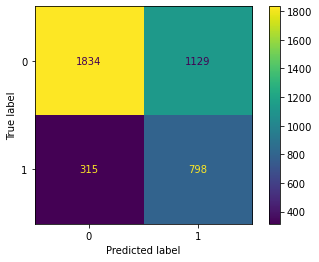

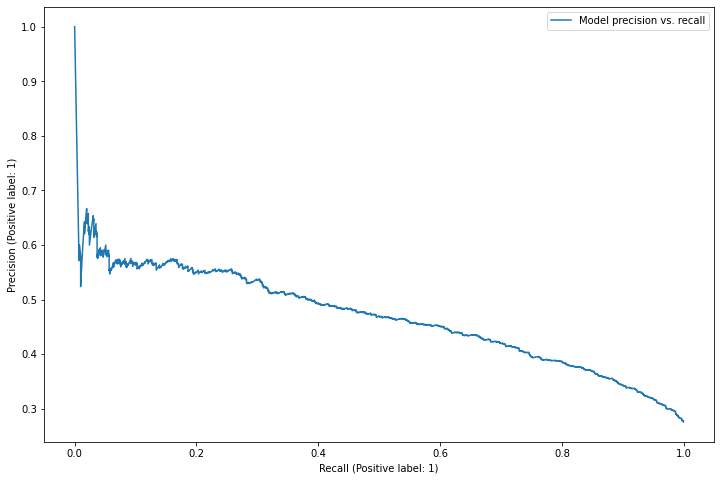

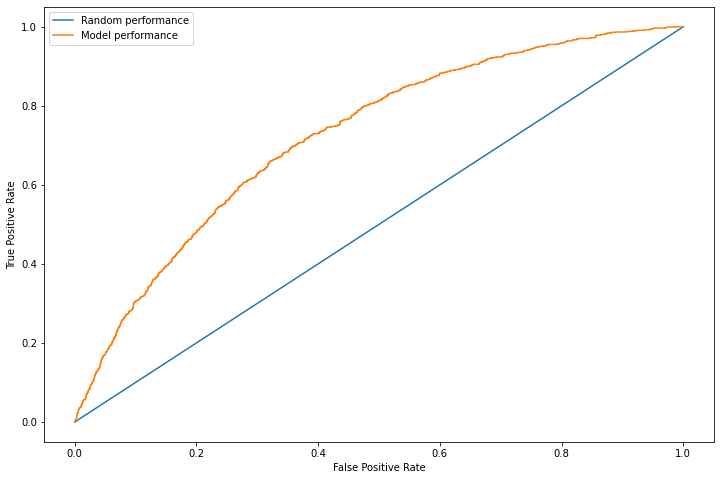

In [10]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [11]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-Adamax' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-Adamax20210603-0954


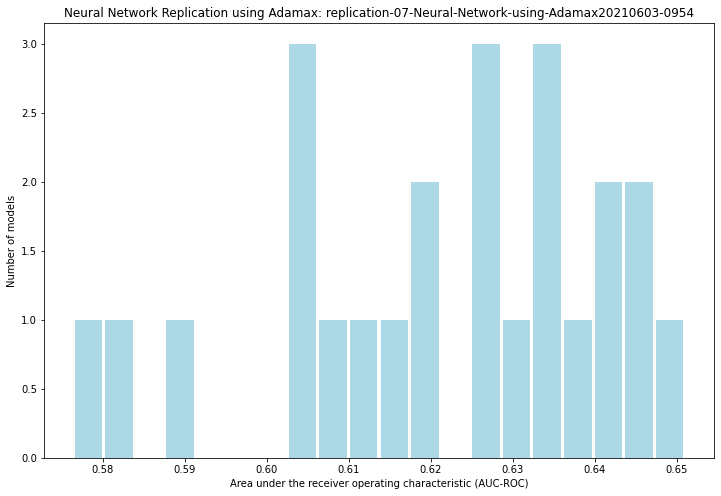

In [12]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using Adamax: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [13]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../NeuralNetworkResults'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)